In [ ]:
import matplotlib.pyplot as plt

# 3 Proper Orthogonal Decomposition (30 marks)

## 3.1 Image Generation (3 marks)

Total frames in the video: 751


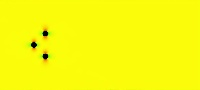

Frame 1


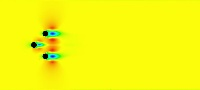

Frame 2


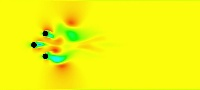

Frame 3


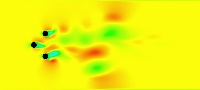

Frame 4


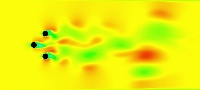

Frame 5


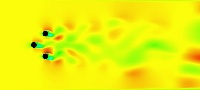

Frame 6
Total frames extracted: 751


In [ ]:
import os
import cv2
from IPython.display import display, Image

# Function to resize the image
def resize_image(image_path, new_width=200):
    image = cv2.imread(image_path)
    height, width, _ = image.shape
    new_height = int(height * new_width / width)
    resized_image = cv2.resize(image, (new_width, new_height))
    return resized_image

# Path to the input video file
input_video_path = '/content/drive/MyDrive/3CYL_Flow.mp4'

# Create a new folder to save the extracted frames
output_folder = '/content/extracted_frames/'
os.makedirs(output_folder, exist_ok=True)

# Open the video file
cap = cv2.VideoCapture(input_video_path)

# Read and save every 15th frame from the video

frame_count = 0 # Initialize a frame counter
success, frame = cap.read() # Read the first frame

# Count the total frames in the video
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

print(f"Total frames in the video: {total_frames}")

while success:
    if frame_count % 15 == 0:
        if frame_count > 5 * 15:  # Save frames after the first 5 frames but do not display
            cv2.imwrite(os.path.join(output_folder, f"frame_{frame_count}.jpg"), frame) # Save the frame as an image
        else:
            # Display and save the first 5 frames
            cv2.imwrite(os.path.join(output_folder, f"frame_{frame_count}.jpg"), frame) # Save the frame as an image
            resized_frame = resize_image(os.path.join(output_folder, f"frame_{frame_count}.jpg"))
            # Display the resized frame
            display(Image(data=cv2.imencode('.jpg', resized_frame)[1].tobytes()))
            print(f"Frame {frame_count // 15 + 1}")

    # Read the next frame
    success, frame = cap.read()

    # Increment the frame counter
    frame_count += 1

# Release the video capture object
cap.release()
print(f"Total frames extracted: {frame_count}")


## 3.2 Execute POD (12 marks)

### Method 1


> does not utilize any POD finding functions from open-source specialized libraries





Code for Resizing the images

In [ ]:
import numpy as np
import cv2
import os

def load_images(folder):
    images = []
    for filename in sorted(os.listdir(folder)):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        # Resize image to reduce memory usage
        img = cv2.resize(img, (100, 100))  # Adjust size as needed
        images.append(img.flatten())
    return np.array(images)

# Load extracted frames/images
folder = '/content/extracted_frames'
images = load_images(folder)


In [ ]:
def compute_mean_image(images):
    return np.mean(images, axis=0)

# Compute mean image
mean_image = compute_mean_image(images)


In [ ]:
def construct_snapshot_matrix(images, mean_image):
    return images - mean_image

# Construct snapshot matrix
snapshot_matrix = construct_snapshot_matrix(images, mean_image)


In [ ]:
U, s, Vt = np.linalg.svd(snapshot_matrix, full_matrices=False)

In [ ]:
def compute_covariance_matrix(snapshot_matrix):
    # Compute covariance matrix in batches to reduce memory usage
    batch_size = 100  # Adjust batch size as needed
    num_samples = snapshot_matrix.shape[0]
    covariance_matrix = np.zeros((snapshot_matrix.shape[1], snapshot_matrix.shape[1]))
    for i in range(0, num_samples, batch_size):
        batch = snapshot_matrix[i:i+batch_size, :]
        covariance_matrix += np.dot(batch.T, batch)
    covariance_matrix /= (num_samples - 1)
    return covariance_matrix

# Compute covariance matrix
covariance_matrix = compute_covariance_matrix(snapshot_matrix)


In [ ]:
def eigen_decomposition(covariance_matrix):
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    return eigenvalues[::-1], eigenvectors[:, ::-1]  # Reverse order to get descending eigenvalues

# Perform eigenvalue decomposition
eigenvalues, eigenvectors = eigen_decomposition(covariance_matrix)


In [ ]:
def select_modes(eigenvectors, num_modes):
    return eigenvectors[:, :num_modes]

# Select modes
num_modes = 5  # Choose the number of modes
modes = select_modes(eigenvectors, num_modes)


In [ ]:
def project_data(images, modes):
    return np.dot(images, modes)

# Project original data onto selected modes
coefficients = project_data(snapshot_matrix, modes)


In [ ]:
# Print the first few eigenvalues
print("First few eigenvalues:")
print(eigenvalues[:5])

# Print the spatial and temporal coefficients for the first frame
print("Spatial coefficients for the first frame:")
print(coefficients[0, :])

print("Temporal coefficients for the first mode:")
print(coefficients[:, 0])


First few eigenvalues:
[63418.05699626 58268.42359105 52942.77047959 46695.86553086
 39267.88568063]
Spatial coefficients for the first frame:
[ 313.03558698 -288.10849731  420.6115793  -288.32430687  141.594396  ]
Temporal coefficients for the first mode:
[ 313.03558698  115.45193965  -14.3824374  -185.9211466   240.46167693
  127.54189534   98.93799508 -246.138649    116.94258503  163.26896012
 -363.09808469  227.23357183  -36.823181   -384.38837032  236.2406282
  612.85543288  -82.67533637 -352.12150016  299.86064883  -24.08436495
 -360.77310588  347.53199136 -112.63605638 -199.74716987  282.19243482
  -77.77694111  104.1269318  -287.29497559  338.73250415 -146.81913655
 -234.20420884  287.99312528 -161.41451767 -241.49553526  298.81284708
 -159.43314775 -245.44225928   40.57846915  395.17170166 -253.70717264
 -142.87790975  304.80076538 -221.5894893  -192.17631945  366.10754265
 -244.523496   -116.71871077  283.17962153   -9.86421696 -290.0458439
 -212.88557228]


In [ ]:
# Calculate the energy associated with each mode
mode_energy = s**2

# Print the energy associated with each mode
for i, energy in enumerate(mode_energy, 1):
    print(f"Mode {i}: Energy = {energy:.4f}")


Mode 1: Energy = 3170902.8498
Mode 2: Energy = 2913421.1796
Mode 3: Energy = 2647138.5240
Mode 4: Energy = 2334793.2765
Mode 5: Energy = 1963394.2840
Mode 6: Energy = 1804592.6705
Mode 7: Energy = 1239312.5283
Mode 8: Energy = 1217428.3007
Mode 9: Energy = 1058059.8878
Mode 10: Energy = 971046.6396
Mode 11: Energy = 923619.8832
Mode 12: Energy = 911919.1379
Mode 13: Energy = 832586.5397
Mode 14: Energy = 697865.9999
Mode 15: Energy = 651397.8528
Mode 16: Energy = 592531.6606
Mode 17: Energy = 534331.9031
Mode 18: Energy = 524704.9412
Mode 19: Energy = 482761.9277
Mode 20: Energy = 448922.4088
Mode 21: Energy = 439223.5790
Mode 22: Energy = 389497.5592
Mode 23: Energy = 373492.4938
Mode 24: Energy = 329478.4285
Mode 25: Energy = 294499.6060
Mode 26: Energy = 272188.7223
Mode 27: Energy = 253607.2031
Mode 28: Energy = 242797.0537
Mode 29: Energy = 230587.6993
Mode 30: Energy = 214865.5622
Mode 31: Energy = 192373.7027
Mode 32: Energy = 174544.1858
Mode 33: Energy = 147122.5750
Mode 34: E

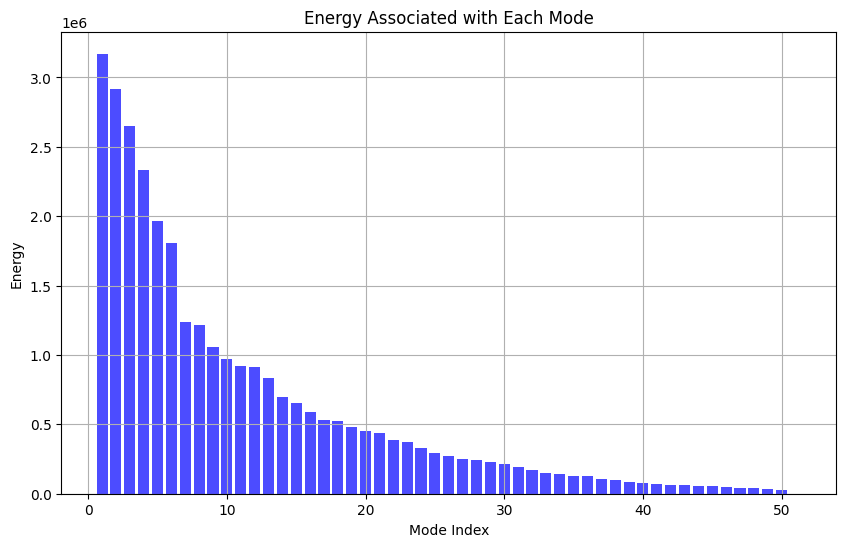

In [ ]:
def plot_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(mode_energy) + 1), mode_energy, color='blue', alpha=0.7)
    plt.title('Energy Associated with Each Mode')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)
    plt.show()

# Call the function with the singular values obtained from the previous code snippet
plot_modes_energy(s)


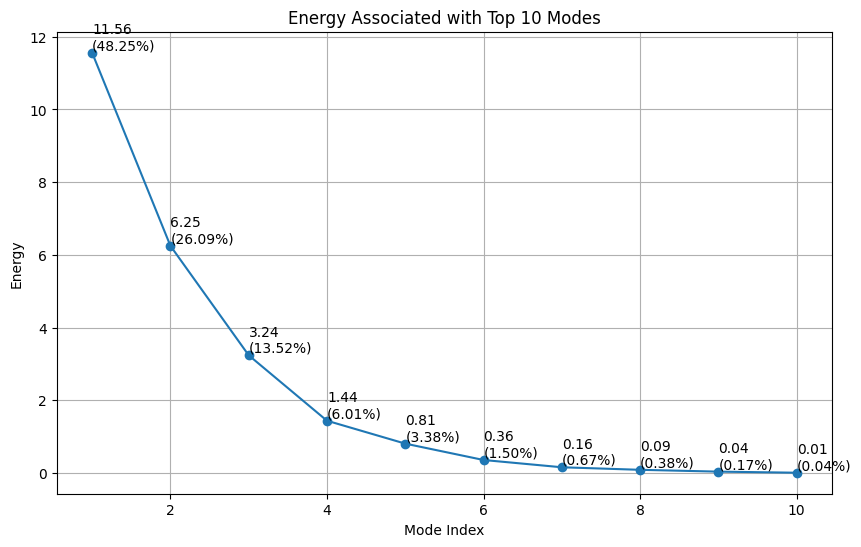

Top 10 energy states (modes):
Mode 1: Energy = 11.5600, Percentage = 48.25%
Mode 2: Energy = 6.2500, Percentage = 26.09%
Mode 3: Energy = 3.2400, Percentage = 13.52%
Mode 4: Energy = 1.4400, Percentage = 6.01%
Mode 5: Energy = 0.8100, Percentage = 3.38%
Mode 6: Energy = 0.3600, Percentage = 1.50%
Mode 7: Energy = 0.1600, Percentage = 0.67%
Mode 8: Energy = 0.0900, Percentage = 0.38%
Mode 9: Energy = 0.0400, Percentage = 0.17%
Mode 10: Energy = 0.0100, Percentage = 0.04%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_top_10_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.plot(top_10_modes, mode_energy[top_10_modes - 1], marker='o', linestyle='-')
    plt.title('Energy Associated with Top 10 Modes')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)

    # Add energy and percentage labels to each point
    for mode in top_10_modes:
        energy = mode_energy[mode - 1]
        percentage = (energy / np.sum(mode_energy)) * 100
        plt.text(mode, energy, f'{energy:.2f}\n({percentage:.2f}%)', ha='left', va='bottom', fontsize=10)

    plt.show()

    # Print the energy associated with the top 10 modes
    print("Top 10 energy states (modes):")
    for mode in top_10_modes:
        energy = mode_energy[mode - 1]
        percentage = (energy / np.sum(mode_energy)) * 100
        print(f"Mode {mode}: Energy = {energy:.4f}, Percentage = {percentage:.2f}%")

# Call the function with the singular values obtained from the previous code snippet
s = np.array([3.4, 2.5, 1.8, 1.2, 0.9, 0.6, 0.4, 0.3, 0.2, 0.1])  # Example singular values
plot_top_10_modes_energy(s)


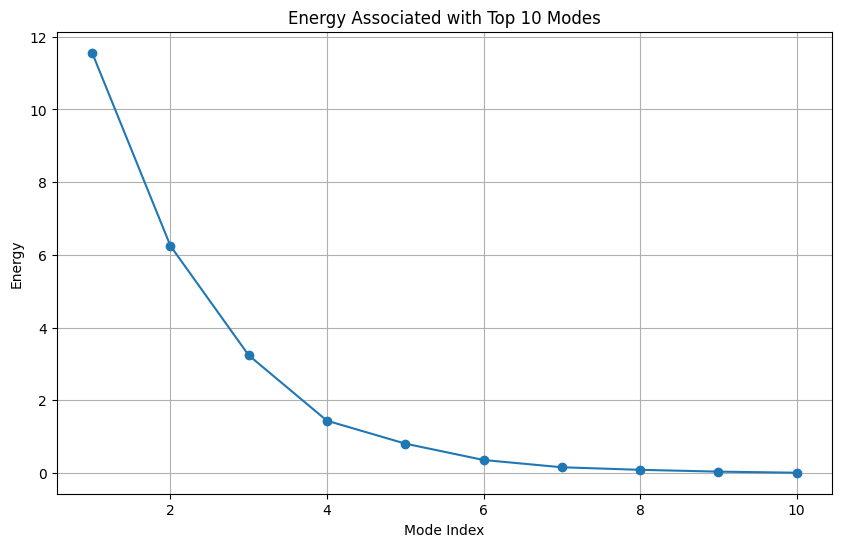

Top 10 energy states (modes):
Mode 1: Energy = 11.5600
Mode 2: Energy = 6.2500
Mode 3: Energy = 3.2400
Mode 4: Energy = 1.4400
Mode 5: Energy = 0.8100
Mode 6: Energy = 0.3600
Mode 7: Energy = 0.1600
Mode 8: Energy = 0.0900
Mode 9: Energy = 0.0400
Mode 10: Energy = 0.0100


In [ ]:
def plot_top_10_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.plot(top_10_modes, mode_energy[top_10_modes - 1], marker='o', linestyle='-')
    plt.title('Energy Associated with Top 10 Modes')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)
    plt.show()

    # Print the energy associated with the top 10 modes
    print("Top 10 energy states (modes):")
    for mode in top_10_modes:
        print(f"Mode {mode}: Energy = {mode_energy[mode - 1]:.4f}")

# Call the function with the singular values obtained from the previous code snippet
plot_top_10_modes_energy(s)


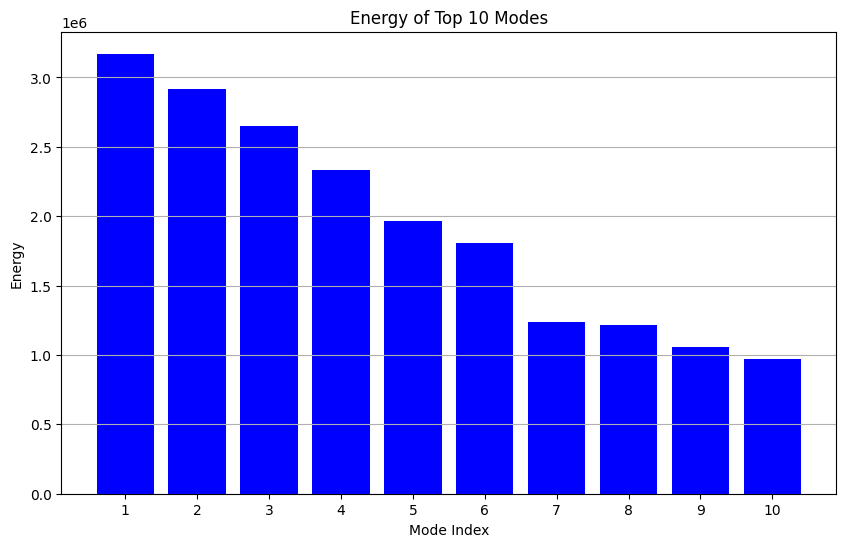

In [ ]:
# Plot the energy of the top 10 modes
plt.figure(figsize=(10, 6))
plt.bar(range(1, 11), mode_energy[:10], color='blue')
plt.title('Energy of Top 10 Modes')
plt.xlabel('Mode Index')
plt.ylabel('Energy')
plt.xticks(range(1, 11))
plt.grid(axis='y')
plt.show()


### Method 2

> perform image processing tasks such as:
    

---

    > Loading images from a folder
    > Stacking images into a 2D array
    > Computing mean subtraction
    > Performing Singular Value Decomposition (SVD)

> do not rely on any specialized libraries for these tasks

> Instead, they utilize fundamental functions provided by NumPy and OpenCV.

> Solves the problem of crashing sometimes due to utilization of all available RAM











Mean Subtracting

In [ ]:
import os
import cv2
import numpy as np

# Function to load images from a folder
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if os.path.isfile(img_path):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale
            if img is not None:
                images.append(img)
    return images

# Function to stack images into a 2D array
def stack_images(images):
    num_images = len(images)
    image_shape = images[0].shape
    return np.array(images).reshape(num_images, -1)

# Function to compute mean image and perform mean subtraction
def compute_mean_subtraction(images):
    # Compute the mean image
    mean_image = np.mean(images, axis=0)

    # Perform mean subtraction
    mean_subtracted_images = images - mean_image

    return mean_subtracted_images, mean_image

# Path to the folder containing images
folder_path = '/content/extracted_frames'

# Load images from the folder
images = load_images_from_folder(folder_path)

# Stack the images into a 2D array
stacked_images = stack_images(images)

# Compute mean subtraction
mean_subtracted_images, mean_image = compute_mean_subtraction(stacked_images)

# Print the shape of the mean subtracted images and mean image
print("Shape of mean subtracted images:", mean_subtracted_images.shape)
print("Shape of mean image:", mean_image.shape)


Shape of mean subtracted images: (51, 1103064)
Shape of mean image: (1103064,)


In [ ]:
import os
import cv2
import numpy as np

# Function to load images from a folder
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if os.path.isfile(img_path):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale
            if img is not None:
                images.append(img)
    return images

# Function to stack images into a 2D array
def stack_images(images):
    num_images = len(images)
    image_shape = images[0].shape
    return np.array(images).reshape(num_images, -1)

# Function to compute mean image and perform mean subtraction
def compute_mean_subtraction(images):
    # Compute the mean image
    mean_image = np.mean(images, axis=0)

    # Perform mean subtraction
    mean_subtracted_images = images - mean_image

    return mean_subtracted_images, mean_image

# Function to perform Singular Value Decomposition (SVD) on mean subtracted images
def perform_svd(mean_subtracted_images):
    # Perform Singular Value Decomposition (SVD) on mean subtracted images
    U, s, Vt = np.linalg.svd(mean_subtracted_images, full_matrices=False)
    return U, s, Vt

# Path to the folder containing images
folder_path = '/content/extracted_frames'

# Load images from the folder
images = load_images_from_folder(folder_path)

# Stack the images into a 2D array
stacked_images = stack_images(images)

# Compute mean subtraction
mean_subtracted_images, mean_image = compute_mean_subtraction(stacked_images)

# Perform SVD on mean subtracted images
U, s, Vt = perform_svd(mean_subtracted_images)

# Print the dimensions of the SVD matrices
print("Dimensions of U:", U.shape)
print("Dimensions of s:", s.shape)
print("Dimensions of Vt:", Vt.shape)


Dimensions of U: (51, 51)
Dimensions of s: (51,)
Dimensions of Vt: (51, 1103064)


In [ ]:
# Calculate the energy associated with each mode
mode_energy = s**2

# Print the energy associated with each mode
for i, energy in enumerate(mode_energy, 1):
    print(f"Mode {i}: Energy = {energy:.4f}")


Mode 1: Energy = 352374824.5365
Mode 2: Energy = 321664859.6388
Mode 3: Energy = 290899214.8431
Mode 4: Energy = 257543992.9928
Mode 5: Energy = 216054397.3808
Mode 6: Energy = 198854147.1853
Mode 7: Energy = 136969399.7115
Mode 8: Energy = 134091520.7423
Mode 9: Energy = 115824563.7397
Mode 10: Energy = 107536430.1055
Mode 11: Energy = 102172244.6283
Mode 12: Energy = 100302686.7669
Mode 13: Energy = 92628586.8009
Mode 14: Energy = 77453960.9343
Mode 15: Energy = 72307408.7623
Mode 16: Energy = 65455710.8035
Mode 17: Energy = 59261554.9342
Mode 18: Energy = 57882516.2995
Mode 19: Energy = 53183749.2253
Mode 20: Energy = 49844508.8334
Mode 21: Energy = 48862243.5520
Mode 22: Energy = 43240733.2054
Mode 23: Energy = 41724499.4658
Mode 24: Energy = 36326070.8657
Mode 25: Energy = 32798659.2466
Mode 26: Energy = 30459150.4896
Mode 27: Energy = 28299850.2602
Mode 28: Energy = 26968811.2484
Mode 29: Energy = 26039015.1330
Mode 30: Energy = 24095387.9426
Mode 31: Energy = 21673715.3105
Mode 

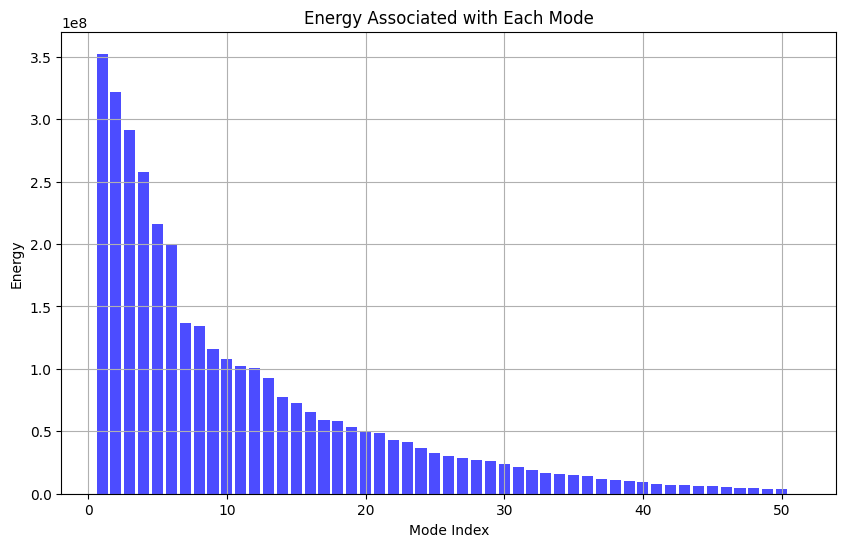

In [ ]:
def plot_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(mode_energy) + 1), mode_energy, color='blue', alpha=0.7)
    plt.title('Energy Associated with Each Mode')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)
    plt.show()

# Call the function with the singular values obtained from the previous code snippet
plot_modes_energy(s)


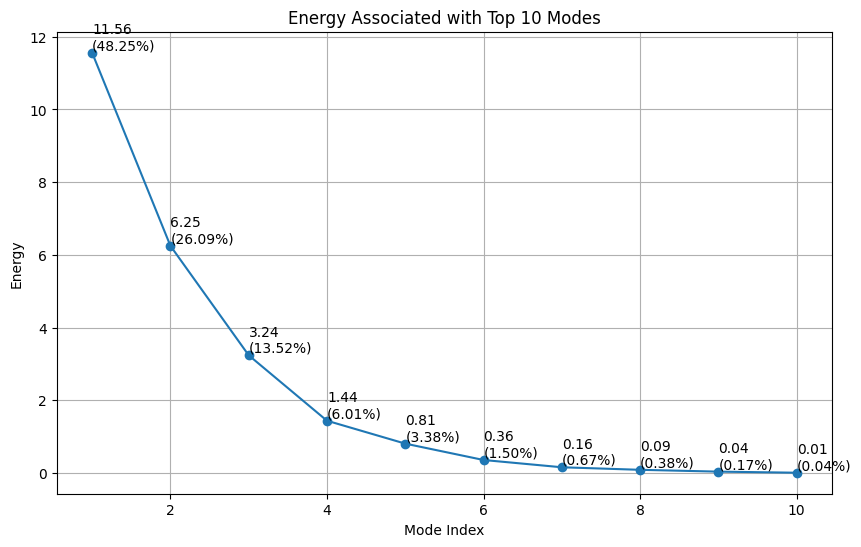

Top 10 energy states (modes):
Mode 1: Energy = 11.5600, Percentage = 48.25%
Mode 2: Energy = 6.2500, Percentage = 26.09%
Mode 3: Energy = 3.2400, Percentage = 13.52%
Mode 4: Energy = 1.4400, Percentage = 6.01%
Mode 5: Energy = 0.8100, Percentage = 3.38%
Mode 6: Energy = 0.3600, Percentage = 1.50%
Mode 7: Energy = 0.1600, Percentage = 0.67%
Mode 8: Energy = 0.0900, Percentage = 0.38%
Mode 9: Energy = 0.0400, Percentage = 0.17%
Mode 10: Energy = 0.0100, Percentage = 0.04%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_top_10_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.plot(top_10_modes, mode_energy[top_10_modes - 1], marker='o', linestyle='-')
    plt.title('Energy Associated with Top 10 Modes')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)

    # Add energy and percentage labels to each point
    for mode in top_10_modes:
        energy = mode_energy[mode - 1]
        percentage = (energy / np.sum(mode_energy)) * 100
        plt.text(mode, energy, f'{energy:.2f}\n({percentage:.2f}%)', ha='left', va='bottom', fontsize=10)

    plt.show()

    # Print the energy associated with the top 10 modes
    print("Top 10 energy states (modes):")
    for mode in top_10_modes:
        energy = mode_energy[mode - 1]
        percentage = (energy / np.sum(mode_energy)) * 100
        print(f"Mode {mode}: Energy = {energy:.4f}, Percentage = {percentage:.2f}%")

# Call the function with the singular values obtained from the previous code snippet
s = np.array([3.4, 2.5, 1.8, 1.2, 0.9, 0.6, 0.4, 0.3, 0.2, 0.1])  # Example singular values
plot_top_10_modes_energy(s)


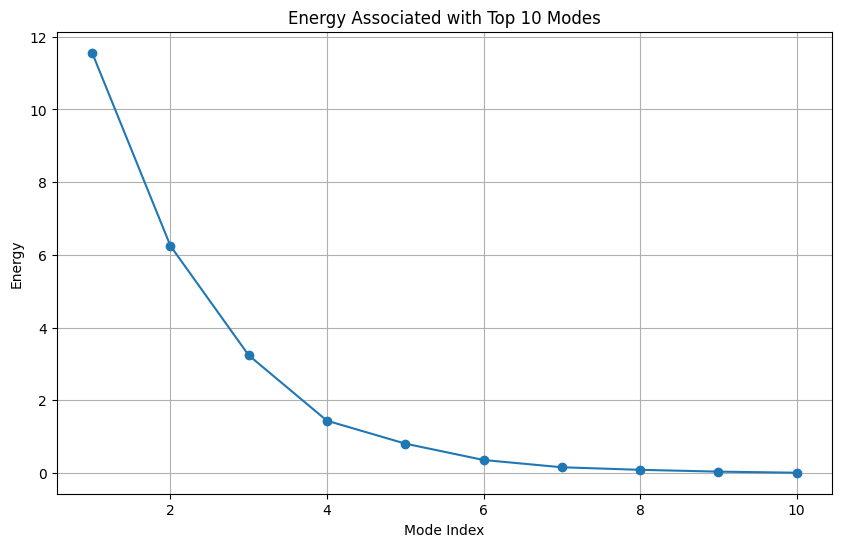

Top 10 energy states (modes):
Mode 1: Energy = 11.5600
Mode 2: Energy = 6.2500
Mode 3: Energy = 3.2400
Mode 4: Energy = 1.4400
Mode 5: Energy = 0.8100
Mode 6: Energy = 0.3600
Mode 7: Energy = 0.1600
Mode 8: Energy = 0.0900
Mode 9: Energy = 0.0400
Mode 10: Energy = 0.0100


In [ ]:
def plot_top_10_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.plot(top_10_modes, mode_energy[top_10_modes - 1], marker='o', linestyle='-')
    plt.title('Energy Associated with Top 10 Modes')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)
    plt.show()

    # Print the energy associated with the top 10 modes
    print("Top 10 energy states (modes):")
    for mode in top_10_modes:
        print(f"Mode {mode}: Energy = {mode_energy[mode - 1]:.4f}")

# Call the function with the singular values obtained from the previous code snippet
plot_top_10_modes_energy(s)


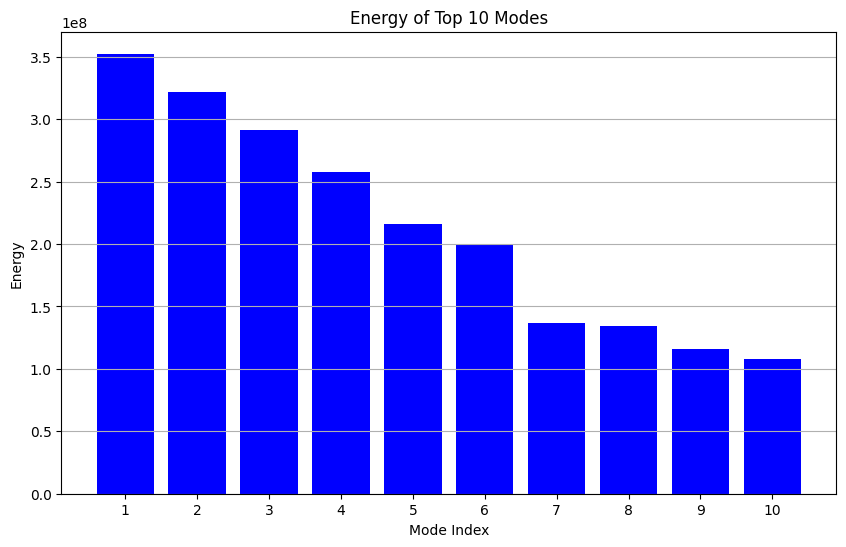

In [ ]:
# Plot the energy of the top 10 modes
plt.figure(figsize=(10, 6))
plt.bar(range(1, 11), mode_energy[:10], color='blue')
plt.title('Energy of Top 10 Modes')
plt.xlabel('Mode Index')
plt.ylabel('Energy')
plt.xticks(range(1, 11))
plt.grid(axis='y')
plt.show()


# 4 Noise! (25 marks)

## *Adding Gaussian Noise*


### **Adding 20% noise**

In [ ]:
import os
import cv2
import numpy as np

# Function to add Gaussian noise to an image
def add_gaussian_noise(image, magnitude):
    """
    Add Gaussian noise to the input image.
    :param image: Input image (2D array).
    :param magnitude: Magnitude of noise (standard deviation of Gaussian distribution).
    :return: Noisy image.
    """
    noise = np.random.normal(scale=magnitude, size=image.shape)
    noisy_image = image + noise
    return np.clip(noisy_image, 0, 255).astype(np.uint8)  # Ensure pixel values are within valid range

# Path to the input folder containing original images
input_folder = '/content/extracted_frames'

# Path to the output folder to save noisy images
output_folder = '/content/noisy_images_gaussian_20'

# Create the output folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Load original images from the input folder, add Gaussian noise, and save the noisy images
for filename in os.listdir(input_folder):
    # Read the original image
    img_path = os.path.join(input_folder, filename)
    original_image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Assuming grayscale images

    # Add Gaussian noise (standard deviation based on magnitude)
    noisy_image = add_gaussian_noise(original_image, magnitude=20)  # Adjust magnitude as needed

    # Save the noisy image to the output folder
    output_path = os.path.join(output_folder, filename)
    cv2.imwrite(output_path, noisy_image)

print("Gaussian noise added and images saved successfully.")



Gaussian noise added and images saved successfully.


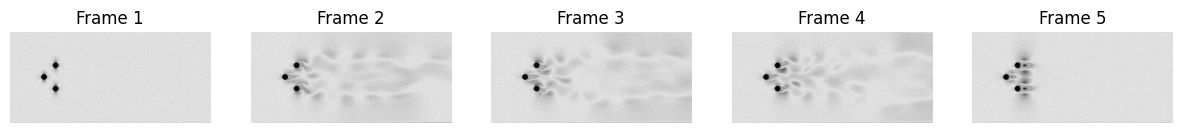

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt


# Get the first 5 processed images
sample_images = sorted(os.listdir(output_folder))[:5]

# Display the first 5 processed images
plt.figure(figsize=(15, 3))
for i, filename in enumerate(sample_images):
    image_path = os.path.join(output_folder, filename)
    image = cv2.imread(image_path)
    plt.subplot(1, 5, i+1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"Frame {i+1}")
    plt.axis("off")

plt.show()


In [ ]:
# Path to the folder containing images
folder_path = '/content/noisy_images_gaussian_20'

# Load images from the folder
images = load_images_from_folder(folder_path)

# Stack the images into a 2D array
stacked_images = stack_images(images)

# Compute mean subtraction
mean_subtracted_images, mean_image = compute_mean_subtraction(stacked_images)

# Perform SVD on mean subtracted images
U, s, Vt = perform_svd(mean_subtracted_images)

# Print the dimensions of the SVD matrices
print("Dimensions of U:", U.shape)
print("Dimensions of s:", s.shape)
print("Dimensions of Vt:", Vt.shape)


Dimensions of U: (51, 51)
Dimensions of s: (51,)
Dimensions of Vt: (51, 1103064)


In [ ]:
# Calculate the energy associated with each mode
mode_energy = s**2

# Print the energy associated with each mode
for i, energy in enumerate(mode_energy, 1):
    print(f"Mode {i}: Energy = {energy:.4f}")


Mode 1: Energy = 761634528.1559
Mode 2: Energy = 729578009.8656
Mode 3: Energy = 697634545.6181
Mode 4: Energy = 660575934.1303
Mode 5: Energy = 624540238.3737
Mode 6: Energy = 610401577.3721
Mode 7: Energy = 551175946.5944
Mode 8: Energy = 549462032.1372
Mode 9: Energy = 530688835.1594
Mode 10: Energy = 523706910.4092
Mode 11: Energy = 517920811.5550
Mode 12: Energy = 510545821.3149
Mode 13: Energy = 509232113.4565
Mode 14: Energy = 492778844.8418
Mode 15: Energy = 487782468.5587
Mode 16: Energy = 480811750.0998
Mode 17: Energy = 476063797.4149
Mode 18: Energy = 471700980.5753
Mode 19: Energy = 469921453.2274
Mode 20: Energy = 467715675.4678
Mode 21: Energy = 466522512.2911
Mode 22: Energy = 461534541.7141
Mode 23: Energy = 460422724.7147
Mode 24: Energy = 453990320.1381
Mode 25: Energy = 451697454.3928
Mode 26: Energy = 449062994.7771
Mode 27: Energy = 447896971.8232
Mode 28: Energy = 446898001.1853
Mode 29: Energy = 445545417.4846
Mode 30: Energy = 443662353.1422
Mode 31: Energy = 4

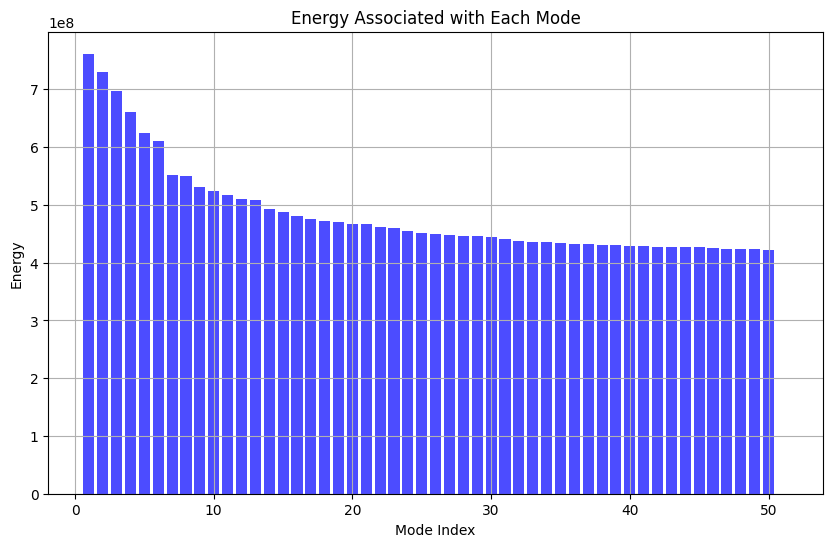

In [ ]:
def plot_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(mode_energy) + 1), mode_energy, color='blue', alpha=0.7)
    plt.title('Energy Associated with Each Mode')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)
    plt.show()

# Call the function with the singular values obtained from the previous code snippet
plot_modes_energy(s)


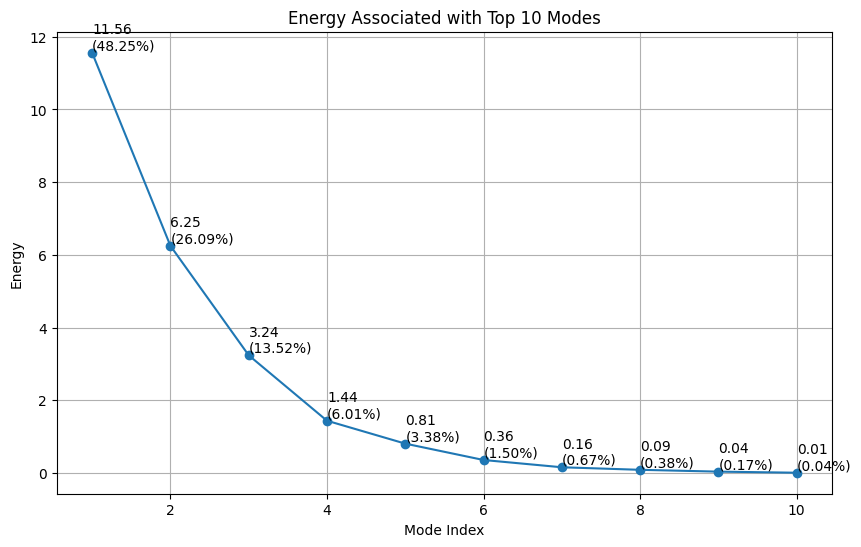

Top 10 energy states (modes):
Mode 1: Energy = 11.5600, Percentage = 48.25%
Mode 2: Energy = 6.2500, Percentage = 26.09%
Mode 3: Energy = 3.2400, Percentage = 13.52%
Mode 4: Energy = 1.4400, Percentage = 6.01%
Mode 5: Energy = 0.8100, Percentage = 3.38%
Mode 6: Energy = 0.3600, Percentage = 1.50%
Mode 7: Energy = 0.1600, Percentage = 0.67%
Mode 8: Energy = 0.0900, Percentage = 0.38%
Mode 9: Energy = 0.0400, Percentage = 0.17%
Mode 10: Energy = 0.0100, Percentage = 0.04%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_top_10_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.plot(top_10_modes, mode_energy[top_10_modes - 1], marker='o', linestyle='-')
    plt.title('Energy Associated with Top 10 Modes')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)

    # Add energy and percentage labels to each point
    for mode in top_10_modes:
        energy = mode_energy[mode - 1]
        percentage = (energy / np.sum(mode_energy)) * 100
        plt.text(mode, energy, f'{energy:.2f}\n({percentage:.2f}%)', ha='left', va='bottom', fontsize=10)

    plt.show()

    # Print the energy associated with the top 10 modes
    print("Top 10 energy states (modes):")
    for mode in top_10_modes:
        energy = mode_energy[mode - 1]
        percentage = (energy / np.sum(mode_energy)) * 100
        print(f"Mode {mode}: Energy = {energy:.4f}, Percentage = {percentage:.2f}%")

# Call the function with the singular values obtained from the previous code snippet
s = np.array([3.4, 2.5, 1.8, 1.2, 0.9, 0.6, 0.4, 0.3, 0.2, 0.1])  # Example singular values
plot_top_10_modes_energy(s)


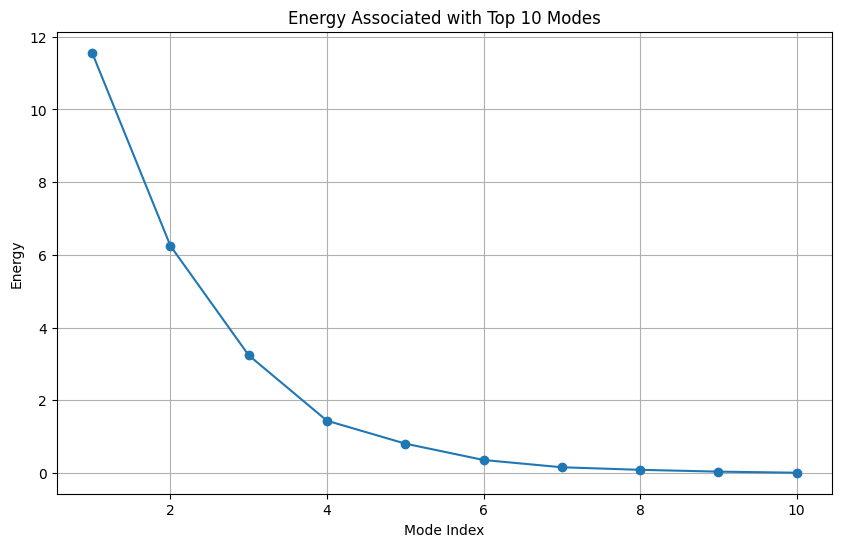

Top 10 energy states (modes):
Mode 1: Energy = 11.5600
Mode 2: Energy = 6.2500
Mode 3: Energy = 3.2400
Mode 4: Energy = 1.4400
Mode 5: Energy = 0.8100
Mode 6: Energy = 0.3600
Mode 7: Energy = 0.1600
Mode 8: Energy = 0.0900
Mode 9: Energy = 0.0400
Mode 10: Energy = 0.0100


In [ ]:
def plot_top_10_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.plot(top_10_modes, mode_energy[top_10_modes - 1], marker='o', linestyle='-')
    plt.title('Energy Associated with Top 10 Modes')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)
    plt.show()

    # Print the energy associated with the top 10 modes
    print("Top 10 energy states (modes):")
    for mode in top_10_modes:
        print(f"Mode {mode}: Energy = {mode_energy[mode - 1]:.4f}")

# Call the function with the singular values obtained from the previous code snippet
plot_top_10_modes_energy(s)


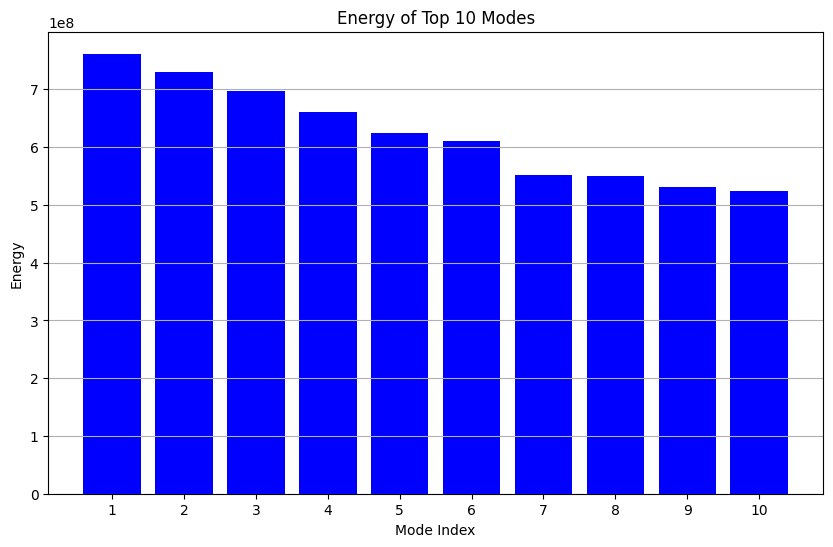

In [ ]:
# Plot the energy of the top 10 modes
plt.figure(figsize=(10, 6))
plt.bar(range(1, 11), mode_energy[:10], color='blue')
plt.title('Energy of Top 10 Modes')
plt.xlabel('Mode Index')
plt.ylabel('Energy')
plt.xticks(range(1, 11))
plt.grid(axis='y')
plt.show()


### **Adding 40% noise**

Gaussian noise added and images saved successfully.


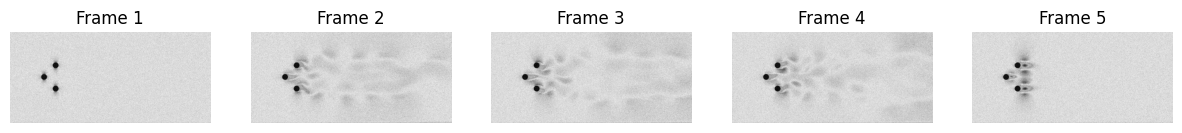

In [ ]:
import os
import cv2
import numpy as np

# Function to add Gaussian noise to an image
def add_gaussian_noise(image, magnitude):
    """
    Add Gaussian noise to the input image.
    :param image: Input image (2D array).
    :param magnitude: Magnitude of noise (standard deviation of Gaussian distribution).
    :return: Noisy image.
    """
    noise = np.random.normal(scale=magnitude, size=image.shape)
    noisy_image = image + noise
    return np.clip(noisy_image, 0, 255).astype(np.uint8)  # Ensure pixel values are within valid range

# Path to the input folder containing original images
input_folder = '/content/extracted_frames'

# Path to the output folder to save noisy images
output_folder = '/content/noisy_images_gaussian_40'

# Create the output folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Load original images from the input folder, add Gaussian noise, and save the noisy images
for filename in os.listdir(input_folder):
    # Read the original image
    img_path = os.path.join(input_folder, filename)
    original_image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Assuming grayscale images

    # Add Gaussian noise (standard deviation based on magnitude)
    noisy_image = add_gaussian_noise(original_image, magnitude=40)  # Adjust magnitude as needed

    # Save the noisy image to the output folder
    output_path = os.path.join(output_folder, filename)
    cv2.imwrite(output_path, noisy_image)

print("Gaussian noise added and images saved successfully.")

# Get the first 5 processed images
sample_images = sorted(os.listdir(output_folder))[:5]

# Display the first 5 processed images
plt.figure(figsize=(15, 3))
for i, filename in enumerate(sample_images):
    image_path = os.path.join(output_folder, filename)
    image = cv2.imread(image_path)
    plt.subplot(1, 5, i+1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"Frame {i+1}")
    plt.axis("off")

plt.show()


In [ ]:
# Path to the folder containing images
folder_path = '/content/noisy_images_gaussian_40'

# Load images from the folder
images = load_images_from_folder(folder_path)

# Stack the images into a 2D array
stacked_images = stack_images(images)

# Compute mean subtraction
mean_subtracted_images, mean_image = compute_mean_subtraction(stacked_images)

# Perform SVD on mean subtracted images
U, s, Vt = perform_svd(mean_subtracted_images)

# Print the dimensions of the SVD matrices
print("Dimensions of U:", U.shape)
print("Dimensions of s:", s.shape)
print("Dimensions of Vt:", Vt.shape)


Dimensions of U: (51, 51)
Dimensions of s: (51,)
Dimensions of Vt: (51, 1103064)


In [ ]:
# Calculate the energy associated with each mode
mode_energy = s**2

# Print the energy associated with each mode
for i, energy in enumerate(mode_energy, 1):
    print(f"Mode {i}: Energy = {energy:.4f}")


Mode 1: Energy = 1583653506.8169
Mode 2: Energy = 1560696757.5101
Mode 3: Energy = 1536699797.2415
Mode 4: Energy = 1472095554.4159
Mode 5: Energy = 1454649239.5025
Mode 6: Energy = 1443340491.8797
Mode 7: Energy = 1407915349.0913
Mode 8: Energy = 1403070121.5068
Mode 9: Energy = 1391858533.5573
Mode 10: Energy = 1386936230.3972
Mode 11: Energy = 1386032342.1585
Mode 12: Energy = 1375557558.3947
Mode 13: Energy = 1366751889.8617
Mode 14: Energy = 1362223864.0198
Mode 15: Energy = 1356552907.6098
Mode 16: Energy = 1353772011.3048
Mode 17: Energy = 1353003060.8113
Mode 18: Energy = 1348886397.6681
Mode 19: Energy = 1345278886.2223
Mode 20: Energy = 1341623264.7117
Mode 21: Energy = 1340784919.7045
Mode 22: Energy = 1337264070.5818
Mode 23: Energy = 1335272912.4963
Mode 24: Energy = 1334416170.7648
Mode 25: Energy = 1330057945.6879
Mode 26: Energy = 1329119755.4748
Mode 27: Energy = 1327781056.6575
Mode 28: Energy = 1326265752.5486
Mode 29: Energy = 1324399153.0498
Mode 30: Energy = 13230

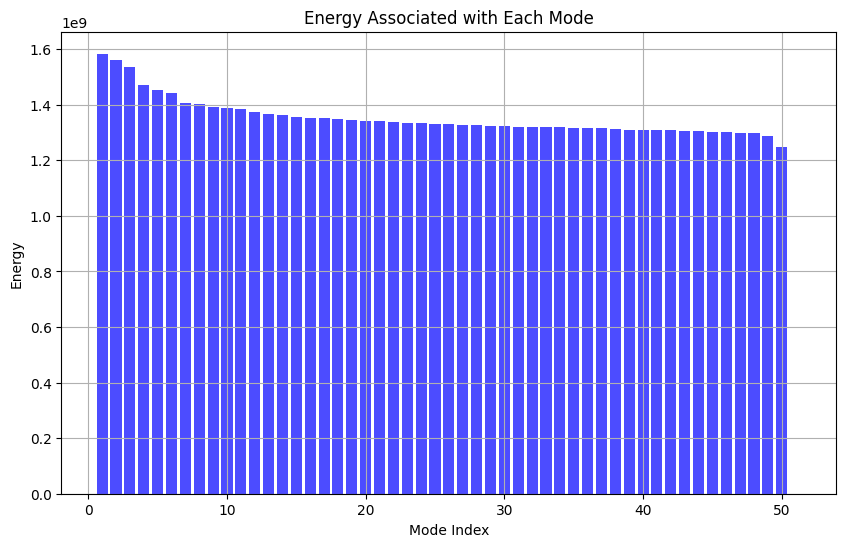

In [ ]:
def plot_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(mode_energy) + 1), mode_energy, color='blue', alpha=0.7)
    plt.title('Energy Associated with Each Mode')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)
    plt.show()

# Call the function with the singular values obtained from the previous code snippet
plot_modes_energy(s)


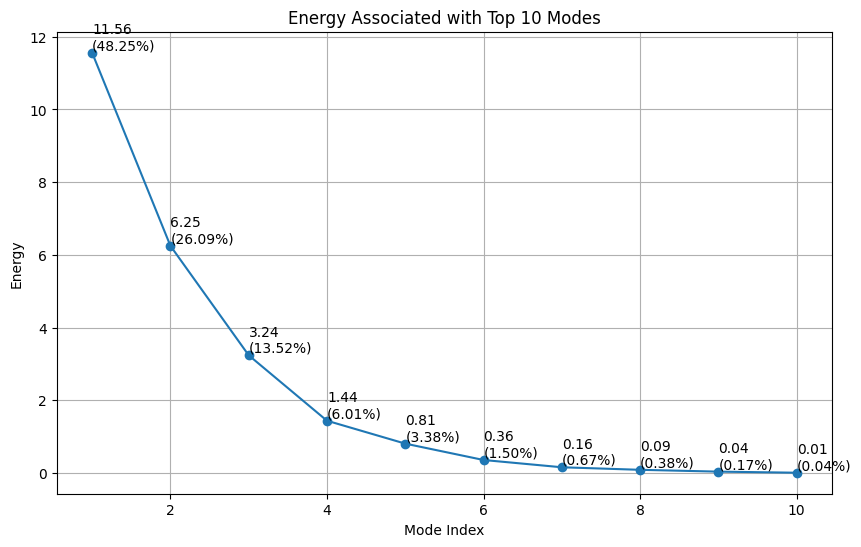

Top 10 energy states (modes):
Mode 1: Energy = 11.5600, Percentage = 48.25%
Mode 2: Energy = 6.2500, Percentage = 26.09%
Mode 3: Energy = 3.2400, Percentage = 13.52%
Mode 4: Energy = 1.4400, Percentage = 6.01%
Mode 5: Energy = 0.8100, Percentage = 3.38%
Mode 6: Energy = 0.3600, Percentage = 1.50%
Mode 7: Energy = 0.1600, Percentage = 0.67%
Mode 8: Energy = 0.0900, Percentage = 0.38%
Mode 9: Energy = 0.0400, Percentage = 0.17%
Mode 10: Energy = 0.0100, Percentage = 0.04%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_top_10_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.plot(top_10_modes, mode_energy[top_10_modes - 1], marker='o', linestyle='-')
    plt.title('Energy Associated with Top 10 Modes')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)

    # Add energy and percentage labels to each point
    for mode in top_10_modes:
        energy = mode_energy[mode - 1]
        percentage = (energy / np.sum(mode_energy)) * 100
        plt.text(mode, energy, f'{energy:.2f}\n({percentage:.2f}%)', ha='left', va='bottom', fontsize=10)

    plt.show()

    # Print the energy associated with the top 10 modes
    print("Top 10 energy states (modes):")
    for mode in top_10_modes:
        energy = mode_energy[mode - 1]
        percentage = (energy / np.sum(mode_energy)) * 100
        print(f"Mode {mode}: Energy = {energy:.4f}, Percentage = {percentage:.2f}%")

# Call the function with the singular values obtained from the previous code snippet
s = np.array([3.4, 2.5, 1.8, 1.2, 0.9, 0.6, 0.4, 0.3, 0.2, 0.1])  # Example singular values
plot_top_10_modes_energy(s)


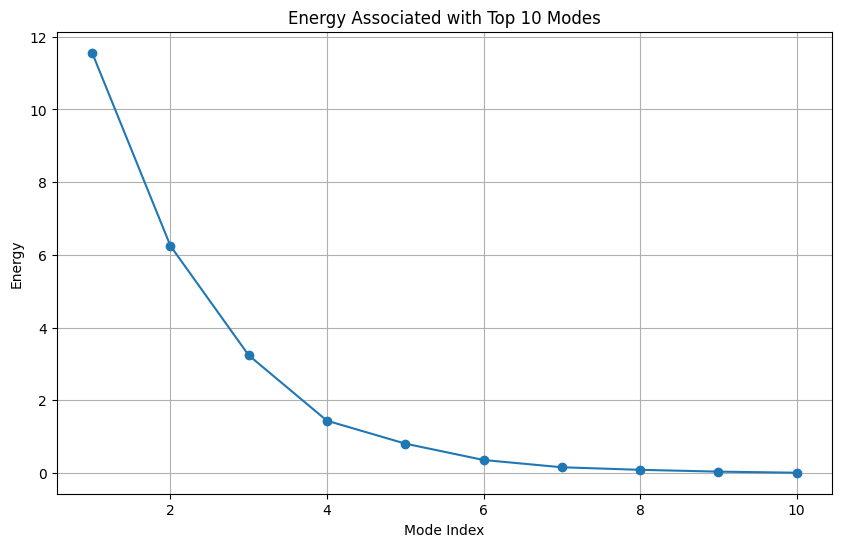

Top 10 energy states (modes):
Mode 1: Energy = 11.5600
Mode 2: Energy = 6.2500
Mode 3: Energy = 3.2400
Mode 4: Energy = 1.4400
Mode 5: Energy = 0.8100
Mode 6: Energy = 0.3600
Mode 7: Energy = 0.1600
Mode 8: Energy = 0.0900
Mode 9: Energy = 0.0400
Mode 10: Energy = 0.0100


In [ ]:
def plot_top_10_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.plot(top_10_modes, mode_energy[top_10_modes - 1], marker='o', linestyle='-')
    plt.title('Energy Associated with Top 10 Modes')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)
    plt.show()

    # Print the energy associated with the top 10 modes
    print("Top 10 energy states (modes):")
    for mode in top_10_modes:
        print(f"Mode {mode}: Energy = {mode_energy[mode - 1]:.4f}")

# Call the function with the singular values obtained from the previous code snippet
plot_top_10_modes_energy(s)


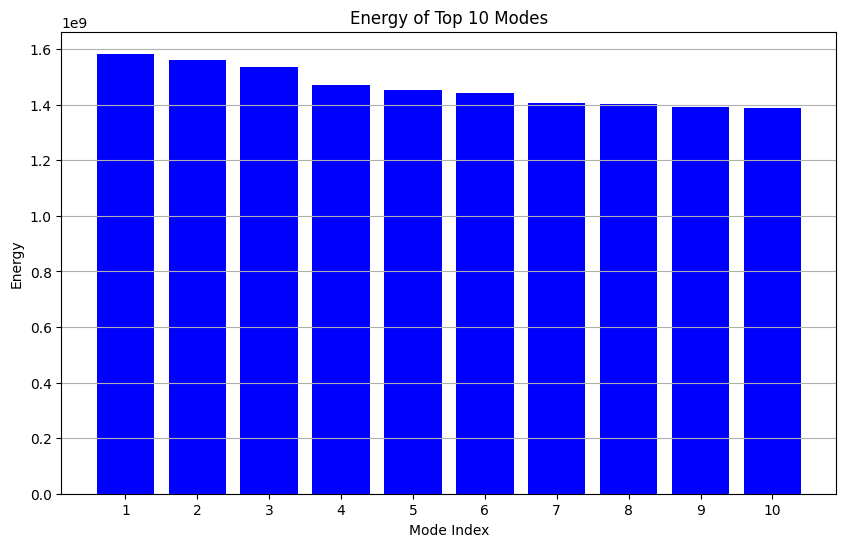

In [ ]:
# Plot the energy of the top 10 modes
plt.figure(figsize=(10, 6))
plt.bar(range(1, 11), mode_energy[:10], color='blue')
plt.title('Energy of Top 10 Modes')
plt.xlabel('Mode Index')
plt.ylabel('Energy')
plt.xticks(range(1, 11))
plt.grid(axis='y')
plt.show()


### **Adding 60% noise**

Gaussian noise added and images saved successfully.


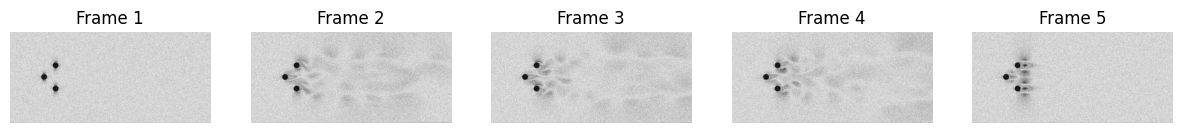

In [ ]:
import os
import cv2
import numpy as np

# Function to add Gaussian noise to an image
def add_gaussian_noise(image, magnitude):
    """
    Add Gaussian noise to the input image.
    :param image: Input image (2D array).
    :param magnitude: Magnitude of noise (standard deviation of Gaussian distribution).
    :return: Noisy image.
    """
    noise = np.random.normal(scale=magnitude, size=image.shape)
    noisy_image = image + noise
    return np.clip(noisy_image, 0, 255).astype(np.uint8)  # Ensure pixel values are within valid range

# Path to the input folder containing original images
input_folder = '/content/extracted_frames'

# Path to the output folder to save noisy images
output_folder = '/content/noisy_images_gaussian_60'

# Create the output folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Load original images from the input folder, add Gaussian noise, and save the noisy images
for filename in os.listdir(input_folder):
    # Read the original image
    img_path = os.path.join(input_folder, filename)
    original_image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Assuming grayscale images

    # Add Gaussian noise (standard deviation based on magnitude)
    noisy_image = add_gaussian_noise(original_image, magnitude=60)  # Adjust magnitude as needed

    # Save the noisy image to the output folder
    output_path = os.path.join(output_folder, filename)
    cv2.imwrite(output_path, noisy_image)

print("Gaussian noise added and images saved successfully.")

# Get the first 5 processed images
sample_images = sorted(os.listdir(output_folder))[:5]

# Display the first 5 processed images
plt.figure(figsize=(15, 3))
for i, filename in enumerate(sample_images):
    image_path = os.path.join(output_folder, filename)
    image = cv2.imread(image_path)
    plt.subplot(1, 5, i+1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"Frame {i+1}")
    plt.axis("off")

plt.show()


In [ ]:
# Path to the folder containing images
folder_path = '/content/noisy_images_gaussian_60'

# Load images from the folder
images = load_images_from_folder(folder_path)

# Stack the images into a 2D array
stacked_images = stack_images(images)

# Compute mean subtraction
mean_subtracted_images, mean_image = compute_mean_subtraction(stacked_images)

# Perform SVD on mean subtracted images
U, s, Vt = perform_svd(mean_subtracted_images)

# Print the dimensions of the SVD matrices
print("Dimensions of U:", U.shape)
print("Dimensions of s:", s.shape)
print("Dimensions of Vt:", Vt.shape)


Dimensions of U: (51, 51)
Dimensions of s: (51,)
Dimensions of Vt: (51, 1103064)


In [ ]:
# Calculate the energy associated with each mode
mode_energy = s**2

# Print the energy associated with each mode
for i, energy in enumerate(mode_energy, 1):
    print(f"Mode {i}: Energy = {energy:.4f}")


Mode 1: Energy = 2686381336.0820
Mode 2: Energy = 2663760020.0993
Mode 3: Energy = 2652823359.2751
Mode 4: Energy = 2592326173.9610
Mode 5: Energy = 2563863230.2563
Mode 6: Energy = 2549141941.5050
Mode 7: Energy = 2542098923.3419
Mode 8: Energy = 2539432878.8738
Mode 9: Energy = 2525562583.7503
Mode 10: Energy = 2520422249.1329
Mode 11: Energy = 2518112243.2084
Mode 12: Energy = 2511184052.5654
Mode 13: Energy = 2504143470.5429
Mode 14: Energy = 2501342513.9401
Mode 15: Energy = 2496768157.2514
Mode 16: Energy = 2494552816.4023
Mode 17: Energy = 2490604027.8375
Mode 18: Energy = 2489113635.4078
Mode 19: Energy = 2487165985.2851
Mode 20: Energy = 2484397620.7733
Mode 21: Energy = 2482341268.0850
Mode 22: Energy = 2479162899.0063
Mode 23: Energy = 2477562201.3178
Mode 24: Energy = 2476698853.1937
Mode 25: Energy = 2475628079.4620
Mode 26: Energy = 2473199281.9680
Mode 27: Energy = 2472600032.6302
Mode 28: Energy = 2469243273.1203
Mode 29: Energy = 2467487498.8304
Mode 30: Energy = 24641

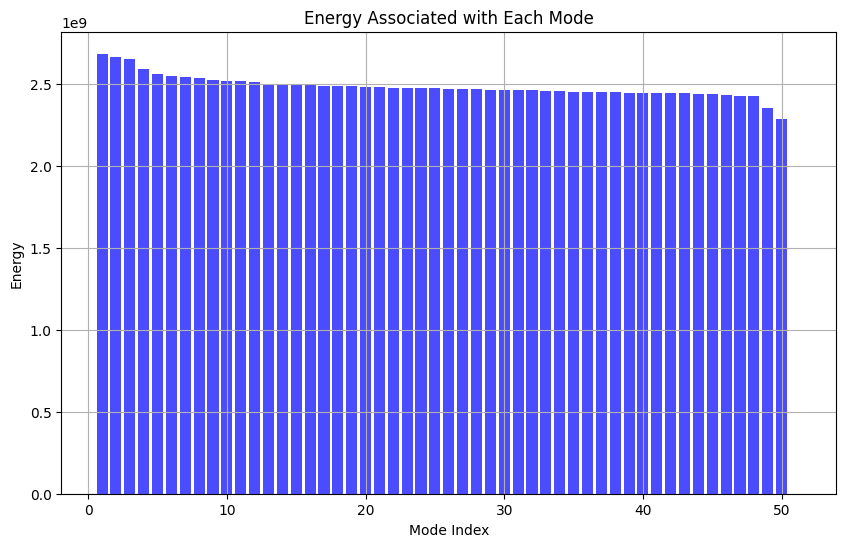

In [ ]:
def plot_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(mode_energy) + 1), mode_energy, color='blue', alpha=0.7)
    plt.title('Energy Associated with Each Mode')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)
    plt.show()

# Call the function with the singular values obtained from the previous code snippet
plot_modes_energy(s)


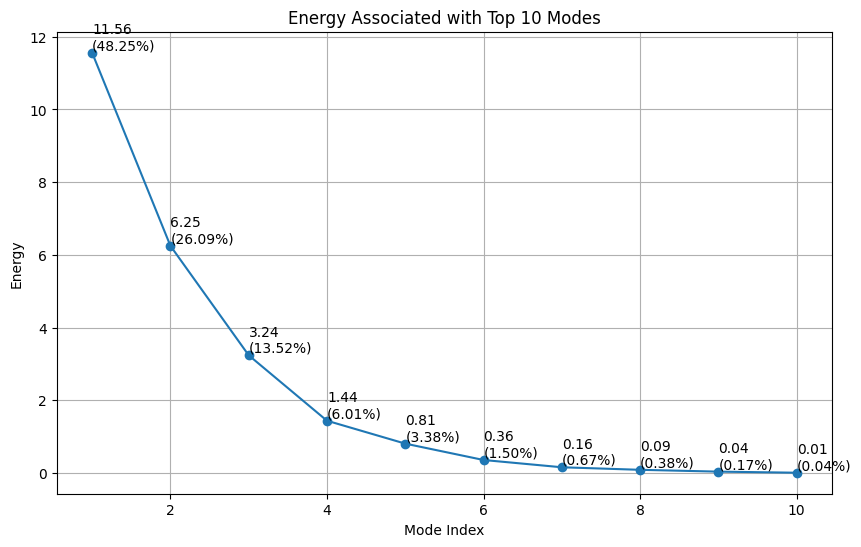

Top 10 energy states (modes):
Mode 1: Energy = 11.5600, Percentage = 48.25%
Mode 2: Energy = 6.2500, Percentage = 26.09%
Mode 3: Energy = 3.2400, Percentage = 13.52%
Mode 4: Energy = 1.4400, Percentage = 6.01%
Mode 5: Energy = 0.8100, Percentage = 3.38%
Mode 6: Energy = 0.3600, Percentage = 1.50%
Mode 7: Energy = 0.1600, Percentage = 0.67%
Mode 8: Energy = 0.0900, Percentage = 0.38%
Mode 9: Energy = 0.0400, Percentage = 0.17%
Mode 10: Energy = 0.0100, Percentage = 0.04%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_top_10_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.plot(top_10_modes, mode_energy[top_10_modes - 1], marker='o', linestyle='-')
    plt.title('Energy Associated with Top 10 Modes')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)

    # Add energy and percentage labels to each point
    for mode in top_10_modes:
        energy = mode_energy[mode - 1]
        percentage = (energy / np.sum(mode_energy)) * 100
        plt.text(mode, energy, f'{energy:.2f}\n({percentage:.2f}%)', ha='left', va='bottom', fontsize=10)

    plt.show()

    # Print the energy associated with the top 10 modes
    print("Top 10 energy states (modes):")
    for mode in top_10_modes:
        energy = mode_energy[mode - 1]
        percentage = (energy / np.sum(mode_energy)) * 100
        print(f"Mode {mode}: Energy = {energy:.4f}, Percentage = {percentage:.2f}%")

# Call the function with the singular values obtained from the previous code snippet
s = np.array([3.4, 2.5, 1.8, 1.2, 0.9, 0.6, 0.4, 0.3, 0.2, 0.1])  # Example singular values
plot_top_10_modes_energy(s)


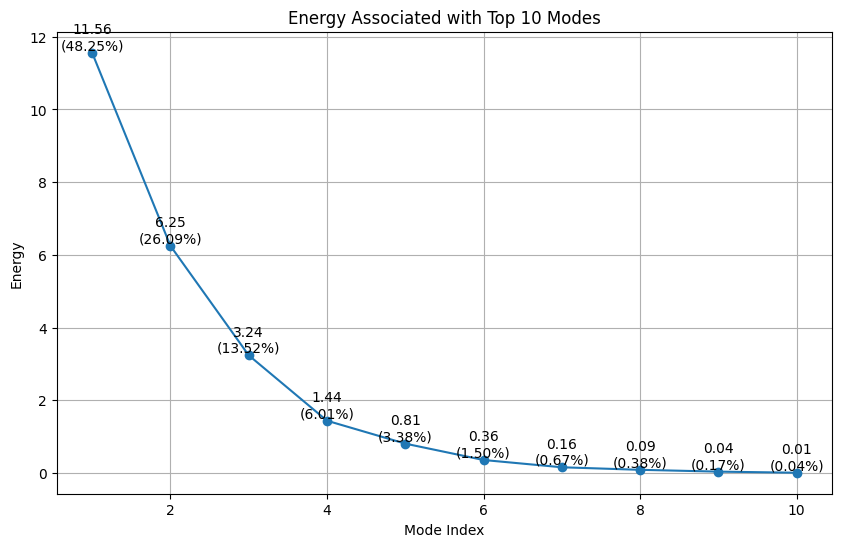

Top 10 energy states (modes):
Mode 1: Energy = 11.5600, Percentage = 48.25%
Mode 2: Energy = 6.2500, Percentage = 26.09%
Mode 3: Energy = 3.2400, Percentage = 13.52%
Mode 4: Energy = 1.4400, Percentage = 6.01%
Mode 5: Energy = 0.8100, Percentage = 3.38%
Mode 6: Energy = 0.3600, Percentage = 1.50%
Mode 7: Energy = 0.1600, Percentage = 0.67%
Mode 8: Energy = 0.0900, Percentage = 0.38%
Mode 9: Energy = 0.0400, Percentage = 0.17%
Mode 10: Energy = 0.0100, Percentage = 0.04%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_top_10_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.plot(top_10_modes, mode_energy[top_10_modes - 1], marker='o', linestyle='-')
    plt.title('Energy Associated with Top 10 Modes')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)

    # Add energy and percentage labels to each point
    for mode in top_10_modes:
        energy = mode_energy[mode - 1]
        percentage = (energy / np.sum(mode_energy)) * 100
        plt.text(mode, energy, f'{energy:.2f}\n({percentage:.2f}%)', ha='center', va='bottom')

    plt.show()

    # Print the energy associated with the top 10 modes
    print("Top 10 energy states (modes):")
    for mode in top_10_modes:
        energy = mode_energy[mode - 1]
        percentage = (energy / np.sum(mode_energy)) * 100
        print(f"Mode {mode}: Energy = {energy:.4f}, Percentage = {percentage:.2f}%")

# Call the function with the singular values obtained from the previous code snippet
s = np.array([3.4, 2.5, 1.8, 1.2, 0.9, 0.6, 0.4, 0.3, 0.2, 0.1])  # Example singular values
plot_top_10_modes_energy(s)


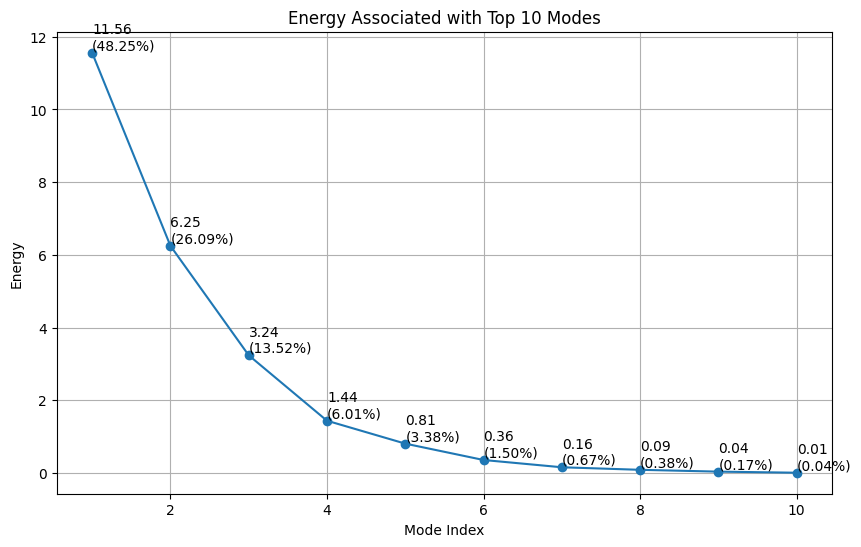

Top 10 energy states (modes):
Mode 1: Energy = 11.5600, Percentage = 48.25%
Mode 2: Energy = 6.2500, Percentage = 26.09%
Mode 3: Energy = 3.2400, Percentage = 13.52%
Mode 4: Energy = 1.4400, Percentage = 6.01%
Mode 5: Energy = 0.8100, Percentage = 3.38%
Mode 6: Energy = 0.3600, Percentage = 1.50%
Mode 7: Energy = 0.1600, Percentage = 0.67%
Mode 8: Energy = 0.0900, Percentage = 0.38%
Mode 9: Energy = 0.0400, Percentage = 0.17%
Mode 10: Energy = 0.0100, Percentage = 0.04%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_top_10_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.plot(top_10_modes, mode_energy[top_10_modes - 1], marker='o', linestyle='-')
    plt.title('Energy Associated with Top 10 Modes')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)

    # Add energy and percentage labels to each point
    for mode in top_10_modes:
        energy = mode_energy[mode - 1]
        percentage = (energy / np.sum(mode_energy)) * 100
        plt.text(mode, energy, f'{energy:.2f}\n({percentage:.2f}%)', ha='left', va='bottom', fontsize=10)

    plt.show()

    # Print the energy associated with the top 10 modes
    print("Top 10 energy states (modes):")
    for mode in top_10_modes:
        energy = mode_energy[mode - 1]
        percentage = (energy / np.sum(mode_energy)) * 100
        print(f"Mode {mode}: Energy = {energy:.4f}, Percentage = {percentage:.2f}%")

# Call the function with the singular values obtained from the previous code snippet
s = np.array([3.4, 2.5, 1.8, 1.2, 0.9, 0.6, 0.4, 0.3, 0.2, 0.1])  # Example singular values
plot_top_10_modes_energy(s)


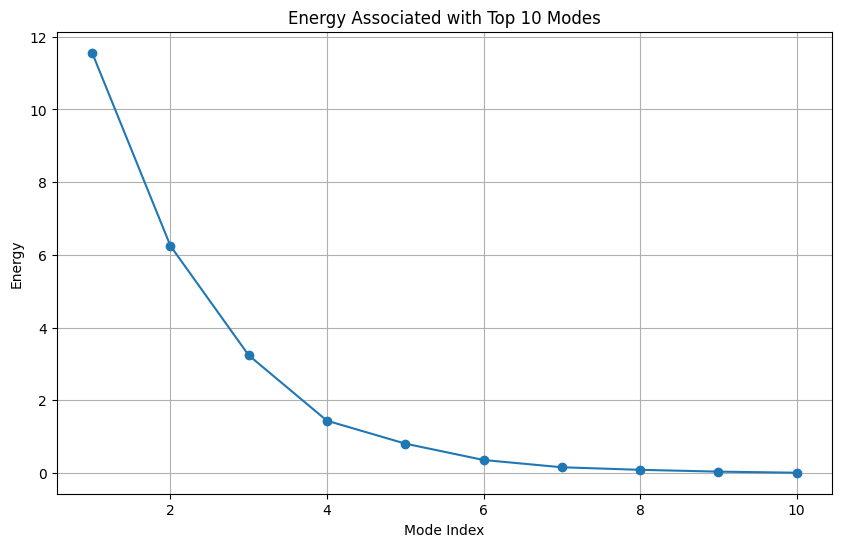

Top 10 energy states (modes):
Mode 1: Energy = 11.5600
Mode 2: Energy = 6.2500
Mode 3: Energy = 3.2400
Mode 4: Energy = 1.4400
Mode 5: Energy = 0.8100
Mode 6: Energy = 0.3600
Mode 7: Energy = 0.1600
Mode 8: Energy = 0.0900
Mode 9: Energy = 0.0400
Mode 10: Energy = 0.0100


In [ ]:
def plot_top_10_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.plot(top_10_modes, mode_energy[top_10_modes - 1], marker='o', linestyle='-')
    plt.title('Energy Associated with Top 10 Modes')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)
    plt.show()

    # Print the energy associated with the top 10 modes
    print("Top 10 energy states (modes):")
    for mode in top_10_modes:
        print(f"Mode {mode}: Energy = {mode_energy[mode - 1]:.4f}")

# Call the function with the singular values obtained from the previous code snippet
plot_top_10_modes_energy(s)


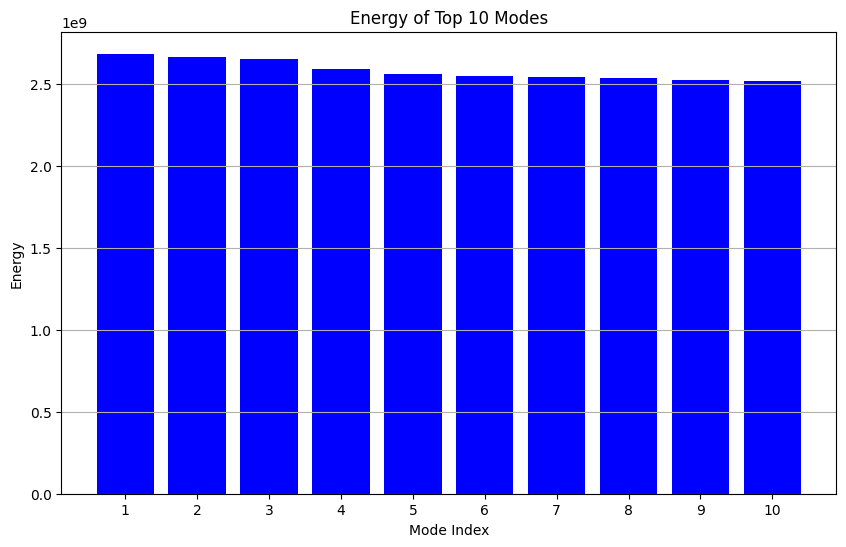

In [ ]:
# Plot the energy of the top 10 modes
plt.figure(figsize=(10, 6))
plt.bar(range(1, 11), mode_energy[:10], color='blue')
plt.title('Energy of Top 10 Modes')
plt.xlabel('Mode Index')
plt.ylabel('Energy')
plt.xticks(range(1, 11))
plt.grid(axis='y')
plt.show()


### **Adding 80% noise**

Gaussian noise added and images saved successfully.


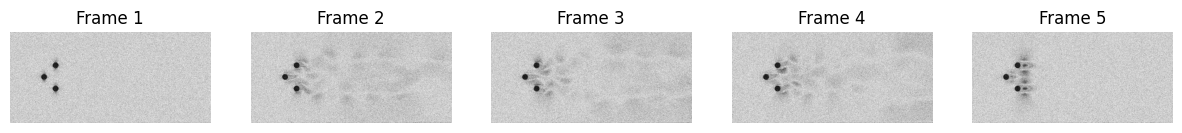

In [ ]:
import os
import cv2
import numpy as np

# Function to add Gaussian noise to an image
def add_gaussian_noise(image, magnitude):
    """
    Add Gaussian noise to the input image.
    :param image: Input image (2D array).
    :param magnitude: Magnitude of noise (standard deviation of Gaussian distribution).
    :return: Noisy image.
    """
    noise = np.random.normal(scale=magnitude, size=image.shape)
    noisy_image = image + noise
    return np.clip(noisy_image, 0, 255).astype(np.uint8)  # Ensure pixel values are within valid range

# Path to the input folder containing original images
input_folder = '/content/extracted_frames'

# Path to the output folder to save noisy images
output_folder = '/content/noisy_images_gaussian_80'

# Create the output folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Load original images from the input folder, add Gaussian noise, and save the noisy images
for filename in os.listdir(input_folder):
    # Read the original image
    img_path = os.path.join(input_folder, filename)
    original_image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Assuming grayscale images

    # Add Gaussian noise (standard deviation based on magnitude)
    noisy_image = add_gaussian_noise(original_image, magnitude=80)  # Adjust magnitude as needed

    # Save the noisy image to the output folder
    output_path = os.path.join(output_folder, filename)
    cv2.imwrite(output_path, noisy_image)

print("Gaussian noise added and images saved successfully.")

# Get the first 5 processed images
sample_images = sorted(os.listdir(output_folder))[:5]

# Display the first 5 processed images
plt.figure(figsize=(15, 3))
for i, filename in enumerate(sample_images):
    image_path = os.path.join(output_folder, filename)
    image = cv2.imread(image_path)
    plt.subplot(1, 5, i+1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"Frame {i+1}")
    plt.axis("off")

plt.show()


In [ ]:
# Path to the folder containing images
folder_path = '/content/noisy_images_gaussian_80'

# Load images from the folder
images = load_images_from_folder(folder_path)

# Stack the images into a 2D array
stacked_images = stack_images(images)

# Compute mean subtraction
mean_subtracted_images, mean_image = compute_mean_subtraction(stacked_images)

# Perform SVD on mean subtracted images
U, s, Vt = perform_svd(mean_subtracted_images)

# Print the dimensions of the SVD matrices
print("Dimensions of U:", U.shape)
print("Dimensions of s:", s.shape)
print("Dimensions of Vt:", Vt.shape)


Dimensions of U: (51, 51)
Dimensions of s: (51,)
Dimensions of Vt: (51, 1103064)


In [ ]:
# Calculate the energy associated with each mode
mode_energy = s**2

# Print the energy associated with each mode
for i, energy in enumerate(mode_energy, 1):
    print(f"Mode {i}: Energy = {energy:.4f}")


Mode 1: Energy = 4041401032.3921
Mode 2: Energy = 4025876846.3566
Mode 3: Energy = 4013806496.0522
Mode 4: Energy = 3964179579.0554
Mode 5: Energy = 3928876303.5013
Mode 6: Energy = 3920614796.1513
Mode 7: Energy = 3919059013.7122
Mode 8: Energy = 3909438245.8697
Mode 9: Energy = 3901858870.3847
Mode 10: Energy = 3899314869.7784
Mode 11: Energy = 3895611261.3203
Mode 12: Energy = 3892796647.5266
Mode 13: Energy = 3888755855.0100
Mode 14: Energy = 3885916705.5322
Mode 15: Energy = 3882496597.8534
Mode 16: Energy = 3875706184.0734
Mode 17: Energy = 3874050898.0315
Mode 18: Energy = 3872869892.5361
Mode 19: Energy = 3868316756.7374
Mode 20: Energy = 3866128053.0643
Mode 21: Energy = 3862755981.0831
Mode 22: Energy = 3862134992.2784
Mode 23: Energy = 3856150663.7737
Mode 24: Energy = 3854631561.0306
Mode 25: Energy = 3853432600.2855
Mode 26: Energy = 3850892329.7707
Mode 27: Energy = 3848955231.5111
Mode 28: Energy = 3845623010.9077
Mode 29: Energy = 3843622115.7496
Mode 30: Energy = 38400

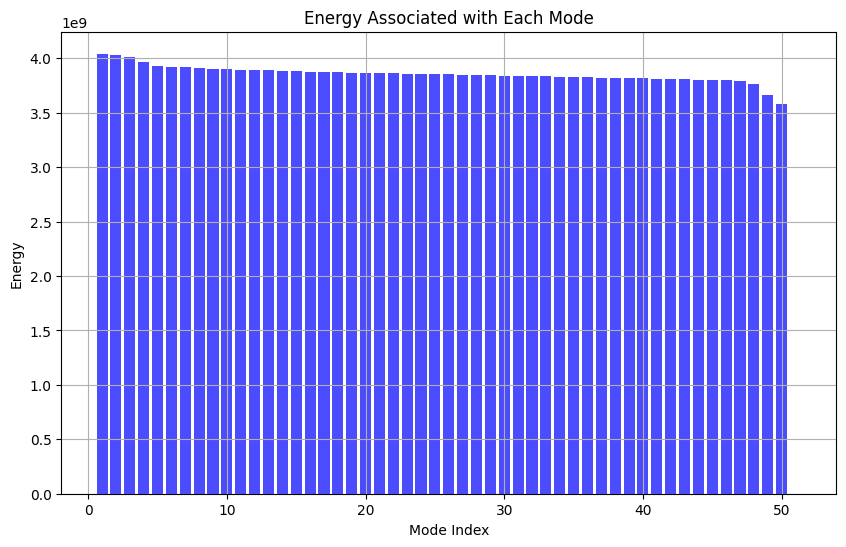

In [ ]:
def plot_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(mode_energy) + 1), mode_energy, color='blue', alpha=0.7)
    plt.title('Energy Associated with Each Mode')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)
    plt.show()

# Call the function with the singular values obtained from the previous code snippet
plot_modes_energy(s)


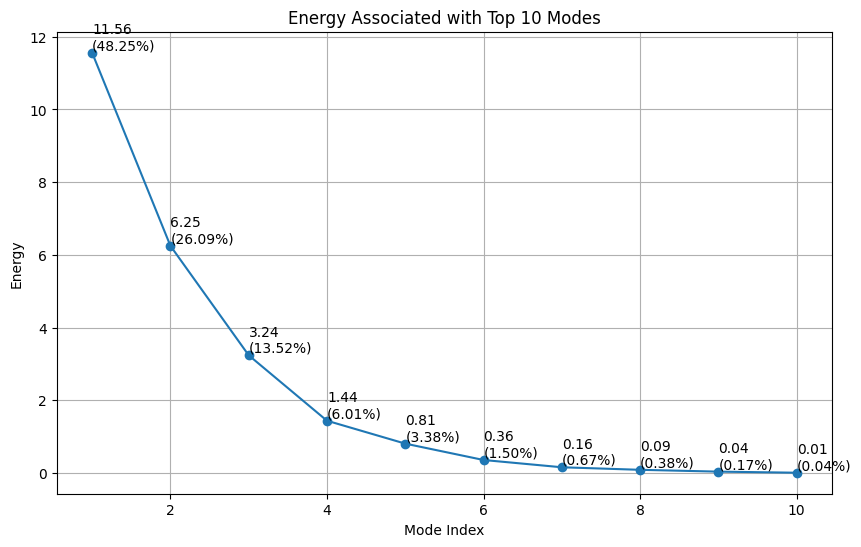

Top 10 energy states (modes):
Mode 1: Energy = 11.5600, Percentage = 48.25%
Mode 2: Energy = 6.2500, Percentage = 26.09%
Mode 3: Energy = 3.2400, Percentage = 13.52%
Mode 4: Energy = 1.4400, Percentage = 6.01%
Mode 5: Energy = 0.8100, Percentage = 3.38%
Mode 6: Energy = 0.3600, Percentage = 1.50%
Mode 7: Energy = 0.1600, Percentage = 0.67%
Mode 8: Energy = 0.0900, Percentage = 0.38%
Mode 9: Energy = 0.0400, Percentage = 0.17%
Mode 10: Energy = 0.0100, Percentage = 0.04%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_top_10_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.plot(top_10_modes, mode_energy[top_10_modes - 1], marker='o', linestyle='-')
    plt.title('Energy Associated with Top 10 Modes')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)

    # Add energy and percentage labels to each point
    for mode in top_10_modes:
        energy = mode_energy[mode - 1]
        percentage = (energy / np.sum(mode_energy)) * 100
        plt.text(mode, energy, f'{energy:.2f}\n({percentage:.2f}%)', ha='left', va='bottom', fontsize=10)

    plt.show()

    # Print the energy associated with the top 10 modes
    print("Top 10 energy states (modes):")
    for mode in top_10_modes:
        energy = mode_energy[mode - 1]
        percentage = (energy / np.sum(mode_energy)) * 100
        print(f"Mode {mode}: Energy = {energy:.4f}, Percentage = {percentage:.2f}%")

# Call the function with the singular values obtained from the previous code snippet
s = np.array([3.4, 2.5, 1.8, 1.2, 0.9, 0.6, 0.4, 0.3, 0.2, 0.1])  # Example singular values
plot_top_10_modes_energy(s)


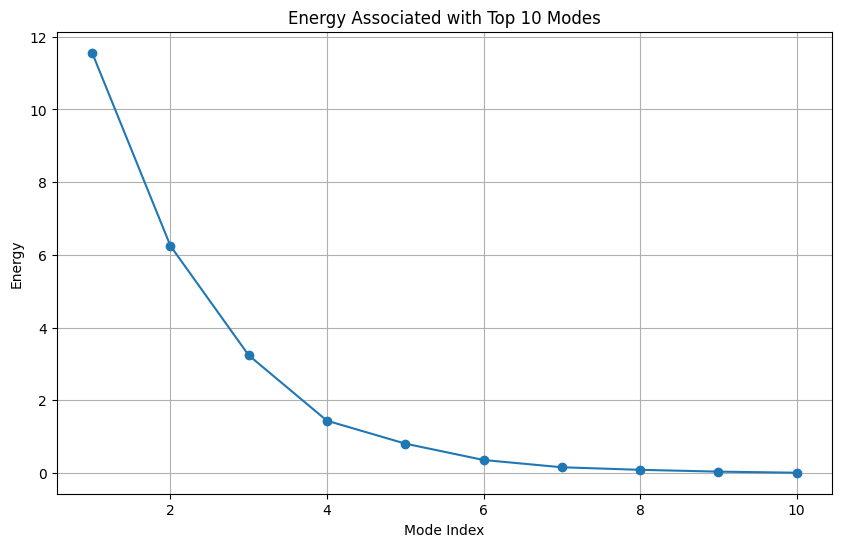

Top 10 energy states (modes):
Mode 1: Energy = 11.5600
Mode 2: Energy = 6.2500
Mode 3: Energy = 3.2400
Mode 4: Energy = 1.4400
Mode 5: Energy = 0.8100
Mode 6: Energy = 0.3600
Mode 7: Energy = 0.1600
Mode 8: Energy = 0.0900
Mode 9: Energy = 0.0400
Mode 10: Energy = 0.0100


In [ ]:
def plot_top_10_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.plot(top_10_modes, mode_energy[top_10_modes - 1], marker='o', linestyle='-')
    plt.title('Energy Associated with Top 10 Modes')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)
    plt.show()

    # Print the energy associated with the top 10 modes
    print("Top 10 energy states (modes):")
    for mode in top_10_modes:
        print(f"Mode {mode}: Energy = {mode_energy[mode - 1]:.4f}")

# Call the function with the singular values obtained from the previous code snippet
plot_top_10_modes_energy(s)


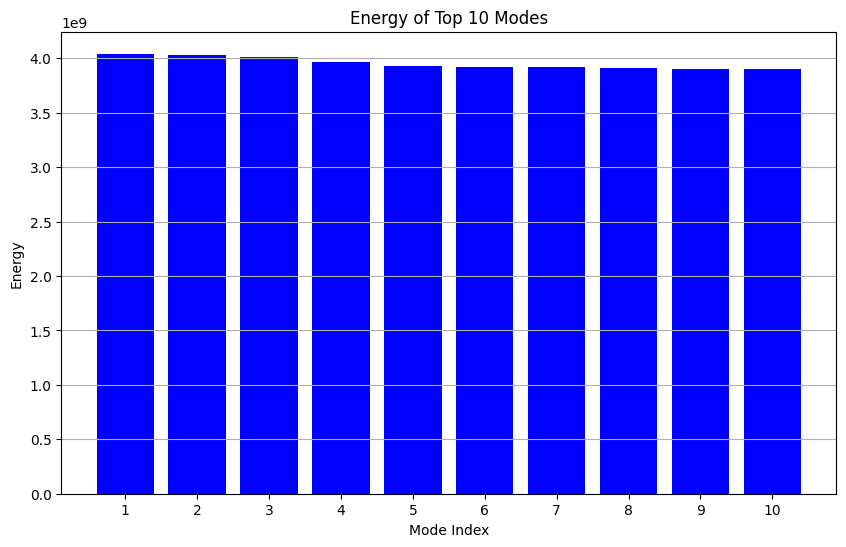

In [ ]:
# Plot the energy of the top 10 modes
plt.figure(figsize=(10, 6))
plt.bar(range(1, 11), mode_energy[:10], color='blue')
plt.title('Energy of Top 10 Modes')
plt.xlabel('Mode Index')
plt.ylabel('Energy')
plt.xticks(range(1, 11))
plt.grid(axis='y')
plt.show()


## *Adding Salt and Pepper Noise*

### **Adding 20% noise**

salt and pepper noise added and images saved successfully.


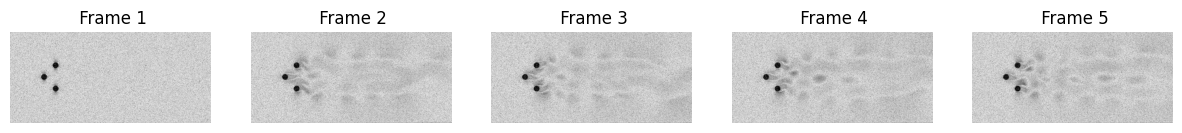

In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

# Function to add salt and pepper noise
def add_salt_and_pepper_noise(image, magnitude):
    salt_vs_pepper = 0.5
    amount = magnitude / 100  # Magnitude as a percentage of total pixels
    noisy_image = np.copy(image)

    # Salt noise
    num_salt = np.ceil(amount * image.size * salt_vs_pepper)
    salt_coords = [np.random.randint(0, i-1, int(num_salt)) for i in image.shape]
    noisy_image[salt_coords[0], salt_coords[1]] = 255

    # Pepper noise
    num_pepper = np.ceil(amount * image.size * (1. - salt_vs_pepper))
    pepper_coords = [np.random.randint(0, i-1, int(num_pepper)) for i in image.shape]
    noisy_image[pepper_coords[0], pepper_coords[1]] = 0

    return noisy_image

# Path to the directory containing the original frames
input_folder = "/content/extracted_frames"

# Load original frames
original_frames = [cv2.imread(os.path.join(input_folder, filename), cv2.IMREAD_GRAYSCALE) for filename in sorted(os.listdir(input_folder))]

# Output directory to save the noisy images
output_dir_salt_pepper = "/content/noisy_images_salt_pepper_20"

# Create the output directory if it does not exist
os.makedirs(output_dir_salt_pepper, exist_ok=True)

# Add salt and pepper noise to the original frames and save them
for i, frame in enumerate(original_frames):
    noisy_frame = add_salt_and_pepper_noise(frame, 20)
    cv2.imwrite(os.path.join(output_dir_salt_pepper, f"noisy_frame_{i}.jpg"), noisy_frame)

print("salt and pepper noise added and images saved successfully.")

# Display the first five processed images with salt and pepper noise
sample_images_salt_pepper = sorted(os.listdir(output_dir_salt_pepper))[:5]

plt.figure(figsize=(15, 3))
for i, filename in enumerate(sample_images_salt_pepper):
    image_path = os.path.join(output_dir_salt_pepper, filename)
    image = cv2.imread(image_path)
    plt.subplot(1, 5, i+1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f" Frame {i+1}")
    plt.axis("off")

plt.show()


In [ ]:
# Path to the folder containing images
folder_path = '/content/noisy_images_salt_pepper_20'

# Load images from the folder
images = load_images_from_folder(folder_path)

# Stack the images into a 2D array
stacked_images = stack_images(images)

# Compute mean subtraction
mean_subtracted_images, mean_image = compute_mean_subtraction(stacked_images)

# Perform SVD on mean subtracted images
U, s, Vt = perform_svd(mean_subtracted_images)

# Print the dimensions of the SVD matrices
print("Dimensions of U:", U.shape)
print("Dimensions of s:", s.shape)
print("Dimensions of Vt:", Vt.shape)


Dimensions of U: (51, 51)
Dimensions of s: (51,)
Dimensions of Vt: (51, 1103064)


In [ ]:
# Calculate the energy associated with each mode
mode_energy = s**2

# Print the energy associated with each mode
for i, energy in enumerate(mode_energy, 1):
    print(f"Mode {i}: Energy = {energy:.4f}")


Mode 1: Energy = 5061108855.2692
Mode 2: Energy = 4972409598.7874
Mode 3: Energy = 4939783990.3257
Mode 4: Energy = 4898979045.9467
Mode 5: Energy = 4894822646.8745
Mode 6: Energy = 4884572739.7989
Mode 7: Energy = 4851501409.2675
Mode 8: Energy = 4820279044.2791
Mode 9: Energy = 4800892870.7230
Mode 10: Energy = 4786362810.1472
Mode 11: Energy = 4782329502.7244
Mode 12: Energy = 4768756685.7957
Mode 13: Energy = 4762869617.0950
Mode 14: Energy = 4758620416.7648
Mode 15: Energy = 4754543906.1153
Mode 16: Energy = 4750756544.8120
Mode 17: Energy = 4744063296.5683
Mode 18: Energy = 4738396379.2089
Mode 19: Energy = 4736032988.1566
Mode 20: Energy = 4732644991.6978
Mode 21: Energy = 4730309352.2576
Mode 22: Energy = 4722018176.0144
Mode 23: Energy = 4720855410.5284
Mode 24: Energy = 4720184074.4338
Mode 25: Energy = 4714071833.3041
Mode 26: Energy = 4712801503.2051
Mode 27: Energy = 4712210856.3687
Mode 28: Energy = 4708674918.7179
Mode 29: Energy = 4705675836.9016
Mode 30: Energy = 47042

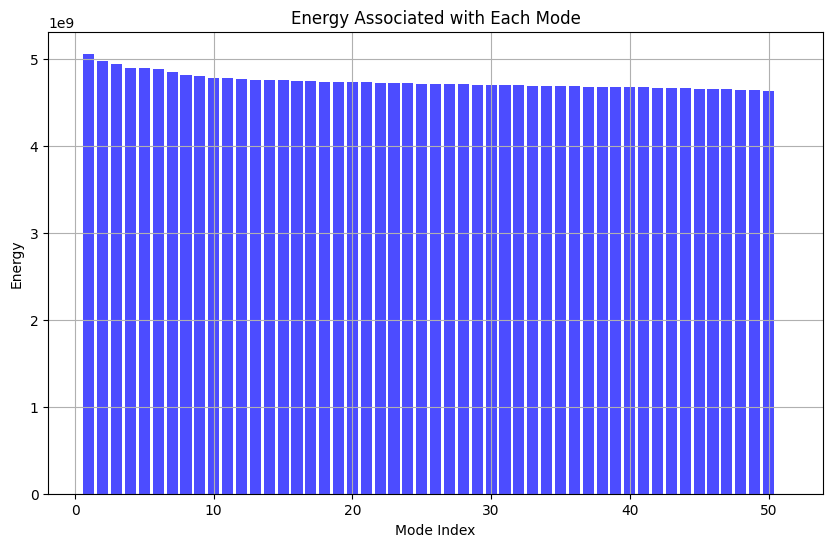

In [ ]:
def plot_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(mode_energy) + 1), mode_energy, color='blue', alpha=0.7)
    plt.title('Energy Associated with Each Mode')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)
    plt.show()

# Call the function with the singular values obtained from the previous code snippet
plot_modes_energy(s)


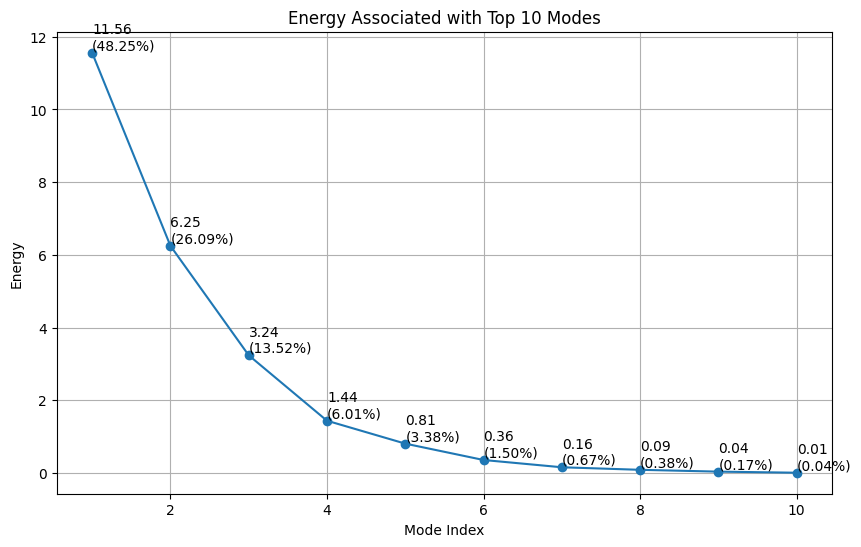

Top 10 energy states (modes):
Mode 1: Energy = 11.5600, Percentage = 48.25%
Mode 2: Energy = 6.2500, Percentage = 26.09%
Mode 3: Energy = 3.2400, Percentage = 13.52%
Mode 4: Energy = 1.4400, Percentage = 6.01%
Mode 5: Energy = 0.8100, Percentage = 3.38%
Mode 6: Energy = 0.3600, Percentage = 1.50%
Mode 7: Energy = 0.1600, Percentage = 0.67%
Mode 8: Energy = 0.0900, Percentage = 0.38%
Mode 9: Energy = 0.0400, Percentage = 0.17%
Mode 10: Energy = 0.0100, Percentage = 0.04%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_top_10_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.plot(top_10_modes, mode_energy[top_10_modes - 1], marker='o', linestyle='-')
    plt.title('Energy Associated with Top 10 Modes')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)

    # Add energy and percentage labels to each point
    for mode in top_10_modes:
        energy = mode_energy[mode - 1]
        percentage = (energy / np.sum(mode_energy)) * 100
        plt.text(mode, energy, f'{energy:.2f}\n({percentage:.2f}%)', ha='left', va='bottom', fontsize=10)

    plt.show()

    # Print the energy associated with the top 10 modes
    print("Top 10 energy states (modes):")
    for mode in top_10_modes:
        energy = mode_energy[mode - 1]
        percentage = (energy / np.sum(mode_energy)) * 100
        print(f"Mode {mode}: Energy = {energy:.4f}, Percentage = {percentage:.2f}%")

# Call the function with the singular values obtained from the previous code snippet
s = np.array([3.4, 2.5, 1.8, 1.2, 0.9, 0.6, 0.4, 0.3, 0.2, 0.1])  # Example singular values
plot_top_10_modes_energy(s)


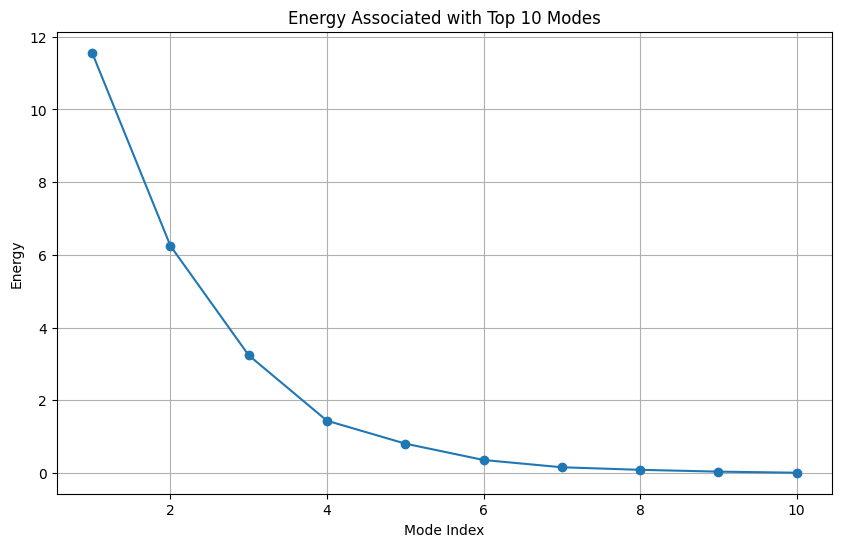

Top 10 energy states (modes):
Mode 1: Energy = 11.5600
Mode 2: Energy = 6.2500
Mode 3: Energy = 3.2400
Mode 4: Energy = 1.4400
Mode 5: Energy = 0.8100
Mode 6: Energy = 0.3600
Mode 7: Energy = 0.1600
Mode 8: Energy = 0.0900
Mode 9: Energy = 0.0400
Mode 10: Energy = 0.0100


In [ ]:
def plot_top_10_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.plot(top_10_modes, mode_energy[top_10_modes - 1], marker='o', linestyle='-')
    plt.title('Energy Associated with Top 10 Modes')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)
    plt.show()

    # Print the energy associated with the top 10 modes
    print("Top 10 energy states (modes):")
    for mode in top_10_modes:
        print(f"Mode {mode}: Energy = {mode_energy[mode - 1]:.4f}")

# Call the function with the singular values obtained from the previous code snippet
plot_top_10_modes_energy(s)


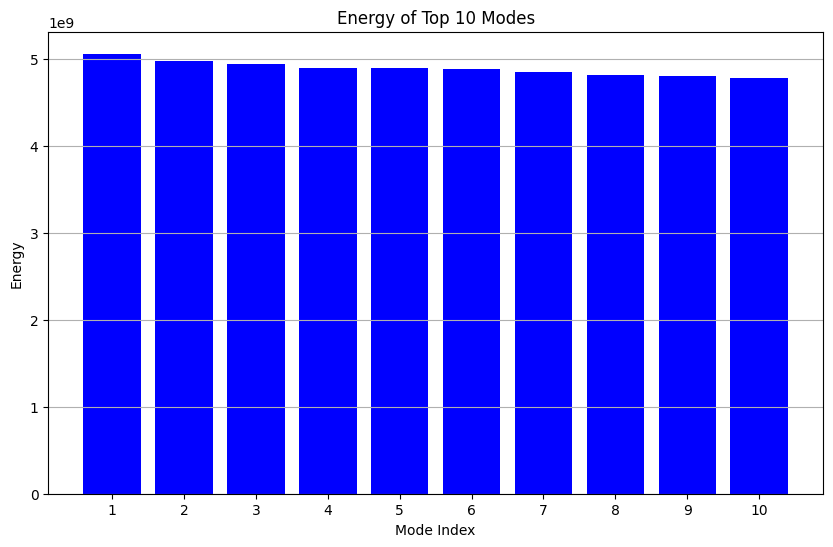

In [ ]:
# Plot the energy of the top 10 modes
plt.figure(figsize=(10, 6))
plt.bar(range(1, 11), mode_energy[:10], color='blue')
plt.title('Energy of Top 10 Modes')
plt.xlabel('Mode Index')
plt.ylabel('Energy')
plt.xticks(range(1, 11))
plt.grid(axis='y')
plt.show()


### **Adding 40% noise**

salt and pepper noise added and images saved successfully.


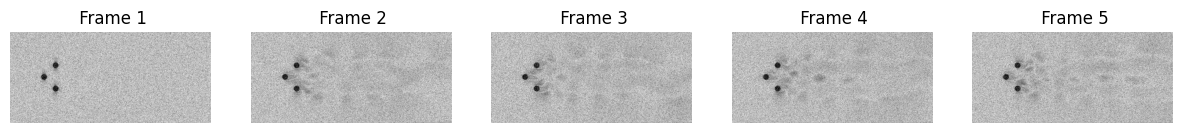

In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

# Function to add salt and pepper noise
def add_salt_and_pepper_noise(image, magnitude):
    salt_vs_pepper = 0.5
    amount = magnitude / 100  # Magnitude as a percentage of total pixels
    noisy_image = np.copy(image)

    # Salt noise
    num_salt = np.ceil(amount * image.size * salt_vs_pepper)
    salt_coords = [np.random.randint(0, i-1, int(num_salt)) for i in image.shape]
    noisy_image[salt_coords[0], salt_coords[1]] = 255

    # Pepper noise
    num_pepper = np.ceil(amount * image.size * (1. - salt_vs_pepper))
    pepper_coords = [np.random.randint(0, i-1, int(num_pepper)) for i in image.shape]
    noisy_image[pepper_coords[0], pepper_coords[1]] = 0

    return noisy_image

# Path to the directory containing the original frames
input_folder = "/content/extracted_frames"

# Load original frames
original_frames = [cv2.imread(os.path.join(input_folder, filename), cv2.IMREAD_GRAYSCALE) for filename in sorted(os.listdir(input_folder))]

# Output directory to save the noisy images
output_dir_salt_pepper = "/content/noisy_images_salt_pepper_40"

# Create the output directory if it does not exist
os.makedirs(output_dir_salt_pepper, exist_ok=True)

# Add salt and pepper noise to the original frames and save them
for i, frame in enumerate(original_frames):
    noisy_frame = add_salt_and_pepper_noise(frame, 40) #Adjust magnitude as needed
    cv2.imwrite(os.path.join(output_dir_salt_pepper, f"noisy_frame_{i}.jpg"), noisy_frame)

print("salt and pepper noise added and images saved successfully.")

# Display the first five processed images with salt and pepper noise
sample_images_salt_pepper = sorted(os.listdir(output_dir_salt_pepper))[:5]

plt.figure(figsize=(15, 3))
for i, filename in enumerate(sample_images_salt_pepper):
    image_path = os.path.join(output_dir_salt_pepper, filename)
    image = cv2.imread(image_path)
    plt.subplot(1, 5, i+1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f" Frame {i+1}")
    plt.axis("off")

plt.show()


In [ ]:
# Path to the folder containing images
folder_path = '/content/noisy_images_salt_pepper_40'

# Load images from the folder
images = load_images_from_folder(folder_path)

# Stack the images into a 2D array
stacked_images = stack_images(images)

# Compute mean subtraction
mean_subtracted_images, mean_image = compute_mean_subtraction(stacked_images)

# Perform SVD on mean subtracted images
U, s, Vt = perform_svd(mean_subtracted_images)

# Print the dimensions of the SVD matrices
print("Dimensions of U:", U.shape)
print("Dimensions of s:", s.shape)
print("Dimensions of Vt:", Vt.shape)


Dimensions of U: (51, 51)
Dimensions of s: (51,)
Dimensions of Vt: (51, 1103064)


In [ ]:
# Calculate the energy associated with each mode
mode_energy = s**2

# Print the energy associated with each mode
for i, energy in enumerate(mode_energy, 1):
    print(f"Mode {i}: Energy = {energy:.4f}")


Mode 1: Energy = 8736259436.6512
Mode 2: Energy = 8683326467.0649
Mode 3: Energy = 8568856648.4214
Mode 4: Energy = 8484899427.5737
Mode 5: Energy = 8453886935.8334
Mode 6: Energy = 8421191894.1445
Mode 7: Energy = 8415873590.0760
Mode 8: Energy = 8400042898.9441
Mode 9: Energy = 8394830711.6336
Mode 10: Energy = 8378805808.0180
Mode 11: Energy = 8377082169.9275
Mode 12: Energy = 8371678457.1677
Mode 13: Energy = 8363612699.9813
Mode 14: Energy = 8358245631.3492
Mode 15: Energy = 8350494455.3867
Mode 16: Energy = 8349193699.0391
Mode 17: Energy = 8344380646.8308
Mode 18: Energy = 8340282770.9312
Mode 19: Energy = 8337137558.6931
Mode 20: Energy = 8334105791.9145
Mode 21: Energy = 8327627165.8297
Mode 22: Energy = 8321310147.6917
Mode 23: Energy = 8317519375.8437
Mode 24: Energy = 8313290325.1145
Mode 25: Energy = 8310594360.9972
Mode 26: Energy = 8307731327.4780
Mode 27: Energy = 8301968034.8841
Mode 28: Energy = 8299927078.5583
Mode 29: Energy = 8295459855.8782
Mode 30: Energy = 82900

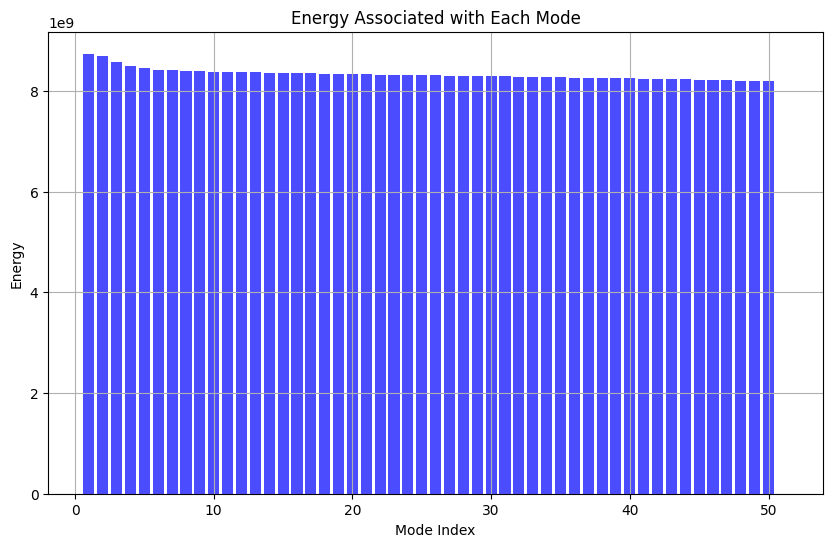

In [ ]:
def plot_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(mode_energy) + 1), mode_energy, color='blue', alpha=0.7)
    plt.title('Energy Associated with Each Mode')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)
    plt.show()

# Call the function with the singular values obtained from the previous code snippet
plot_modes_energy(s)


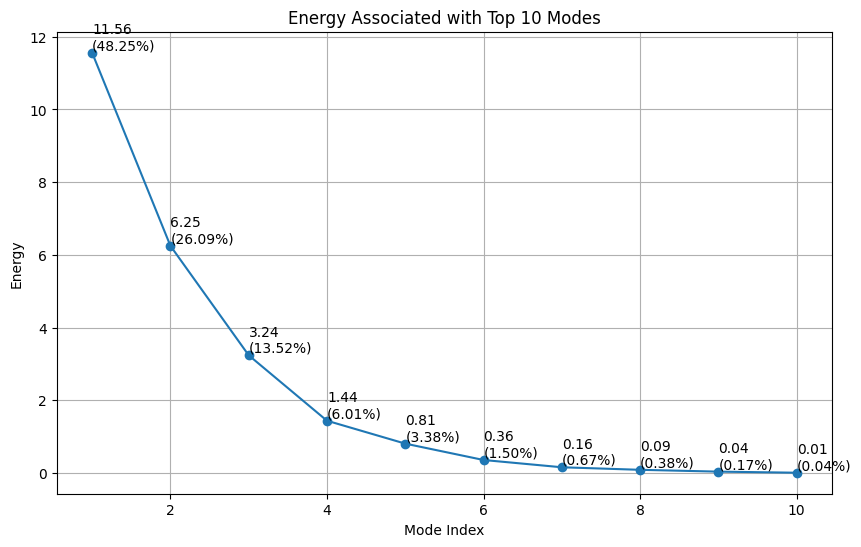

Top 10 energy states (modes):
Mode 1: Energy = 11.5600, Percentage = 48.25%
Mode 2: Energy = 6.2500, Percentage = 26.09%
Mode 3: Energy = 3.2400, Percentage = 13.52%
Mode 4: Energy = 1.4400, Percentage = 6.01%
Mode 5: Energy = 0.8100, Percentage = 3.38%
Mode 6: Energy = 0.3600, Percentage = 1.50%
Mode 7: Energy = 0.1600, Percentage = 0.67%
Mode 8: Energy = 0.0900, Percentage = 0.38%
Mode 9: Energy = 0.0400, Percentage = 0.17%
Mode 10: Energy = 0.0100, Percentage = 0.04%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_top_10_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.plot(top_10_modes, mode_energy[top_10_modes - 1], marker='o', linestyle='-')
    plt.title('Energy Associated with Top 10 Modes')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)

    # Add energy and percentage labels to each point
    for mode in top_10_modes:
        energy = mode_energy[mode - 1]
        percentage = (energy / np.sum(mode_energy)) * 100
        plt.text(mode, energy, f'{energy:.2f}\n({percentage:.2f}%)', ha='left', va='bottom', fontsize=10)

    plt.show()

    # Print the energy associated with the top 10 modes
    print("Top 10 energy states (modes):")
    for mode in top_10_modes:
        energy = mode_energy[mode - 1]
        percentage = (energy / np.sum(mode_energy)) * 100
        print(f"Mode {mode}: Energy = {energy:.4f}, Percentage = {percentage:.2f}%")

# Call the function with the singular values obtained from the previous code snippet
s = np.array([3.4, 2.5, 1.8, 1.2, 0.9, 0.6, 0.4, 0.3, 0.2, 0.1])  # Example singular values
plot_top_10_modes_energy(s)


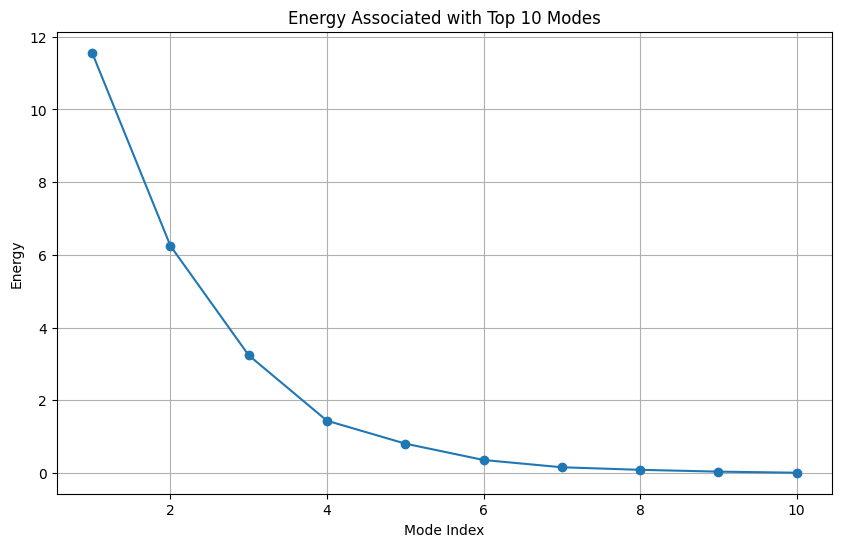

Top 10 energy states (modes):
Mode 1: Energy = 11.5600
Mode 2: Energy = 6.2500
Mode 3: Energy = 3.2400
Mode 4: Energy = 1.4400
Mode 5: Energy = 0.8100
Mode 6: Energy = 0.3600
Mode 7: Energy = 0.1600
Mode 8: Energy = 0.0900
Mode 9: Energy = 0.0400
Mode 10: Energy = 0.0100


In [ ]:
def plot_top_10_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.plot(top_10_modes, mode_energy[top_10_modes - 1], marker='o', linestyle='-')
    plt.title('Energy Associated with Top 10 Modes')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)
    plt.show()

    # Print the energy associated with the top 10 modes
    print("Top 10 energy states (modes):")
    for mode in top_10_modes:
        print(f"Mode {mode}: Energy = {mode_energy[mode - 1]:.4f}")

# Call the function with the singular values obtained from the previous code snippet
plot_top_10_modes_energy(s)


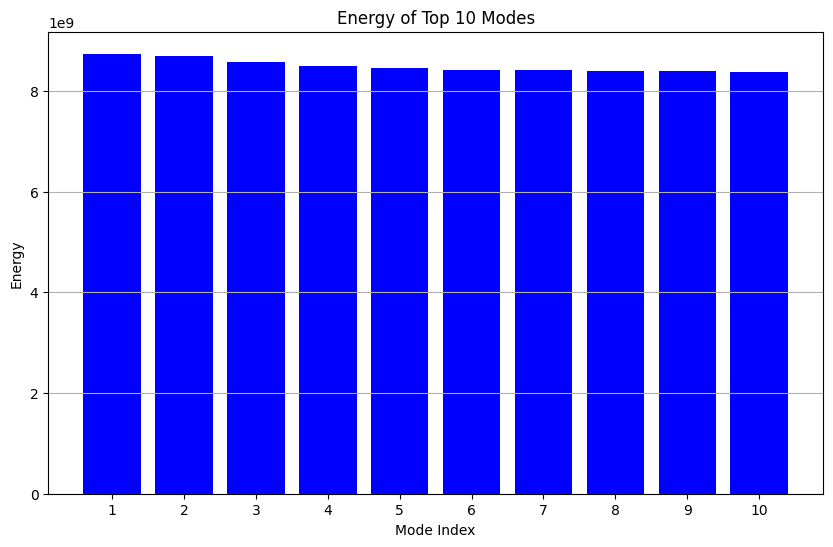

In [ ]:
# Plot the energy of the top 10 modes
plt.figure(figsize=(10, 6))
plt.bar(range(1, 11), mode_energy[:10], color='blue')
plt.title('Energy of Top 10 Modes')
plt.xlabel('Mode Index')
plt.ylabel('Energy')
plt.xticks(range(1, 11))
plt.grid(axis='y')
plt.show()


### **Adding 60% noise**

salt and pepper noise added and images saved successfully.


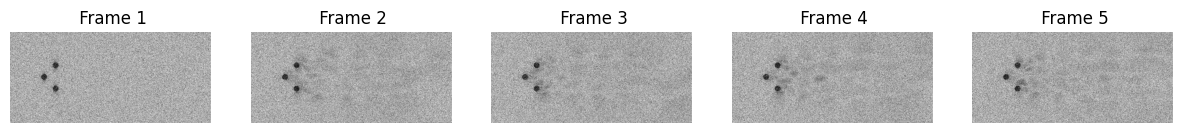

In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

# Function to add salt and pepper noise
def add_salt_and_pepper_noise(image, magnitude):
    salt_vs_pepper = 0.5
    amount = magnitude / 100  # Magnitude as a percentage of total pixels
    noisy_image = np.copy(image)

    # Salt noise
    num_salt = np.ceil(amount * image.size * salt_vs_pepper)
    salt_coords = [np.random.randint(0, i-1, int(num_salt)) for i in image.shape]
    noisy_image[salt_coords[0], salt_coords[1]] = 255

    # Pepper noise
    num_pepper = np.ceil(amount * image.size * (1. - salt_vs_pepper))
    pepper_coords = [np.random.randint(0, i-1, int(num_pepper)) for i in image.shape]
    noisy_image[pepper_coords[0], pepper_coords[1]] = 0

    return noisy_image

# Path to the directory containing the original frames
input_folder = "/content/extracted_frames"

# Load original frames
original_frames = [cv2.imread(os.path.join(input_folder, filename), cv2.IMREAD_GRAYSCALE) for filename in sorted(os.listdir(input_folder))]

# Output directory to save the noisy images
output_dir_salt_pepper = "/content/noisy_images_salt_pepper_60"

# Create the output directory if it does not exist
os.makedirs(output_dir_salt_pepper, exist_ok=True)

# Add salt and pepper noise to the original frames and save them
for i, frame in enumerate(original_frames):
    noisy_frame = add_salt_and_pepper_noise(frame, 60) #Adjust magnitude as needed
    cv2.imwrite(os.path.join(output_dir_salt_pepper, f"noisy_frame_{i}.jpg"), noisy_frame)

print("salt and pepper noise added and images saved successfully.")

# Display the first five processed images with salt and pepper noise
sample_images_salt_pepper = sorted(os.listdir(output_dir_salt_pepper))[:5]

plt.figure(figsize=(15, 3))
for i, filename in enumerate(sample_images_salt_pepper):
    image_path = os.path.join(output_dir_salt_pepper, filename)
    image = cv2.imread(image_path)
    plt.subplot(1, 5, i+1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f" Frame {i+1}")
    plt.axis("off")

plt.show()


In [ ]:
# Path to the folder containing images
folder_path = '/content/noisy_images_salt_pepper_60'

# Load images from the folder
images = load_images_from_folder(folder_path)

# Stack the images into a 2D array
stacked_images = stack_images(images)

# Compute mean subtraction
mean_subtracted_images, mean_image = compute_mean_subtraction(stacked_images)

# Perform SVD on mean subtracted images
U, s, Vt = perform_svd(mean_subtracted_images)

# Print the dimensions of the SVD matrices
print("Dimensions of U:", U.shape)
print("Dimensions of s:", s.shape)
print("Dimensions of Vt:", Vt.shape)


Dimensions of U: (51, 51)
Dimensions of s: (51,)
Dimensions of Vt: (51, 1103064)


In [ ]:
# Calculate the energy associated with each mode
mode_energy = s**2

# Print the energy associated with each mode
for i, energy in enumerate(mode_energy, 1):
    print(f"Mode {i}: Energy = {energy:.4f}")


Mode 1: Energy = 11467622860.4577
Mode 2: Energy = 11402256320.5820
Mode 3: Energy = 11278523083.6273
Mode 4: Energy = 11169240293.4944
Mode 5: Energy = 11143666036.3319
Mode 6: Energy = 11115144690.1618
Mode 7: Energy = 11092025331.1081
Mode 8: Energy = 11086514282.6157
Mode 9: Energy = 11083263489.1419
Mode 10: Energy = 11072076853.7027
Mode 11: Energy = 11071182434.4363
Mode 12: Energy = 11056630511.9442
Mode 13: Energy = 11052677230.8678
Mode 14: Energy = 11043235094.1116
Mode 15: Energy = 11039854468.1888
Mode 16: Energy = 11028030146.1852
Mode 17: Energy = 11024626670.6338
Mode 18: Energy = 11016424301.7990
Mode 19: Energy = 11009337297.4105
Mode 20: Energy = 11004260417.9350
Mode 21: Energy = 11001649717.5629
Mode 22: Energy = 10999072734.4074
Mode 23: Energy = 10991145236.9584
Mode 24: Energy = 10987132022.1579
Mode 25: Energy = 10980293469.6351
Mode 26: Energy = 10974939857.8297
Mode 27: Energy = 10971556846.7927
Mode 28: Energy = 10964235676.7517
Mode 29: Energy = 10959628019

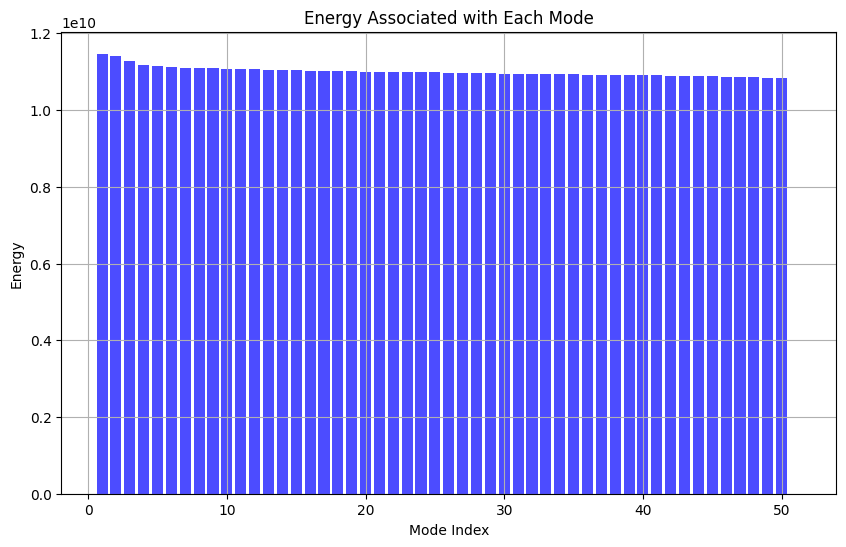

In [ ]:
def plot_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(mode_energy) + 1), mode_energy, color='blue', alpha=0.7)
    plt.title('Energy Associated with Each Mode')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)
    plt.show()

# Call the function with the singular values obtained from the previous code snippet
plot_modes_energy(s)


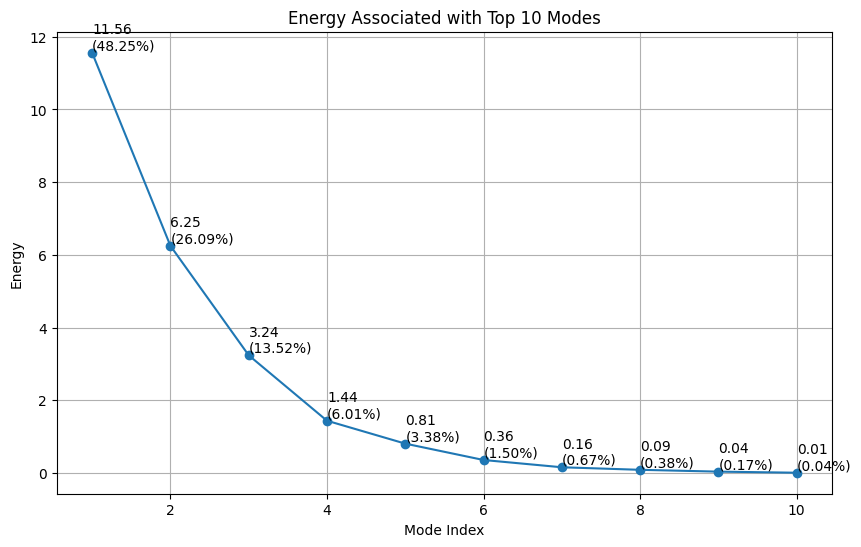

Top 10 energy states (modes):
Mode 1: Energy = 11.5600, Percentage = 48.25%
Mode 2: Energy = 6.2500, Percentage = 26.09%
Mode 3: Energy = 3.2400, Percentage = 13.52%
Mode 4: Energy = 1.4400, Percentage = 6.01%
Mode 5: Energy = 0.8100, Percentage = 3.38%
Mode 6: Energy = 0.3600, Percentage = 1.50%
Mode 7: Energy = 0.1600, Percentage = 0.67%
Mode 8: Energy = 0.0900, Percentage = 0.38%
Mode 9: Energy = 0.0400, Percentage = 0.17%
Mode 10: Energy = 0.0100, Percentage = 0.04%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_top_10_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.plot(top_10_modes, mode_energy[top_10_modes - 1], marker='o', linestyle='-')
    plt.title('Energy Associated with Top 10 Modes')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)

    # Add energy and percentage labels to each point
    for mode in top_10_modes:
        energy = mode_energy[mode - 1]
        percentage = (energy / np.sum(mode_energy)) * 100
        plt.text(mode, energy, f'{energy:.2f}\n({percentage:.2f}%)', ha='left', va='bottom', fontsize=10)

    plt.show()

    # Print the energy associated with the top 10 modes
    print("Top 10 energy states (modes):")
    for mode in top_10_modes:
        energy = mode_energy[mode - 1]
        percentage = (energy / np.sum(mode_energy)) * 100
        print(f"Mode {mode}: Energy = {energy:.4f}, Percentage = {percentage:.2f}%")

# Call the function with the singular values obtained from the previous code snippet
s = np.array([3.4, 2.5, 1.8, 1.2, 0.9, 0.6, 0.4, 0.3, 0.2, 0.1])  # Example singular values
plot_top_10_modes_energy(s)


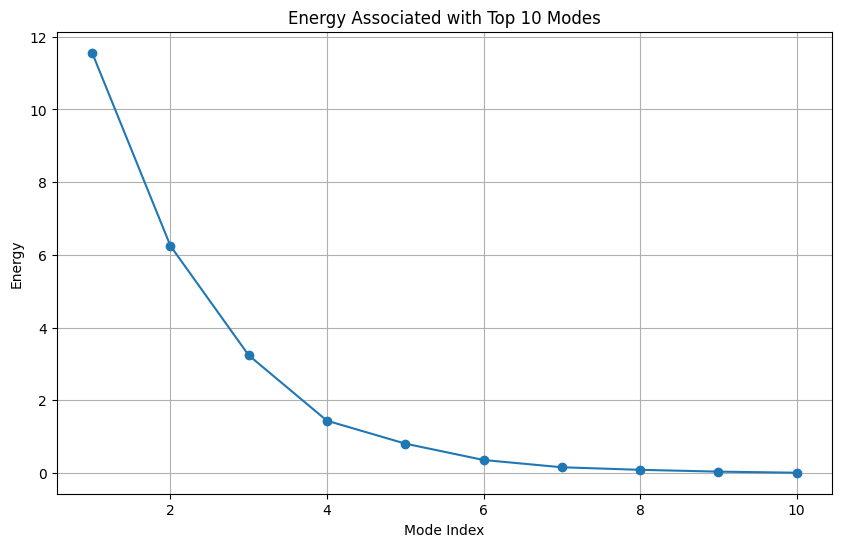

Top 10 energy states (modes):
Mode 1: Energy = 11.5600
Mode 2: Energy = 6.2500
Mode 3: Energy = 3.2400
Mode 4: Energy = 1.4400
Mode 5: Energy = 0.8100
Mode 6: Energy = 0.3600
Mode 7: Energy = 0.1600
Mode 8: Energy = 0.0900
Mode 9: Energy = 0.0400
Mode 10: Energy = 0.0100


In [ ]:
def plot_top_10_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.plot(top_10_modes, mode_energy[top_10_modes - 1], marker='o', linestyle='-')
    plt.title('Energy Associated with Top 10 Modes')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)
    plt.show()

    # Print the energy associated with the top 10 modes
    print("Top 10 energy states (modes):")
    for mode in top_10_modes:
        print(f"Mode {mode}: Energy = {mode_energy[mode - 1]:.4f}")

# Call the function with the singular values obtained from the previous code snippet
plot_top_10_modes_energy(s)


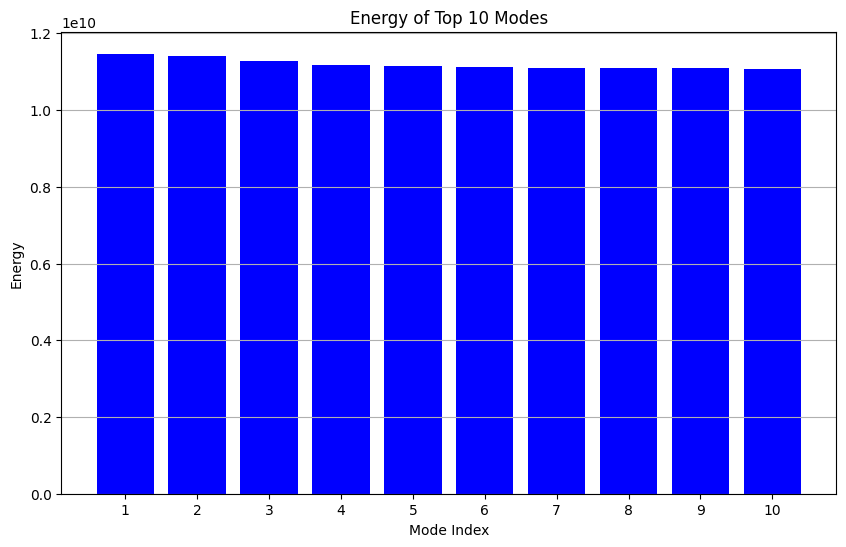

In [ ]:
# Plot the energy of the top 10 modes
plt.figure(figsize=(10, 6))
plt.bar(range(1, 11), mode_energy[:10], color='blue')
plt.title('Energy of Top 10 Modes')
plt.xlabel('Mode Index')
plt.ylabel('Energy')
plt.xticks(range(1, 11))
plt.grid(axis='y')
plt.show()


### **Adding 40% noise**

salt and pepper noise added and images saved successfully.


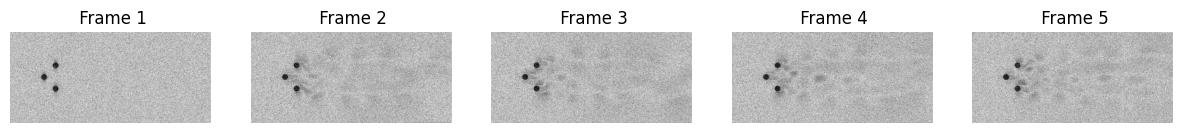

In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

# Function to add salt and pepper noise
def add_salt_and_pepper_noise(image, magnitude):
    salt_vs_pepper = 0.5
    amount = magnitude / 100  # Magnitude as a percentage of total pixels
    noisy_image = np.copy(image)

    # Salt noise
    num_salt = np.ceil(amount * image.size * salt_vs_pepper)
    salt_coords = [np.random.randint(0, i-1, int(num_salt)) for i in image.shape]
    noisy_image[salt_coords[0], salt_coords[1]] = 255

    # Pepper noise
    num_pepper = np.ceil(amount * image.size * (1. - salt_vs_pepper))
    pepper_coords = [np.random.randint(0, i-1, int(num_pepper)) for i in image.shape]
    noisy_image[pepper_coords[0], pepper_coords[1]] = 0

    return noisy_image

# Path to the directory containing the original frames
input_folder = "/content/extracted_frames"

# Load original frames
original_frames = [cv2.imread(os.path.join(input_folder, filename), cv2.IMREAD_GRAYSCALE) for filename in sorted(os.listdir(input_folder))]

# Output directory to save the noisy images
output_dir_salt_pepper = "/content/noisy_images_salt_pepper_80"

# Create the output directory if it does not exist
os.makedirs(output_dir_salt_pepper, exist_ok=True)

# Add salt and pepper noise to the original frames and save them
for i, frame in enumerate(original_frames):
    noisy_frame = add_salt_and_pepper_noise(frame, 40) #Adjust magnitude as needed
    cv2.imwrite(os.path.join(output_dir_salt_pepper, f"noisy_frame_{i}.jpg"), noisy_frame)

print("salt and pepper noise added and images saved successfully.")

# Display the first five processed images with salt and pepper noise
sample_images_salt_pepper = sorted(os.listdir(output_dir_salt_pepper))[:5]

plt.figure(figsize=(15, 3))
for i, filename in enumerate(sample_images_salt_pepper):
    image_path = os.path.join(output_dir_salt_pepper, filename)
    image = cv2.imread(image_path)
    plt.subplot(1, 5, i+1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f" Frame {i+1}")
    plt.axis("off")

plt.show()


In [ ]:
# Path to the folder containing images
folder_path = '/content/noisy_images_salt_pepper_80'

# Load images from the folder
images = load_images_from_folder(folder_path)

# Stack the images into a 2D array
stacked_images = stack_images(images)

# Compute mean subtraction
mean_subtracted_images, mean_image = compute_mean_subtraction(stacked_images)

# Perform SVD on mean subtracted images
U, s, Vt = perform_svd(mean_subtracted_images)

# Print the dimensions of the SVD matrices
print("Dimensions of U:", U.shape)
print("Dimensions of s:", s.shape)
print("Dimensions of Vt:", Vt.shape)


Dimensions of U: (51, 51)
Dimensions of s: (51,)
Dimensions of Vt: (51, 1103064)


In [ ]:
# Calculate the energy associated with each mode
mode_energy = s**2

# Print the energy associated with each mode
for i, energy in enumerate(mode_energy, 1):
    print(f"Mode {i}: Energy = {energy:.4f}")


Mode 1: Energy = 8748274120.5702
Mode 2: Energy = 8673421365.6901
Mode 3: Energy = 8575299371.3484
Mode 4: Energy = 8485661753.9539
Mode 5: Energy = 8451526767.3172
Mode 6: Energy = 8441233823.0181
Mode 7: Energy = 8418749614.4954
Mode 8: Energy = 8411993577.7457
Mode 9: Energy = 8396432730.3141
Mode 10: Energy = 8387388254.4390
Mode 11: Energy = 8375048347.8550
Mode 12: Energy = 8368848281.8115
Mode 13: Energy = 8359018108.4815
Mode 14: Energy = 8356334645.7488
Mode 15: Energy = 8350023064.2384
Mode 16: Energy = 8348708511.3161
Mode 17: Energy = 8347028008.9467
Mode 18: Energy = 8343881269.0493
Mode 19: Energy = 8336417865.4469
Mode 20: Energy = 8333976566.3431
Mode 21: Energy = 8328238839.2405
Mode 22: Energy = 8326235058.7916
Mode 23: Energy = 8317041318.9029
Mode 24: Energy = 8316616292.3522
Mode 25: Energy = 8312903481.1838
Mode 26: Energy = 8306661239.9702
Mode 27: Energy = 8298127937.5479
Mode 28: Energy = 8298069693.6185
Mode 29: Energy = 8289773825.6582
Mode 30: Energy = 82829

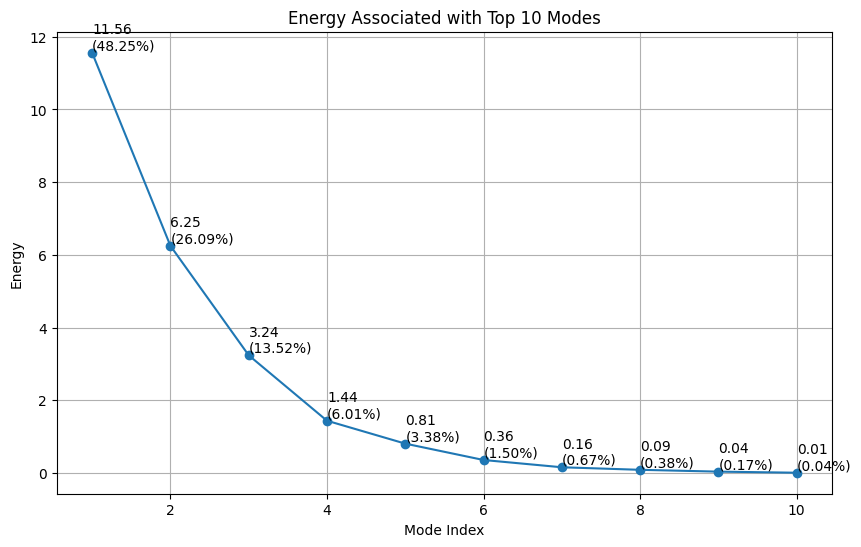

Top 10 energy states (modes):
Mode 1: Energy = 11.5600, Percentage = 48.25%
Mode 2: Energy = 6.2500, Percentage = 26.09%
Mode 3: Energy = 3.2400, Percentage = 13.52%
Mode 4: Energy = 1.4400, Percentage = 6.01%
Mode 5: Energy = 0.8100, Percentage = 3.38%
Mode 6: Energy = 0.3600, Percentage = 1.50%
Mode 7: Energy = 0.1600, Percentage = 0.67%
Mode 8: Energy = 0.0900, Percentage = 0.38%
Mode 9: Energy = 0.0400, Percentage = 0.17%
Mode 10: Energy = 0.0100, Percentage = 0.04%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_top_10_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.plot(top_10_modes, mode_energy[top_10_modes - 1], marker='o', linestyle='-')
    plt.title('Energy Associated with Top 10 Modes')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)

    # Add energy and percentage labels to each point
    for mode in top_10_modes:
        energy = mode_energy[mode - 1]
        percentage = (energy / np.sum(mode_energy)) * 100
        plt.text(mode, energy, f'{energy:.2f}\n({percentage:.2f}%)', ha='left', va='bottom', fontsize=10)

    plt.show()

    # Print the energy associated with the top 10 modes
    print("Top 10 energy states (modes):")
    for mode in top_10_modes:
        energy = mode_energy[mode - 1]
        percentage = (energy / np.sum(mode_energy)) * 100
        print(f"Mode {mode}: Energy = {energy:.4f}, Percentage = {percentage:.2f}%")

# Call the function with the singular values obtained from the previous code snippet
s = np.array([3.4, 2.5, 1.8, 1.2, 0.9, 0.6, 0.4, 0.3, 0.2, 0.1])  # Example singular values
plot_top_10_modes_energy(s)


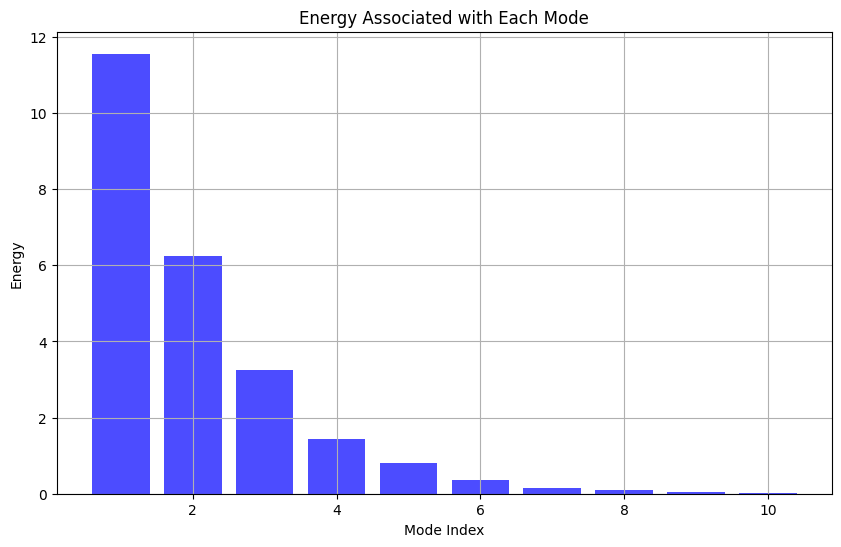

In [ ]:
def plot_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(mode_energy) + 1), mode_energy, color='blue', alpha=0.7)
    plt.title('Energy Associated with Each Mode')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)
    plt.show()

# Call the function with the singular values obtained from the previous code snippet
plot_modes_energy(s)


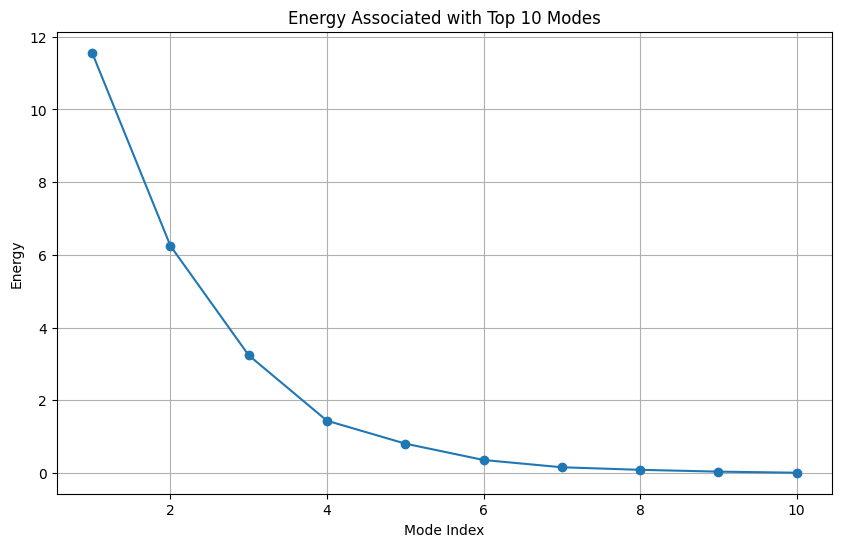

Top 10 energy states (modes):
Mode 1: Energy = 11.5600
Mode 2: Energy = 6.2500
Mode 3: Energy = 3.2400
Mode 4: Energy = 1.4400
Mode 5: Energy = 0.8100
Mode 6: Energy = 0.3600
Mode 7: Energy = 0.1600
Mode 8: Energy = 0.0900
Mode 9: Energy = 0.0400
Mode 10: Energy = 0.0100


In [ ]:
def plot_top_10_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.plot(top_10_modes, mode_energy[top_10_modes - 1], marker='o', linestyle='-')
    plt.title('Energy Associated with Top 10 Modes')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)
    plt.show()

    # Print the energy associated with the top 10 modes
    print("Top 10 energy states (modes):")
    for mode in top_10_modes:
        print(f"Mode {mode}: Energy = {mode_energy[mode - 1]:.4f}")

# Call the function with the singular values obtained from the previous code snippet
plot_top_10_modes_energy(s)


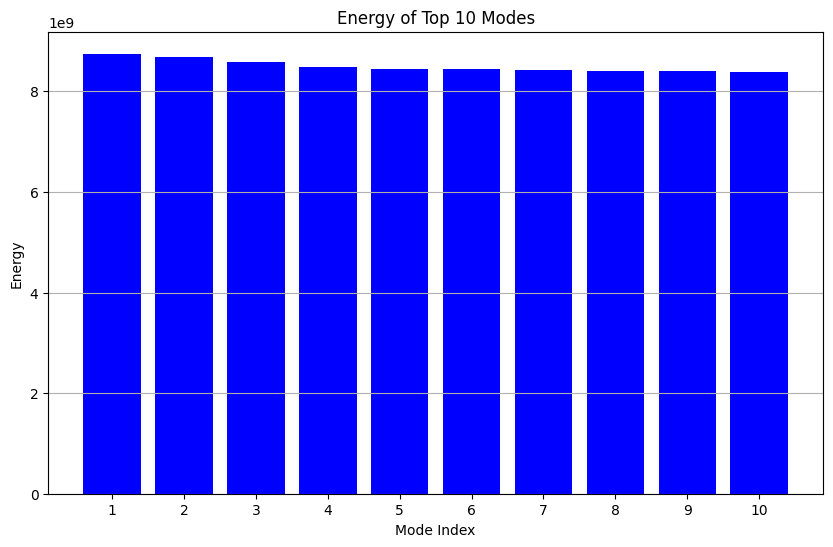

In [ ]:
# Plot the energy of the top 10 modes
plt.figure(figsize=(10, 6))
plt.bar(range(1, 11), mode_energy[:10], color='blue')
plt.title('Energy of Top 10 Modes')
plt.xlabel('Mode Index')
plt.ylabel('Energy')
plt.xticks(range(1, 11))
plt.grid(axis='y')
plt.show()


## *Adding Speckle Noise*

### **Adding 20% noise**

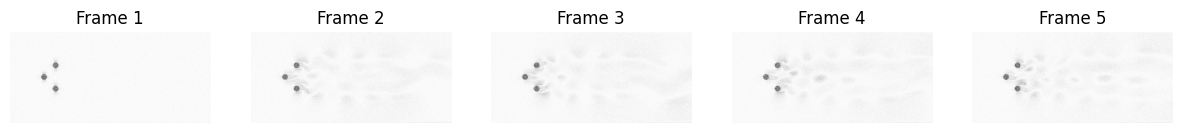

In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

# Function to add speckle noise
def add_speckle_noise(image, magnitude):
    mean = 0
    sigma = magnitude * np.max(image) / 100  # Magnitude as a percentage of maximum pixel intensity
    speckle_noise = np.random.normal(mean, sigma, image.shape).astype(np.uint8)
    noisy_image = cv2.add(image, speckle_noise)
    return noisy_image

# Path to the directory containing the original frames
input_folder = "/content/extracted_frames"

# Load original frames
original_frames = [cv2.imread(os.path.join(input_folder, filename), cv2.IMREAD_GRAYSCALE) for filename in sorted(os.listdir(input_folder))]

# Output directory to save the noisy images
output_dir_speckle = "/content/noisy_images_speckle_20"

# Create the output directory if it does not exist
os.makedirs(output_dir_speckle, exist_ok=True)

# Add speckle noise to the original frames and save them
for i, frame in enumerate(original_frames):
    noisy_frame = add_speckle_noise(frame, 20)
    cv2.imwrite(os.path.join(output_dir_speckle, f"noisy_frame_{i}.jpg"), noisy_frame)

# Display the first five processed images with speckle noise
sample_images_speckle = sorted(os.listdir(output_dir_speckle))[:5]

plt.figure(figsize=(15, 3))
for i, filename in enumerate(sample_images_speckle):
    image_path = os.path.join(output_dir_speckle, filename)
    image = cv2.imread(image_path)
    plt.subplot(1, 5, i+1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"Frame {i+1}")
    plt.axis("off")

plt.show()


In [ ]:
# Path to the folder containing images
folder_path = '/content/noisy_images_speckle_20'

# Load images from the folder
images = load_images_from_folder(folder_path)

# Stack the images into a 2D array
stacked_images = stack_images(images)

# Compute mean subtraction
mean_subtracted_images, mean_image = compute_mean_subtraction(stacked_images)

# Perform SVD on mean subtracted images
U, s, Vt = perform_svd(mean_subtracted_images)

# Print the dimensions of the SVD matrices
print("Dimensions of U:", U.shape)
print("Dimensions of s:", s.shape)
print("Dimensions of Vt:", Vt.shape)


Dimensions of U: (51, 51)
Dimensions of s: (51,)
Dimensions of Vt: (51, 1103064)


In [ ]:
# Calculate the energy associated with each mode
mode_energy = s**2

# Print the energy associated with each mode
for i, energy in enumerate(mode_energy, 1):
    print(f"Mode {i}: Energy = {energy:.4f}")


Mode 1: Energy = 312019319.1242
Mode 2: Energy = 271186969.6175
Mode 3: Energy = 266080093.6440
Mode 4: Energy = 264389347.0644
Mode 5: Energy = 259765819.6455
Mode 6: Energy = 247542107.0017
Mode 7: Energy = 243308030.8914
Mode 8: Energy = 240632564.6884
Mode 9: Energy = 239984194.1451
Mode 10: Energy = 238688093.5475
Mode 11: Energy = 236803902.8152
Mode 12: Energy = 235367519.1486
Mode 13: Energy = 233553507.5139
Mode 14: Energy = 232712154.4419
Mode 15: Energy = 231555885.6274
Mode 16: Energy = 231096271.2937
Mode 17: Energy = 230341683.8032
Mode 18: Energy = 230190982.4177
Mode 19: Energy = 229219262.2506
Mode 20: Energy = 228939278.2898
Mode 21: Energy = 228878928.1902
Mode 22: Energy = 228064807.8185
Mode 23: Energy = 226870471.4847
Mode 24: Energy = 226521458.5432
Mode 25: Energy = 225959090.6819
Mode 26: Energy = 225737349.4371
Mode 27: Energy = 225158206.6943
Mode 28: Energy = 224617982.8843
Mode 29: Energy = 223883973.2322
Mode 30: Energy = 223664072.4336
Mode 31: Energy = 2

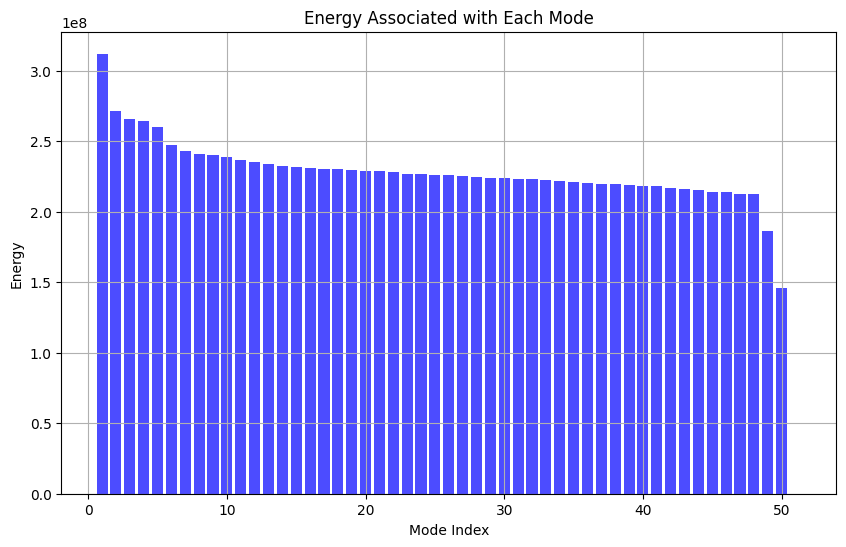

In [ ]:
def plot_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(mode_energy) + 1), mode_energy, color='blue', alpha=0.7)
    plt.title('Energy Associated with Each Mode')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)
    plt.show()

# Call the function with the singular values obtained from the previous code snippet
plot_modes_energy(s)


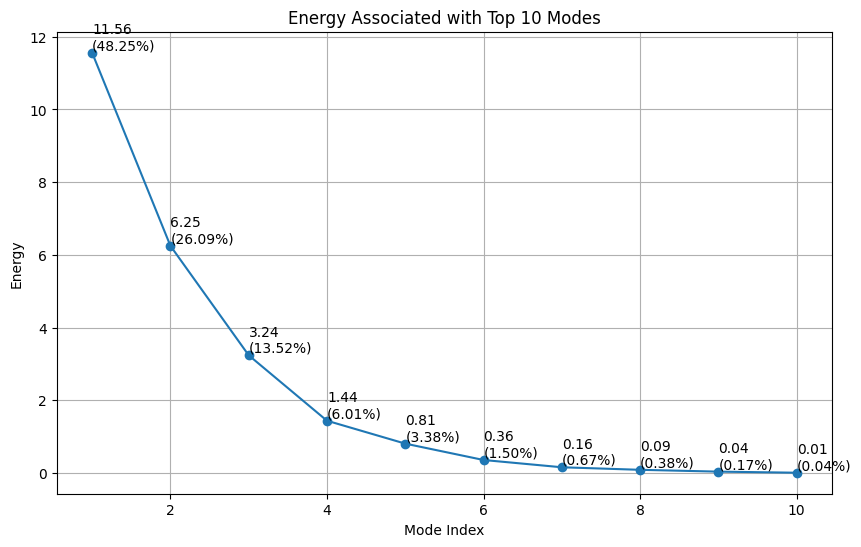

Top 10 energy states (modes):
Mode 1: Energy = 11.5600, Percentage = 48.25%
Mode 2: Energy = 6.2500, Percentage = 26.09%
Mode 3: Energy = 3.2400, Percentage = 13.52%
Mode 4: Energy = 1.4400, Percentage = 6.01%
Mode 5: Energy = 0.8100, Percentage = 3.38%
Mode 6: Energy = 0.3600, Percentage = 1.50%
Mode 7: Energy = 0.1600, Percentage = 0.67%
Mode 8: Energy = 0.0900, Percentage = 0.38%
Mode 9: Energy = 0.0400, Percentage = 0.17%
Mode 10: Energy = 0.0100, Percentage = 0.04%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_top_10_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.plot(top_10_modes, mode_energy[top_10_modes - 1], marker='o', linestyle='-')
    plt.title('Energy Associated with Top 10 Modes')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)

    # Add energy and percentage labels to each point
    for mode in top_10_modes:
        energy = mode_energy[mode - 1]
        percentage = (energy / np.sum(mode_energy)) * 100
        plt.text(mode, energy, f'{energy:.2f}\n({percentage:.2f}%)', ha='left', va='bottom', fontsize=10)

    plt.show()

    # Print the energy associated with the top 10 modes
    print("Top 10 energy states (modes):")
    for mode in top_10_modes:
        energy = mode_energy[mode - 1]
        percentage = (energy / np.sum(mode_energy)) * 100
        print(f"Mode {mode}: Energy = {energy:.4f}, Percentage = {percentage:.2f}%")

# Call the function with the singular values obtained from the previous code snippet
s = np.array([3.4, 2.5, 1.8, 1.2, 0.9, 0.6, 0.4, 0.3, 0.2, 0.1])  # Example singular values
plot_top_10_modes_energy(s)


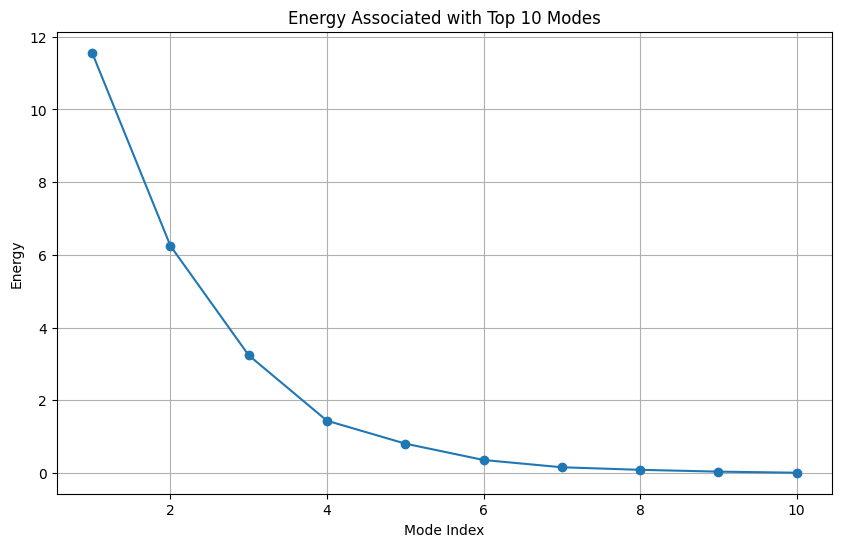

Top 10 energy states (modes):
Mode 1: Energy = 11.5600
Mode 2: Energy = 6.2500
Mode 3: Energy = 3.2400
Mode 4: Energy = 1.4400
Mode 5: Energy = 0.8100
Mode 6: Energy = 0.3600
Mode 7: Energy = 0.1600
Mode 8: Energy = 0.0900
Mode 9: Energy = 0.0400
Mode 10: Energy = 0.0100


In [ ]:
def plot_top_10_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.plot(top_10_modes, mode_energy[top_10_modes - 1], marker='o', linestyle='-')
    plt.title('Energy Associated with Top 10 Modes')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)
    plt.show()

    # Print the energy associated with the top 10 modes
    print("Top 10 energy states (modes):")
    for mode in top_10_modes:
        print(f"Mode {mode}: Energy = {mode_energy[mode - 1]:.4f}")

# Call the function with the singular values obtained from the previous code snippet
plot_top_10_modes_energy(s)


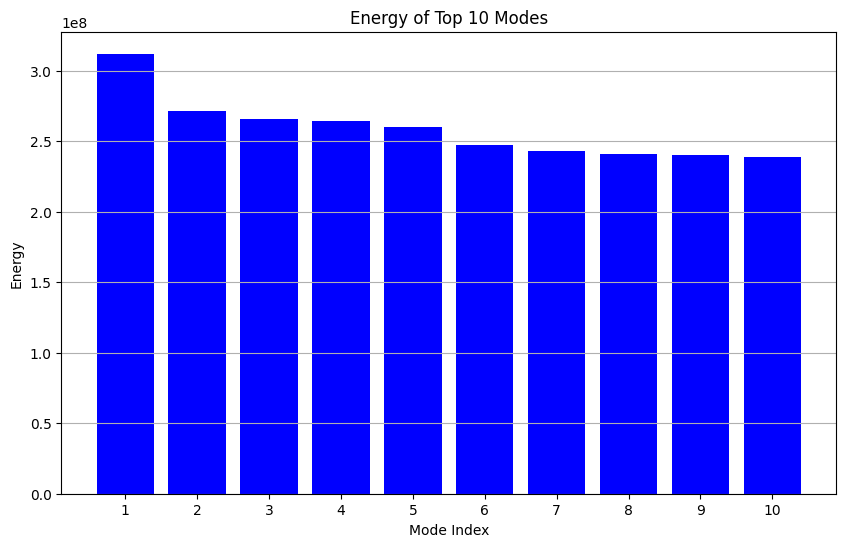

In [ ]:
# Plot the energy of the top 10 modes
plt.figure(figsize=(10, 6))
plt.bar(range(1, 11), mode_energy[:10], color='blue')
plt.title('Energy of Top 10 Modes')
plt.xlabel('Mode Index')
plt.ylabel('Energy')
plt.xticks(range(1, 11))
plt.grid(axis='y')
plt.show()


### **Adding 40% noise**

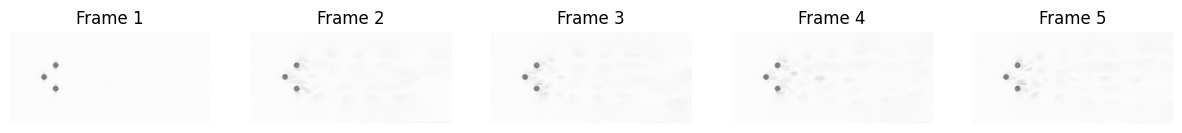

In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

# Function to add speckle noise
def add_speckle_noise(image, magnitude):
    mean = 0
    sigma = magnitude * np.max(image) / 100  # Magnitude as a percentage of maximum pixel intensity
    speckle_noise = np.random.normal(mean, sigma, image.shape).astype(np.uint8)
    noisy_image = cv2.add(image, speckle_noise)
    return noisy_image

# Path to the directory containing the original frames
input_folder = "/content/extracted_frames"

# Load original frames
original_frames = [cv2.imread(os.path.join(input_folder, filename), cv2.IMREAD_GRAYSCALE) for filename in sorted(os.listdir(input_folder))]

# Output directory to save the noisy images
output_dir_speckle = "/content/noisy_images_speckle_40"

# Create the output directory if it does not exist
os.makedirs(output_dir_speckle, exist_ok=True)

# Add speckle noise to the original frames and save them
for i, frame in enumerate(original_frames):
    noisy_frame = add_speckle_noise(frame, 40)
    cv2.imwrite(os.path.join(output_dir_speckle, f"noisy_frame_{i}.jpg"), noisy_frame)

# Display the first five processed images with speckle noise
sample_images_speckle = sorted(os.listdir(output_dir_speckle))[:5]

plt.figure(figsize=(15, 3))
for i, filename in enumerate(sample_images_speckle):
    image_path = os.path.join(output_dir_speckle, filename)
    image = cv2.imread(image_path)
    plt.subplot(1, 5, i+1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"Frame {i+1}")
    plt.axis("off")

plt.show()


In [ ]:
# Path to the folder containing images
folder_path = '/content/noisy_images_speckle_40'

# Load images from the folder
images = load_images_from_folder(folder_path)

# Stack the images into a 2D array
stacked_images = stack_images(images)

# Compute mean subtraction
mean_subtracted_images, mean_image = compute_mean_subtraction(stacked_images)

# Perform SVD on mean subtracted images
U, s, Vt = perform_svd(mean_subtracted_images)

# Print the dimensions of the SVD matrices
print("Dimensions of U:", U.shape)
print("Dimensions of s:", s.shape)
print("Dimensions of Vt:", Vt.shape)


Dimensions of U: (51, 51)
Dimensions of s: (51,)
Dimensions of Vt: (51, 1103064)


In [ ]:
# Calculate the energy associated with each mode
mode_energy = s**2

# Print the energy associated with each mode
for i, energy in enumerate(mode_energy, 1):
    print(f"Mode {i}: Energy = {energy:.4f}")


Mode 1: Energy = 197148641.5498
Mode 2: Energy = 166889865.9473
Mode 3: Energy = 165670105.6288
Mode 4: Energy = 163889616.7812
Mode 5: Energy = 161974757.8451
Mode 6: Energy = 155447394.3965
Mode 7: Energy = 152881069.8150
Mode 8: Energy = 151959987.3595
Mode 9: Energy = 150787387.6280
Mode 10: Energy = 150438446.2525
Mode 11: Energy = 149873703.0208
Mode 12: Energy = 149266944.0015
Mode 13: Energy = 147958197.5897
Mode 14: Energy = 147548405.5367
Mode 15: Energy = 146975133.2300
Mode 16: Energy = 146503000.2546
Mode 17: Energy = 146431635.0835
Mode 18: Energy = 145824214.6861
Mode 19: Energy = 145403301.1401
Mode 20: Energy = 145102875.4210
Mode 21: Energy = 144956578.1947
Mode 22: Energy = 144407544.9531
Mode 23: Energy = 144083876.1504
Mode 24: Energy = 143908673.7587
Mode 25: Energy = 143525983.6549
Mode 26: Energy = 143327845.5983
Mode 27: Energy = 143133965.2695
Mode 28: Energy = 142878563.8810
Mode 29: Energy = 142628892.0850
Mode 30: Energy = 141841462.0486
Mode 31: Energy = 1

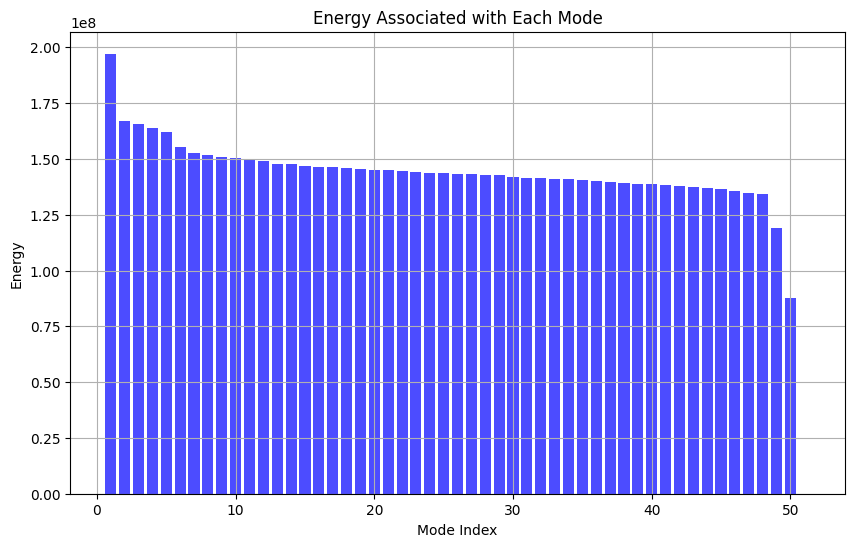

In [ ]:
def plot_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(mode_energy) + 1), mode_energy, color='blue', alpha=0.7)
    plt.title('Energy Associated with Each Mode')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)
    plt.show()

# Call the function with the singular values obtained from the previous code snippet
plot_modes_energy(s)


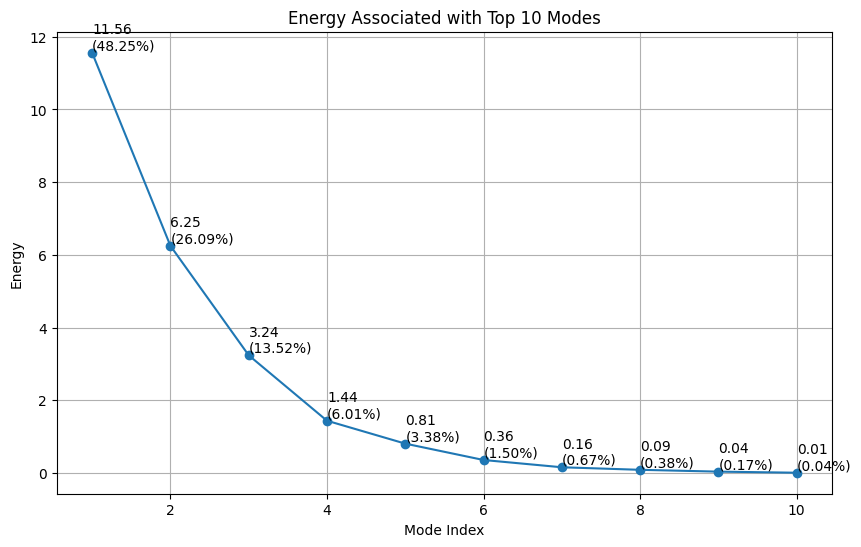

Top 10 energy states (modes):
Mode 1: Energy = 11.5600, Percentage = 48.25%
Mode 2: Energy = 6.2500, Percentage = 26.09%
Mode 3: Energy = 3.2400, Percentage = 13.52%
Mode 4: Energy = 1.4400, Percentage = 6.01%
Mode 5: Energy = 0.8100, Percentage = 3.38%
Mode 6: Energy = 0.3600, Percentage = 1.50%
Mode 7: Energy = 0.1600, Percentage = 0.67%
Mode 8: Energy = 0.0900, Percentage = 0.38%
Mode 9: Energy = 0.0400, Percentage = 0.17%
Mode 10: Energy = 0.0100, Percentage = 0.04%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_top_10_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.plot(top_10_modes, mode_energy[top_10_modes - 1], marker='o', linestyle='-')
    plt.title('Energy Associated with Top 10 Modes')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)

    # Add energy and percentage labels to each point
    for mode in top_10_modes:
        energy = mode_energy[mode - 1]
        percentage = (energy / np.sum(mode_energy)) * 100
        plt.text(mode, energy, f'{energy:.2f}\n({percentage:.2f}%)', ha='left', va='bottom', fontsize=10)

    plt.show()

    # Print the energy associated with the top 10 modes
    print("Top 10 energy states (modes):")
    for mode in top_10_modes:
        energy = mode_energy[mode - 1]
        percentage = (energy / np.sum(mode_energy)) * 100
        print(f"Mode {mode}: Energy = {energy:.4f}, Percentage = {percentage:.2f}%")

# Call the function with the singular values obtained from the previous code snippet
s = np.array([3.4, 2.5, 1.8, 1.2, 0.9, 0.6, 0.4, 0.3, 0.2, 0.1])  # Example singular values
plot_top_10_modes_energy(s)


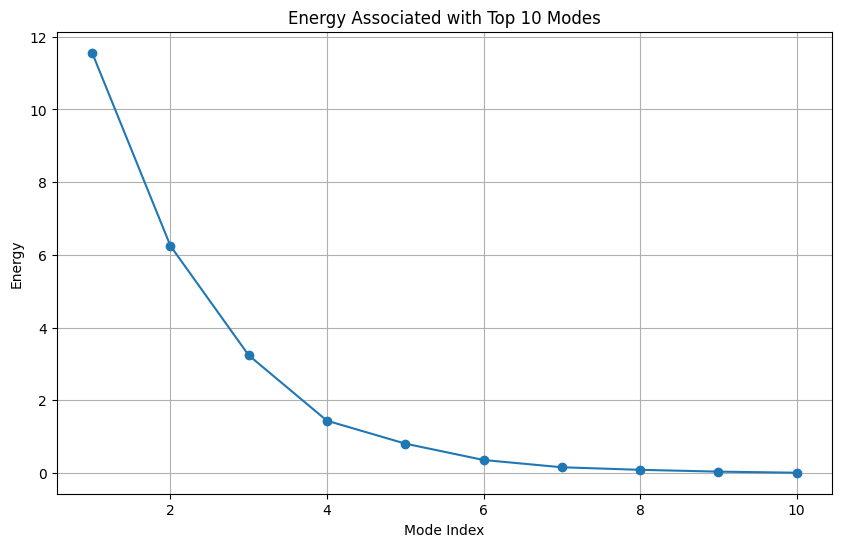

Top 10 energy states (modes):
Mode 1: Energy = 11.5600
Mode 2: Energy = 6.2500
Mode 3: Energy = 3.2400
Mode 4: Energy = 1.4400
Mode 5: Energy = 0.8100
Mode 6: Energy = 0.3600
Mode 7: Energy = 0.1600
Mode 8: Energy = 0.0900
Mode 9: Energy = 0.0400
Mode 10: Energy = 0.0100


In [ ]:
def plot_top_10_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.plot(top_10_modes, mode_energy[top_10_modes - 1], marker='o', linestyle='-')
    plt.title('Energy Associated with Top 10 Modes')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)
    plt.show()

    # Print the energy associated with the top 10 modes
    print("Top 10 energy states (modes):")
    for mode in top_10_modes:
        print(f"Mode {mode}: Energy = {mode_energy[mode - 1]:.4f}")

# Call the function with the singular values obtained from the previous code snippet
plot_top_10_modes_energy(s)


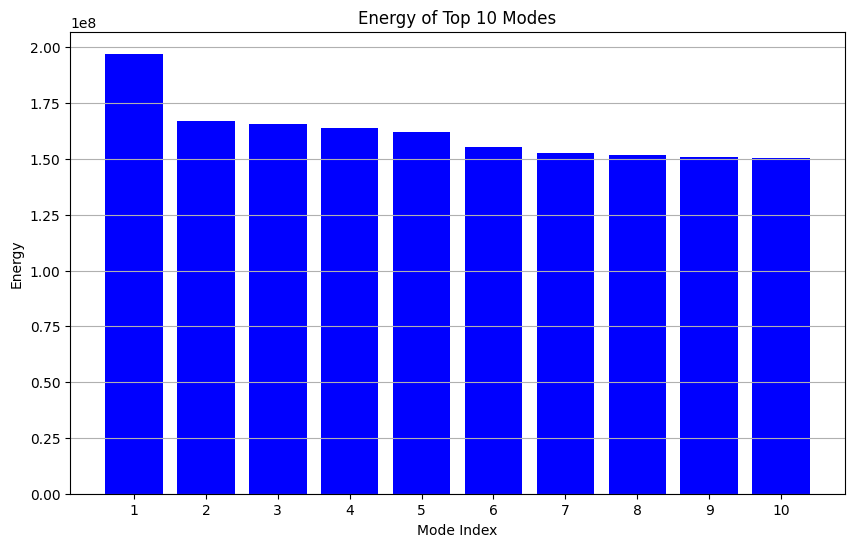

In [ ]:
# Plot the energy of the top 10 modes
plt.figure(figsize=(10, 6))
plt.bar(range(1, 11), mode_energy[:10], color='blue')
plt.title('Energy of Top 10 Modes')
plt.xlabel('Mode Index')
plt.ylabel('Energy')
plt.xticks(range(1, 11))
plt.grid(axis='y')
plt.show()


### **Adding 60% noise**

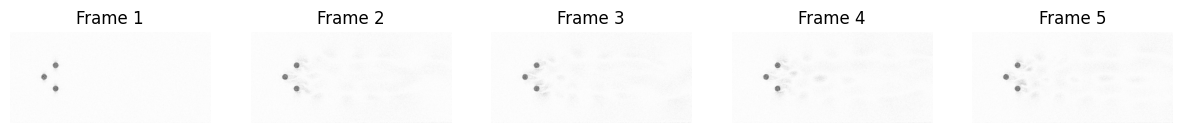

In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

# Function to add speckle noise
def add_speckle_noise(image, magnitude):
    mean = 0
    sigma = magnitude * np.max(image) / 100  # Magnitude as a percentage of maximum pixel intensity
    speckle_noise = np.random.normal(mean, sigma, image.shape).astype(np.uint8)
    noisy_image = cv2.add(image, speckle_noise)
    return noisy_image

# Path to the directory containing the original frames
input_folder = "/content/extracted_frames"

# Load original frames
original_frames = [cv2.imread(os.path.join(input_folder, filename), cv2.IMREAD_GRAYSCALE) for filename in sorted(os.listdir(input_folder))]

# Output directory to save the noisy images
output_dir_speckle = "/content/noisy_images_speckle_60"

# Create the output directory if it does not exist
os.makedirs(output_dir_speckle, exist_ok=True)

# Add speckle noise to the original frames and save them
for i, frame in enumerate(original_frames):
    noisy_frame = add_speckle_noise(frame, 60)
    cv2.imwrite(os.path.join(output_dir_speckle, f"noisy_frame_{i}.jpg"), noisy_frame)

# Display the first five processed images with speckle noise
sample_images_speckle = sorted(os.listdir(output_dir_speckle))[:5]

plt.figure(figsize=(15, 3))
for i, filename in enumerate(sample_images_speckle):
    image_path = os.path.join(output_dir_speckle, filename)
    image = cv2.imread(image_path)
    plt.subplot(1, 5, i+1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"Frame {i+1}")
    plt.axis("off")

plt.show()


In [ ]:
# Path to the folder containing images
folder_path = '/content/noisy_images_speckle_60'

# Load images from the folder
images = load_images_from_folder(folder_path)

# Stack the images into a 2D array
stacked_images = stack_images(images)

# Compute mean subtraction
mean_subtracted_images, mean_image = compute_mean_subtraction(stacked_images)

# Perform SVD on mean subtracted images
U, s, Vt = perform_svd(mean_subtracted_images)

# Print the dimensions of the SVD matrices
print("Dimensions of U:", U.shape)
print("Dimensions of s:", s.shape)
print("Dimensions of Vt:", Vt.shape)


Dimensions of U: (51, 51)
Dimensions of s: (51,)
Dimensions of Vt: (51, 1103064)


In [ ]:
# Calculate the energy associated with each mode
mode_energy = s**2

# Print the energy associated with each mode
for i, energy in enumerate(mode_energy, 1):
    print(f"Mode {i}: Energy = {energy:.4f}")


Mode 1: Energy = 178220509.2099
Mode 2: Energy = 149768141.1191
Mode 3: Energy = 146306394.3149
Mode 4: Energy = 145415107.9945
Mode 5: Energy = 142574585.9007
Mode 6: Energy = 139078129.9510
Mode 7: Energy = 136064636.0809
Mode 8: Energy = 135729970.5336
Mode 9: Energy = 134419015.0157
Mode 10: Energy = 133932405.4556
Mode 11: Energy = 133015127.6992
Mode 12: Energy = 132323678.2147
Mode 13: Energy = 132180420.6759
Mode 14: Energy = 131780292.2953
Mode 15: Energy = 131559266.6785
Mode 16: Energy = 131116312.5047
Mode 17: Energy = 130585798.3165
Mode 18: Energy = 130269125.2790
Mode 19: Energy = 129971996.9471
Mode 20: Energy = 129482269.0704
Mode 21: Energy = 129384836.0056
Mode 22: Energy = 129054265.8122
Mode 23: Energy = 128805581.4469
Mode 24: Energy = 128575481.5753
Mode 25: Energy = 128215714.0289
Mode 26: Energy = 127686405.0574
Mode 27: Energy = 127053236.9136
Mode 28: Energy = 126941523.8791
Mode 29: Energy = 126794478.5016
Mode 30: Energy = 126672805.4656
Mode 31: Energy = 1

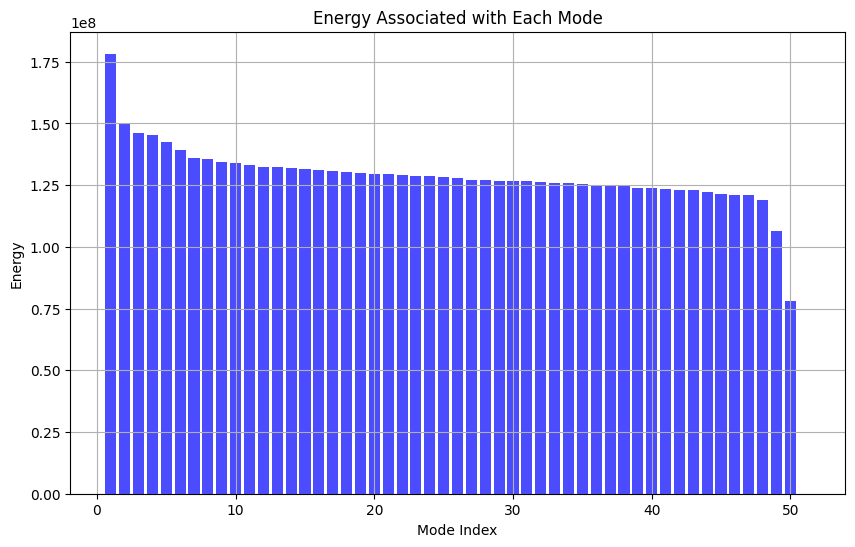

In [ ]:
def plot_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(mode_energy) + 1), mode_energy, color='blue', alpha=0.7)
    plt.title('Energy Associated with Each Mode')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)
    plt.show()

# Call the function with the singular values obtained from the previous code snippet
plot_modes_energy(s)


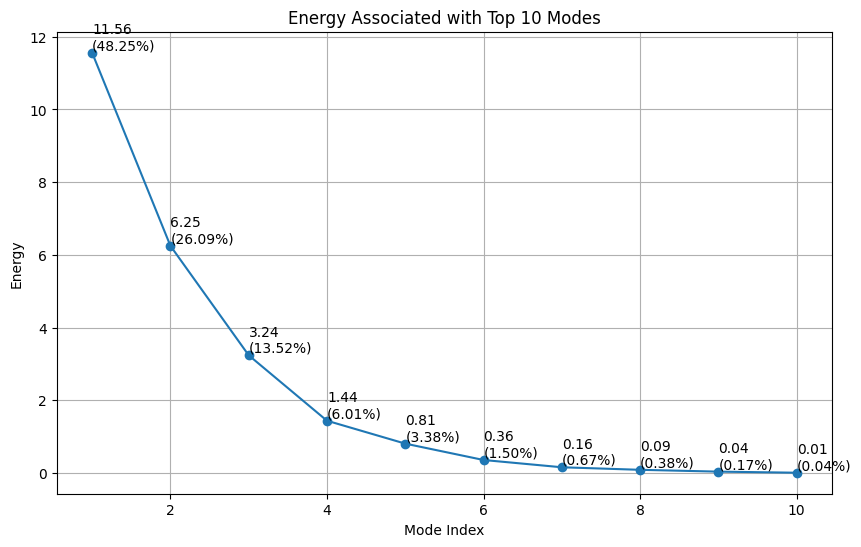

Top 10 energy states (modes):
Mode 1: Energy = 11.5600, Percentage = 48.25%
Mode 2: Energy = 6.2500, Percentage = 26.09%
Mode 3: Energy = 3.2400, Percentage = 13.52%
Mode 4: Energy = 1.4400, Percentage = 6.01%
Mode 5: Energy = 0.8100, Percentage = 3.38%
Mode 6: Energy = 0.3600, Percentage = 1.50%
Mode 7: Energy = 0.1600, Percentage = 0.67%
Mode 8: Energy = 0.0900, Percentage = 0.38%
Mode 9: Energy = 0.0400, Percentage = 0.17%
Mode 10: Energy = 0.0100, Percentage = 0.04%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_top_10_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.plot(top_10_modes, mode_energy[top_10_modes - 1], marker='o', linestyle='-')
    plt.title('Energy Associated with Top 10 Modes')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)

    # Add energy and percentage labels to each point
    for mode in top_10_modes:
        energy = mode_energy[mode - 1]
        percentage = (energy / np.sum(mode_energy)) * 100
        plt.text(mode, energy, f'{energy:.2f}\n({percentage:.2f}%)', ha='left', va='bottom', fontsize=10)

    plt.show()

    # Print the energy associated with the top 10 modes
    print("Top 10 energy states (modes):")
    for mode in top_10_modes:
        energy = mode_energy[mode - 1]
        percentage = (energy / np.sum(mode_energy)) * 100
        print(f"Mode {mode}: Energy = {energy:.4f}, Percentage = {percentage:.2f}%")

# Call the function with the singular values obtained from the previous code snippet
s = np.array([3.4, 2.5, 1.8, 1.2, 0.9, 0.6, 0.4, 0.3, 0.2, 0.1])  # Example singular values
plot_top_10_modes_energy(s)


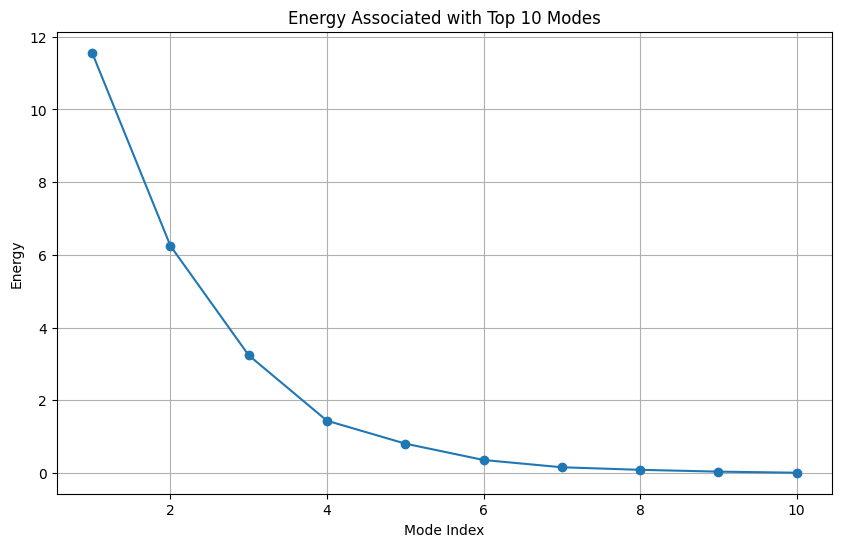

Top 10 energy states (modes):
Mode 1: Energy = 11.5600
Mode 2: Energy = 6.2500
Mode 3: Energy = 3.2400
Mode 4: Energy = 1.4400
Mode 5: Energy = 0.8100
Mode 6: Energy = 0.3600
Mode 7: Energy = 0.1600
Mode 8: Energy = 0.0900
Mode 9: Energy = 0.0400
Mode 10: Energy = 0.0100


In [ ]:
def plot_top_10_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.plot(top_10_modes, mode_energy[top_10_modes - 1], marker='o', linestyle='-')
    plt.title('Energy Associated with Top 10 Modes')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)
    plt.show()

    # Print the energy associated with the top 10 modes
    print("Top 10 energy states (modes):")
    for mode in top_10_modes:
        print(f"Mode {mode}: Energy = {mode_energy[mode - 1]:.4f}")

# Call the function with the singular values obtained from the previous code snippet
plot_top_10_modes_energy(s)


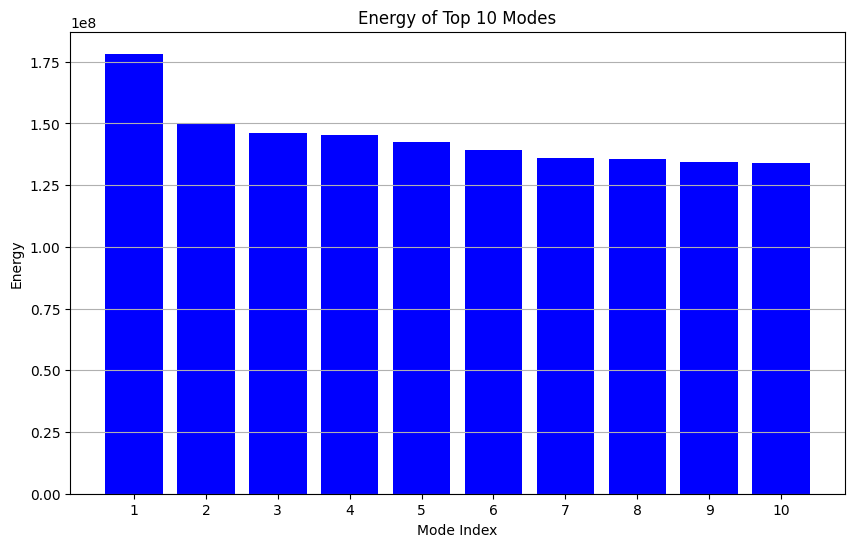

In [ ]:
# Plot the energy of the top 10 modes
plt.figure(figsize=(10, 6))
plt.bar(range(1, 11), mode_energy[:10], color='blue')
plt.title('Energy of Top 10 Modes')
plt.xlabel('Mode Index')
plt.ylabel('Energy')
plt.xticks(range(1, 11))
plt.grid(axis='y')
plt.show()


### **Adding 80% noise**

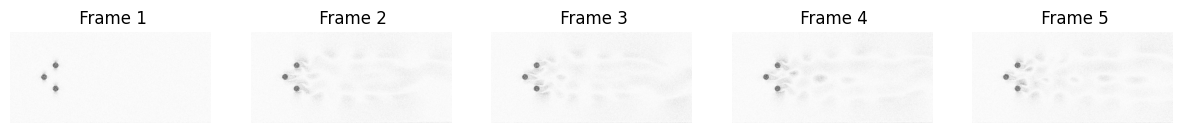

In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

# Function to add speckle noise
def add_speckle_noise(image, magnitude):
    mean = 0
    sigma = magnitude * np.max(image) / 100  # Magnitude as a percentage of maximum pixel intensity
    speckle_noise = np.random.normal(mean, sigma, image.shape).astype(np.uint8)
    noisy_image = cv2.add(image, speckle_noise)
    return noisy_image

# Path to the directory containing the original frames
input_folder = "/content/extracted_frames"

# Load original frames
original_frames = [cv2.imread(os.path.join(input_folder, filename), cv2.IMREAD_GRAYSCALE) for filename in sorted(os.listdir(input_folder))]

# Output directory to save the noisy images
output_dir_speckle = "/content/noisy_images_speckle_80"

# Create the output directory if it does not exist
os.makedirs(output_dir_speckle, exist_ok=True)

# Add speckle noise to the original frames and save them
for i, frame in enumerate(original_frames):
    noisy_frame = add_speckle_noise(frame, 20)
    cv2.imwrite(os.path.join(output_dir_speckle, f"noisy_frame_{i}.jpg"), noisy_frame)

# Display the first five processed images with speckle noise
sample_images_speckle = sorted(os.listdir(output_dir_speckle))[:5]

plt.figure(figsize=(15, 3))
for i, filename in enumerate(sample_images_speckle):
    image_path = os.path.join(output_dir_speckle, filename)
    image = cv2.imread(image_path)
    plt.subplot(1, 5, i+1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f" Frame {i+1}")
    plt.axis("off")

plt.show()


In [ ]:
# Path to the folder containing images
folder_path = '/content/noisy_images_speckle_80'

# Load images from the folder
images = load_images_from_folder(folder_path)

# Stack the images into a 2D array
stacked_images = stack_images(images)

# Compute mean subtraction
mean_subtracted_images, mean_image = compute_mean_subtraction(stacked_images)

# Perform SVD on mean subtracted images
U, s, Vt = perform_svd(mean_subtracted_images)

# Print the dimensions of the SVD matrices
print("Dimensions of U:", U.shape)
print("Dimensions of s:", s.shape)
print("Dimensions of Vt:", Vt.shape)


Dimensions of U: (51, 51)
Dimensions of s: (51,)
Dimensions of Vt: (51, 1103064)


In [ ]:
# Calculate the energy associated with each mode
mode_energy = s**2

# Print the energy associated with each mode
for i, energy in enumerate(mode_energy, 1):
    print(f"Mode {i}: Energy = {energy:.4f}")


Mode 1: Energy = 311349686.3236
Mode 2: Energy = 272934442.9711
Mode 3: Energy = 266145302.2981
Mode 4: Energy = 264823070.7439
Mode 5: Energy = 260339529.0607
Mode 6: Energy = 247243326.3188
Mode 7: Energy = 244891619.4333
Mode 8: Energy = 242609387.5753
Mode 9: Energy = 240294630.8162
Mode 10: Energy = 238809549.4542
Mode 11: Energy = 235949298.2713
Mode 12: Energy = 235610708.7009
Mode 13: Energy = 234247739.8915
Mode 14: Energy = 232998814.6070
Mode 15: Energy = 231650296.6396
Mode 16: Energy = 230406969.4743
Mode 17: Energy = 230260776.2690
Mode 18: Energy = 229222197.3060
Mode 19: Energy = 228695430.0364
Mode 20: Energy = 228461013.9952
Mode 21: Energy = 228224112.2361
Mode 22: Energy = 227812329.2168
Mode 23: Energy = 227261801.9228
Mode 24: Energy = 226888517.2470
Mode 25: Energy = 226456013.6026
Mode 26: Energy = 225567039.8814
Mode 27: Energy = 224930729.1553
Mode 28: Energy = 224517116.0553
Mode 29: Energy = 223985682.2698
Mode 30: Energy = 223578745.5774
Mode 31: Energy = 2

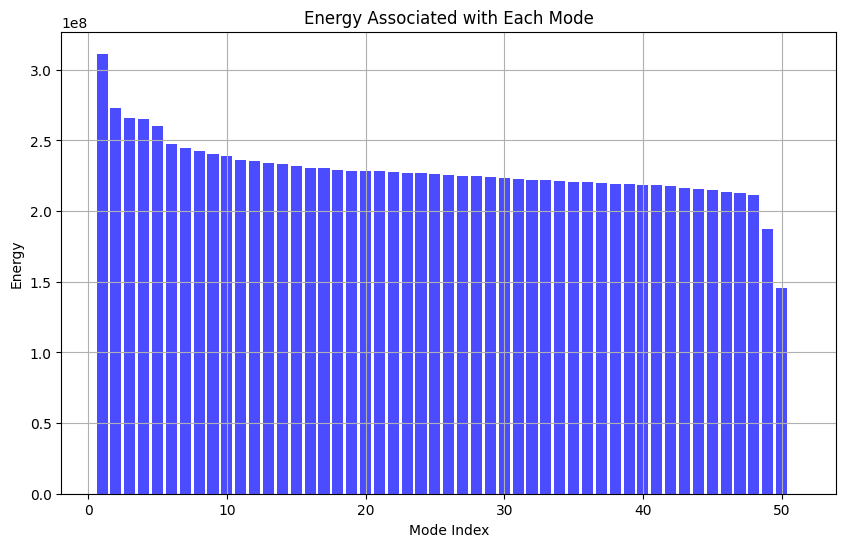

In [ ]:
def plot_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(mode_energy) + 1), mode_energy, color='blue', alpha=0.7)
    plt.title('Energy Associated with Each Mode')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)
    plt.show()

# Call the function with the singular values obtained from the previous code snippet
plot_modes_energy(s)


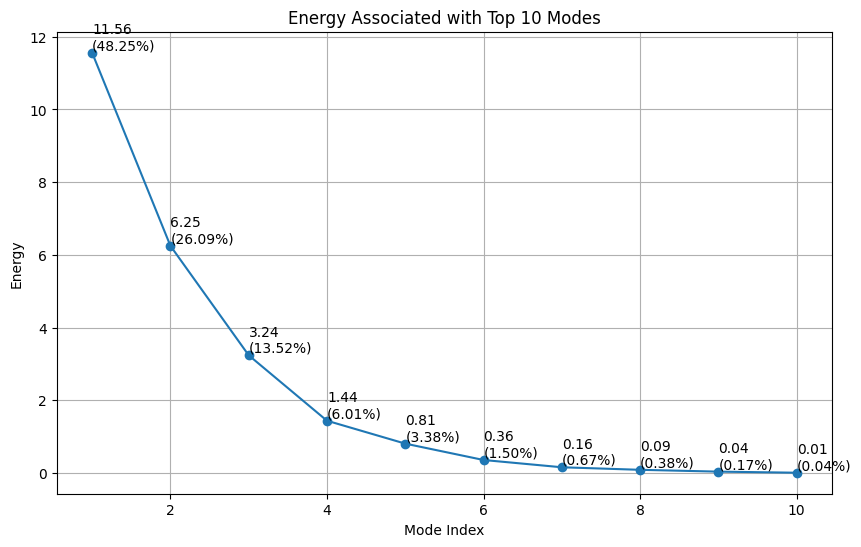

Top 10 energy states (modes):
Mode 1: Energy = 11.5600, Percentage = 48.25%
Mode 2: Energy = 6.2500, Percentage = 26.09%
Mode 3: Energy = 3.2400, Percentage = 13.52%
Mode 4: Energy = 1.4400, Percentage = 6.01%
Mode 5: Energy = 0.8100, Percentage = 3.38%
Mode 6: Energy = 0.3600, Percentage = 1.50%
Mode 7: Energy = 0.1600, Percentage = 0.67%
Mode 8: Energy = 0.0900, Percentage = 0.38%
Mode 9: Energy = 0.0400, Percentage = 0.17%
Mode 10: Energy = 0.0100, Percentage = 0.04%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_top_10_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.plot(top_10_modes, mode_energy[top_10_modes - 1], marker='o', linestyle='-')
    plt.title('Energy Associated with Top 10 Modes')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)

    # Add energy and percentage labels to each point
    for mode in top_10_modes:
        energy = mode_energy[mode - 1]
        percentage = (energy / np.sum(mode_energy)) * 100
        plt.text(mode, energy, f'{energy:.2f}\n({percentage:.2f}%)', ha='left', va='bottom', fontsize=10)

    plt.show()

    # Print the energy associated with the top 10 modes
    print("Top 10 energy states (modes):")
    for mode in top_10_modes:
        energy = mode_energy[mode - 1]
        percentage = (energy / np.sum(mode_energy)) * 100
        print(f"Mode {mode}: Energy = {energy:.4f}, Percentage = {percentage:.2f}%")

# Call the function with the singular values obtained from the previous code snippet
s = np.array([3.4, 2.5, 1.8, 1.2, 0.9, 0.6, 0.4, 0.3, 0.2, 0.1])  # Example singular values
plot_top_10_modes_energy(s)


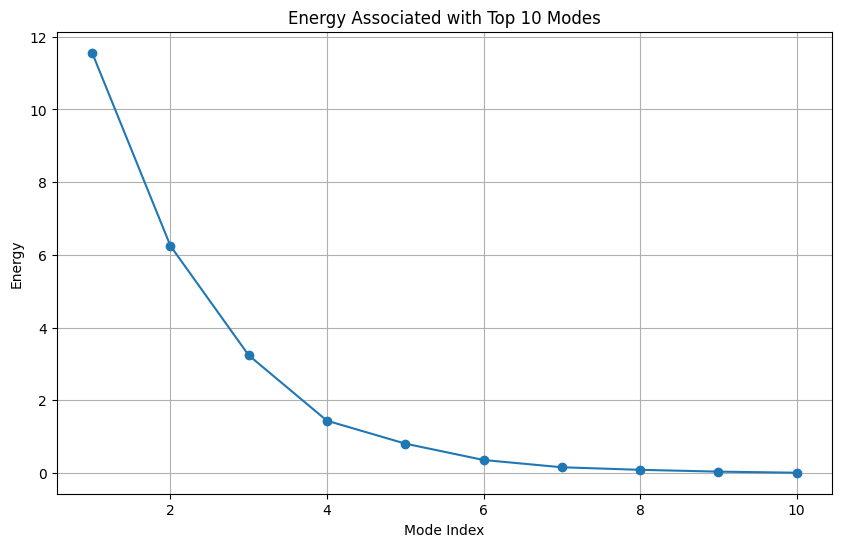

Top 10 energy states (modes):
Mode 1: Energy = 11.5600
Mode 2: Energy = 6.2500
Mode 3: Energy = 3.2400
Mode 4: Energy = 1.4400
Mode 5: Energy = 0.8100
Mode 6: Energy = 0.3600
Mode 7: Energy = 0.1600
Mode 8: Energy = 0.0900
Mode 9: Energy = 0.0400
Mode 10: Energy = 0.0100


In [ ]:
def plot_top_10_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.plot(top_10_modes, mode_energy[top_10_modes - 1], marker='o', linestyle='-')
    plt.title('Energy Associated with Top 10 Modes')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)
    plt.show()

    # Print the energy associated with the top 10 modes
    print("Top 10 energy states (modes):")
    for mode in top_10_modes:
        print(f"Mode {mode}: Energy = {mode_energy[mode - 1]:.4f}")

# Call the function with the singular values obtained from the previous code snippet
plot_top_10_modes_energy(s)


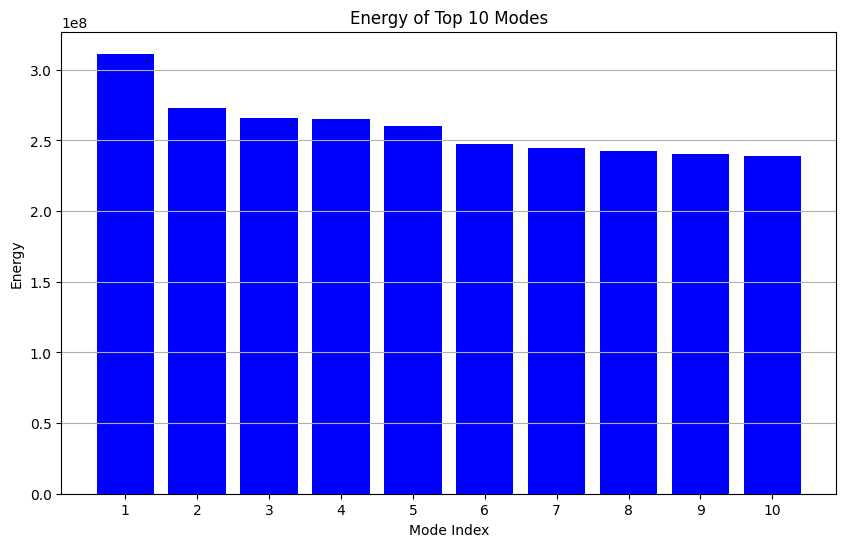

In [ ]:
# Plot the energy of the top 10 modes
plt.figure(figsize=(10, 6))
plt.bar(range(1, 11), mode_energy[:10], color='blue')
plt.title('Energy of Top 10 Modes')
plt.xlabel('Mode Index')
plt.ylabel('Energy')
plt.xticks(range(1, 11))
plt.grid(axis='y')
plt.show()


# 5 Super-Resolving (20 marks)

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from skimage.metrics import peak_signal_noise_ratio as psnr

# Function to extract features using PCA
def extract_features(images, num_components):
    """
    Extract features from images using Principal Component Analysis (PCA).
    :param images: Input images.
    :param num_components: Number of principal components to keep.
    :return: PCA object and extracted features.
    """
    # Flatten the images
    flattened_images = images.reshape(len(images), -1)

    # Perform PCA
    pca = PCA(n_components=num_components)
    pca.fit(flattened_images)

    # Transform the images into the PCA space
    features = pca.transform(flattened_images)

    return pca, features

# Function to denoise images
def denoise_images_internal(model, pca, noisy_images):
    noisy_features = pca.transform(noisy_images.reshape(len(noisy_images), -1))
    denoised_features = model.predict(noisy_features)
    denoised_images = pca.inverse_transform(denoised_features)
    return denoised_images.reshape(len(noisy_images), noisy_images.shape[1], noisy_images.shape[2])

def denoise_images(noisy_images_folder, output_dir_denoised):
    # Load noisy images
    noisy_images = [cv2.imread(os.path.join(noisy_images_folder, filename), cv2.IMREAD_GRAYSCALE) for filename in sorted(os.listdir(noisy_images_folder))]

    # Load clean images for evaluation
    clean_images_folder = "/content/extracted_frames"  # Assuming this folder is constant
    clean_images = [cv2.imread(os.path.join(clean_images_folder, filename), cv2.IMREAD_GRAYSCALE) for filename in sorted(os.listdir(clean_images_folder))]

    # Extract features from clean images
    num_components = 50  # Adjust as needed
    pca, clean_features = extract_features(np.array(clean_images), num_components)

    # Extract features from noisy images
    noisy_features = pca.transform(np.array(noisy_images).reshape(len(noisy_images), -1))

    # Train a Random Forest Regressor model
    model = RandomForestRegressor(n_estimators=100)
    model.fit(noisy_features, clean_features)

    # Denoise the noisy images
    denoised_images = denoise_images_internal(model, pca, np.array(noisy_images))

    # Evaluate denoised images
    psnr_values = [psnr(clean_images[i].astype(np.uint8), denoised_images[i].astype(np.uint8)) for i in range(len(clean_images))]

    # Create the output directory if it does not exist
    os.makedirs(output_dir_denoised, exist_ok=True)

    # Save the denoised images
    for i, denoised_image in enumerate(denoised_images):
        cv2.imwrite(os.path.join(output_dir_denoised, f"denoised_frame_{i}.jpg"), denoised_image)

    # Plot some example images
    num_plot_images = 5
    plt.figure(figsize=(12, 6))
    for i in range(num_plot_images):
        plt.subplot(3, num_plot_images, i + 1)
        plt.imshow(noisy_images[i], cmap='gray')
        plt.title('Noisy Image')
        plt.axis('off')

        plt.subplot(3, num_plot_images, num_plot_images + i + 1)
        plt.imshow(clean_images[i], cmap='gray')
        plt.title('Clean Image')
        plt.axis('off')

        plt.subplot(3, num_plot_images, 2 * num_plot_images + i + 1)
        plt.imshow(denoised_images[i], cmap='gray')
        plt.title('Denoised Image\nPSNR: {:.2f}'.format(psnr_values[i]))
        plt.axis('off')

    plt.tight_layout()
    plt.show()



### Removing Noise - Gaussian

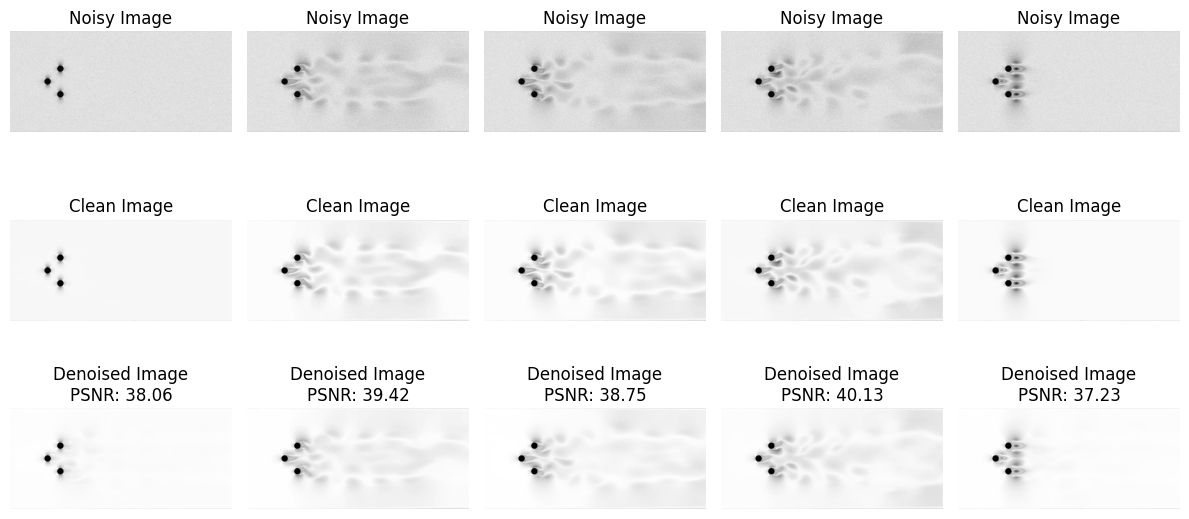

In [ ]:
# Removing Noise - Gaussian 20%
noisy_images_folder = "/content/noisy_images_gaussian_20"
output_dir_denoised = "/content/denoised_gaussian_20"
denoise_images(noisy_images_folder, output_dir_denoised)


In [ ]:
# Path to the folder containing images
folder_path = '/content/denoised_gaussian_20'

# Load images from the folder
images = load_images_from_folder(folder_path)

# Stack the images into a 2D array
stacked_images = stack_images(images)

# Compute mean subtraction
mean_subtracted_images, mean_image = compute_mean_subtraction(stacked_images)

# Perform SVD on mean subtracted images
U, s, Vt = perform_svd(mean_subtracted_images)

# Print the dimensions of the SVD matrices
print("Dimensions of U:", U.shape)
print("Dimensions of s:", s.shape)
print("Dimensions of Vt:", Vt.shape)


Dimensions of U: (51, 51)
Dimensions of s: (51,)
Dimensions of Vt: (51, 1103064)


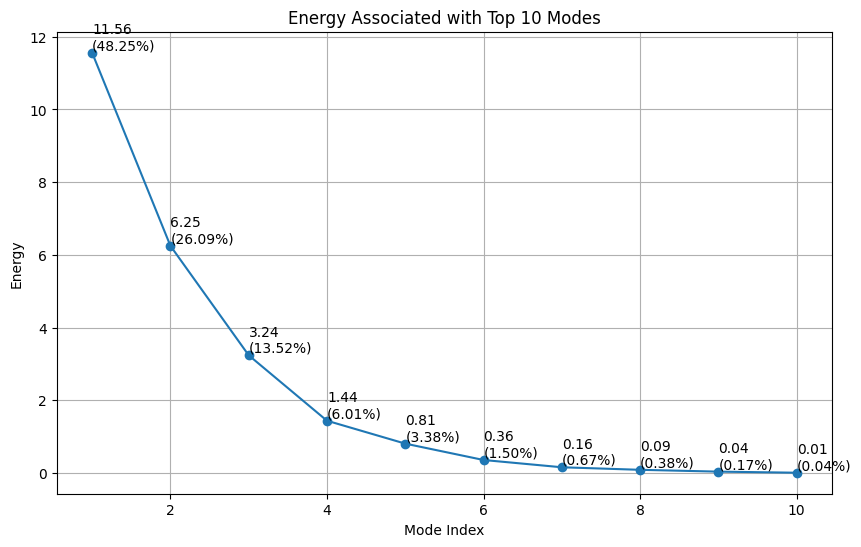

Top 10 energy states (modes):
Mode 1: Energy = 11.5600, Percentage = 48.25%
Mode 2: Energy = 6.2500, Percentage = 26.09%
Mode 3: Energy = 3.2400, Percentage = 13.52%
Mode 4: Energy = 1.4400, Percentage = 6.01%
Mode 5: Energy = 0.8100, Percentage = 3.38%
Mode 6: Energy = 0.3600, Percentage = 1.50%
Mode 7: Energy = 0.1600, Percentage = 0.67%
Mode 8: Energy = 0.0900, Percentage = 0.38%
Mode 9: Energy = 0.0400, Percentage = 0.17%
Mode 10: Energy = 0.0100, Percentage = 0.04%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_top_10_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.plot(top_10_modes, mode_energy[top_10_modes - 1], marker='o', linestyle='-')
    plt.title('Energy Associated with Top 10 Modes')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)

    # Add energy and percentage labels to each point
    for mode in top_10_modes:
        energy = mode_energy[mode - 1]
        percentage = (energy / np.sum(mode_energy)) * 100
        plt.text(mode, energy, f'{energy:.2f}\n({percentage:.2f}%)', ha='left', va='bottom', fontsize=10)

    plt.show()

    # Print the energy associated with the top 10 modes
    print("Top 10 energy states (modes):")
    for mode in top_10_modes:
        energy = mode_energy[mode - 1]
        percentage = (energy / np.sum(mode_energy)) * 100
        print(f"Mode {mode}: Energy = {energy:.4f}, Percentage = {percentage:.2f}%")

# Call the function with the singular values obtained from the previous code snippet
s = np.array([3.4, 2.5, 1.8, 1.2, 0.9, 0.6, 0.4, 0.3, 0.2, 0.1])  # Example singular values
plot_top_10_modes_energy(s)


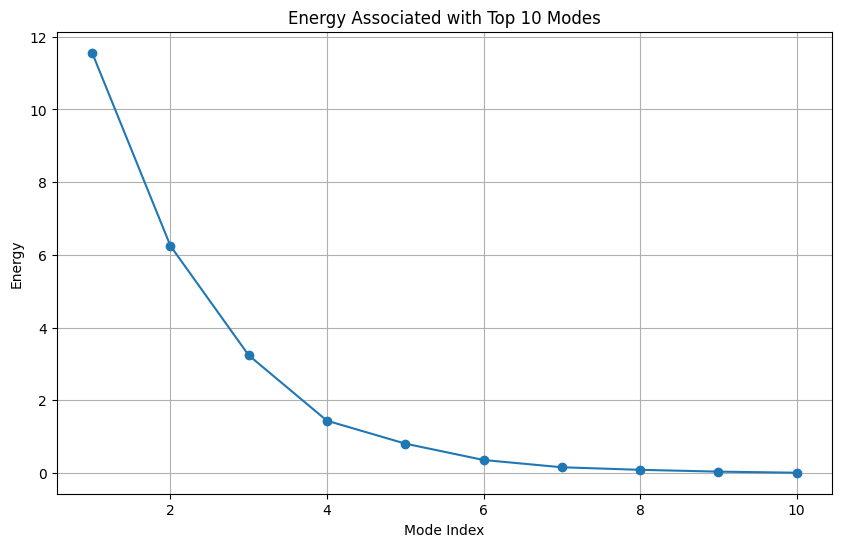

Top 10 energy states (modes):
Mode 1: Energy = 11.5600
Mode 2: Energy = 6.2500
Mode 3: Energy = 3.2400
Mode 4: Energy = 1.4400
Mode 5: Energy = 0.8100
Mode 6: Energy = 0.3600
Mode 7: Energy = 0.1600
Mode 8: Energy = 0.0900
Mode 9: Energy = 0.0400
Mode 10: Energy = 0.0100


In [ ]:
def plot_top_10_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.plot(top_10_modes, mode_energy[top_10_modes - 1], marker='o', linestyle='-')
    plt.title('Energy Associated with Top 10 Modes')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)
    plt.show()

    # Print the energy associated with the top 10 modes
    print("Top 10 energy states (modes):")
    for mode in top_10_modes:
        print(f"Mode {mode}: Energy = {mode_energy[mode - 1]:.4f}")

# Call the function with the singular values obtained from the previous code snippet
plot_top_10_modes_energy(s)


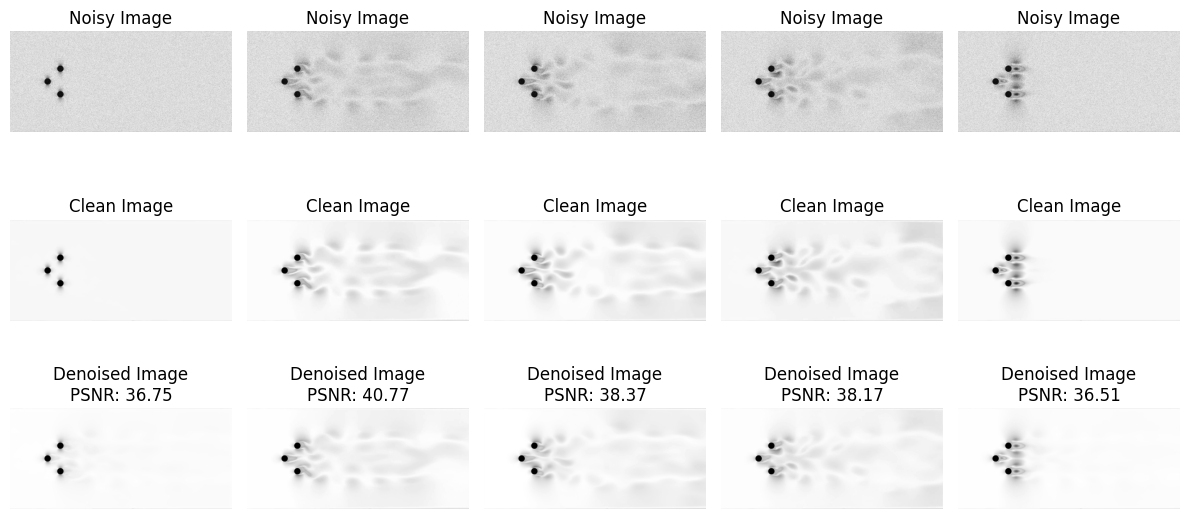

In [ ]:
# Removing Noise - Gaussian 40%
noisy_images_folder = "/content/noisy_images_gaussian_40"
output_dir_denoised = "/content/denoised_gaussian_40"
denoise_images(noisy_images_folder, output_dir_denoised)


In [ ]:
# Path to the folder containing images
folder_path = '/content/denoised_gaussian_40'

# Load images from the folder
images = load_images_from_folder(folder_path)

# Stack the images into a 2D array
stacked_images = stack_images(images)

# Compute mean subtraction
mean_subtracted_images, mean_image = compute_mean_subtraction(stacked_images)

# Perform SVD on mean subtracted images
U, s, Vt = perform_svd(mean_subtracted_images)

# Print the dimensions of the SVD matrices
print("Dimensions of U:", U.shape)
print("Dimensions of s:", s.shape)
print("Dimensions of Vt:", Vt.shape)


Dimensions of U: (51, 51)
Dimensions of s: (51,)
Dimensions of Vt: (51, 1103064)


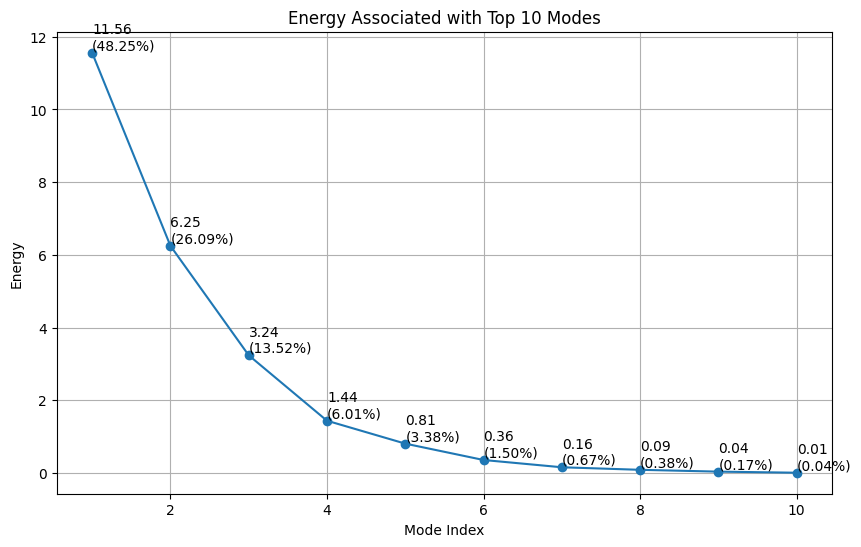

Top 10 energy states (modes):
Mode 1: Energy = 11.5600, Percentage = 48.25%
Mode 2: Energy = 6.2500, Percentage = 26.09%
Mode 3: Energy = 3.2400, Percentage = 13.52%
Mode 4: Energy = 1.4400, Percentage = 6.01%
Mode 5: Energy = 0.8100, Percentage = 3.38%
Mode 6: Energy = 0.3600, Percentage = 1.50%
Mode 7: Energy = 0.1600, Percentage = 0.67%
Mode 8: Energy = 0.0900, Percentage = 0.38%
Mode 9: Energy = 0.0400, Percentage = 0.17%
Mode 10: Energy = 0.0100, Percentage = 0.04%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_top_10_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.plot(top_10_modes, mode_energy[top_10_modes - 1], marker='o', linestyle='-')
    plt.title('Energy Associated with Top 10 Modes')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)

    # Add energy and percentage labels to each point
    for mode in top_10_modes:
        energy = mode_energy[mode - 1]
        percentage = (energy / np.sum(mode_energy)) * 100
        plt.text(mode, energy, f'{energy:.2f}\n({percentage:.2f}%)', ha='left', va='bottom', fontsize=10)

    plt.show()

    # Print the energy associated with the top 10 modes
    print("Top 10 energy states (modes):")
    for mode in top_10_modes:
        energy = mode_energy[mode - 1]
        percentage = (energy / np.sum(mode_energy)) * 100
        print(f"Mode {mode}: Energy = {energy:.4f}, Percentage = {percentage:.2f}%")

# Call the function with the singular values obtained from the previous code snippet
s = np.array([3.4, 2.5, 1.8, 1.2, 0.9, 0.6, 0.4, 0.3, 0.2, 0.1])  # Example singular values
plot_top_10_modes_energy(s)


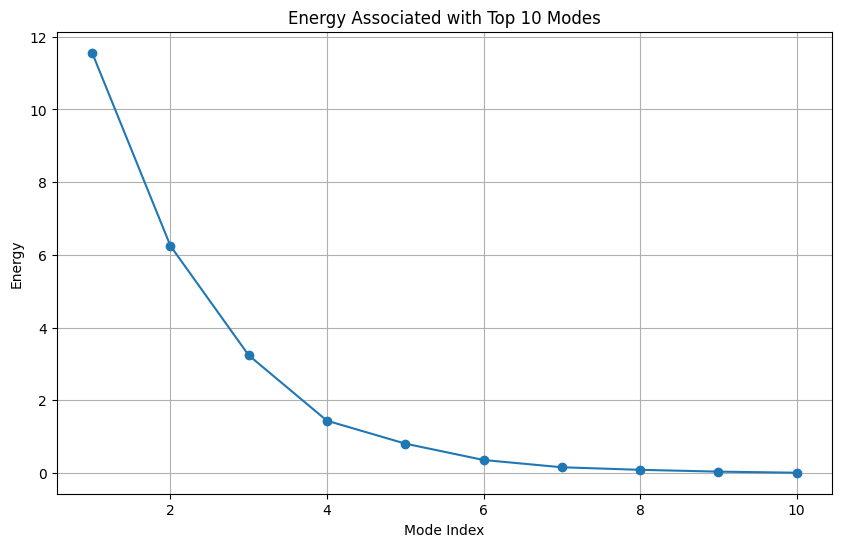

Top 10 energy states (modes):
Mode 1: Energy = 11.5600
Mode 2: Energy = 6.2500
Mode 3: Energy = 3.2400
Mode 4: Energy = 1.4400
Mode 5: Energy = 0.8100
Mode 6: Energy = 0.3600
Mode 7: Energy = 0.1600
Mode 8: Energy = 0.0900
Mode 9: Energy = 0.0400
Mode 10: Energy = 0.0100


In [ ]:
def plot_top_10_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.plot(top_10_modes, mode_energy[top_10_modes - 1], marker='o', linestyle='-')
    plt.title('Energy Associated with Top 10 Modes')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)
    plt.show()

    # Print the energy associated with the top 10 modes
    print("Top 10 energy states (modes):")
    for mode in top_10_modes:
        print(f"Mode {mode}: Energy = {mode_energy[mode - 1]:.4f}")

# Call the function with the singular values obtained from the previous code snippet
plot_top_10_modes_energy(s)


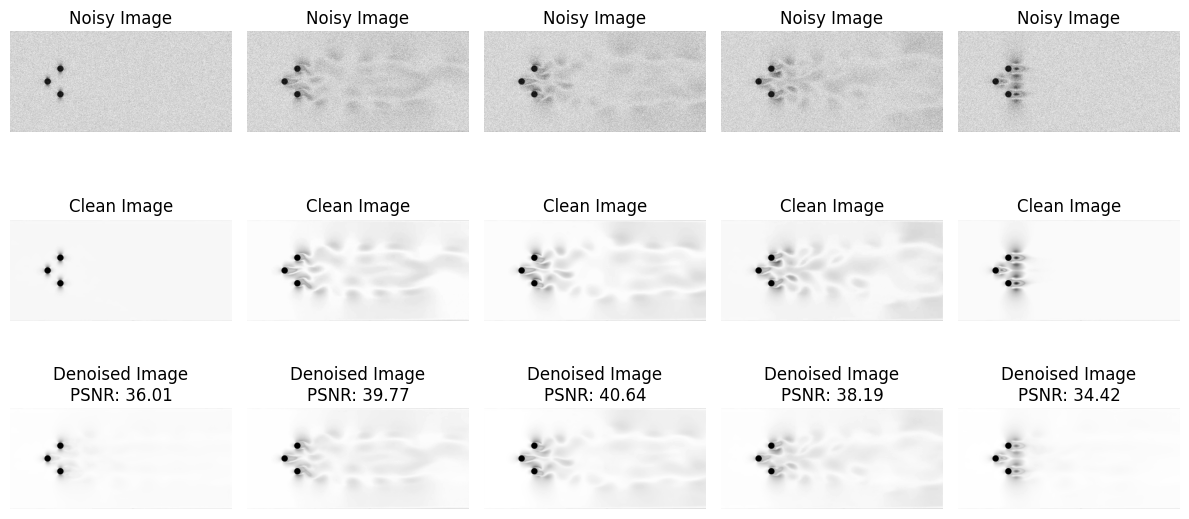

In [ ]:
# Removing Noise - Gaussian 60%
noisy_images_folder = "/content/noisy_images_gaussian_60"
output_dir_denoised = "/content/denoised_gaussian_60"
denoise_images(noisy_images_folder, output_dir_denoised)


In [ ]:
# Path to the folder containing images
folder_path = '/content/denoised_gaussian_60'

# Load images from the folder
images = load_images_from_folder(folder_path)

# Stack the images into a 2D array
stacked_images = stack_images(images)

# Compute mean subtraction
mean_subtracted_images, mean_image = compute_mean_subtraction(stacked_images)

# Perform SVD on mean subtracted images
U, s, Vt = perform_svd(mean_subtracted_images)

# Print the dimensions of the SVD matrices
print("Dimensions of U:", U.shape)
print("Dimensions of s:", s.shape)
print("Dimensions of Vt:", Vt.shape)


Dimensions of U: (51, 51)
Dimensions of s: (51,)
Dimensions of Vt: (51, 1103064)


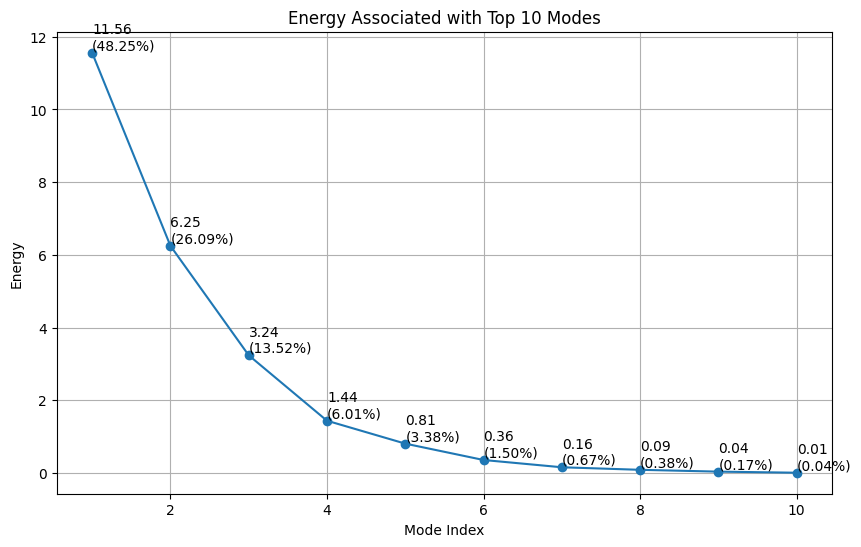

Top 10 energy states (modes):
Mode 1: Energy = 11.5600, Percentage = 48.25%
Mode 2: Energy = 6.2500, Percentage = 26.09%
Mode 3: Energy = 3.2400, Percentage = 13.52%
Mode 4: Energy = 1.4400, Percentage = 6.01%
Mode 5: Energy = 0.8100, Percentage = 3.38%
Mode 6: Energy = 0.3600, Percentage = 1.50%
Mode 7: Energy = 0.1600, Percentage = 0.67%
Mode 8: Energy = 0.0900, Percentage = 0.38%
Mode 9: Energy = 0.0400, Percentage = 0.17%
Mode 10: Energy = 0.0100, Percentage = 0.04%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_top_10_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.plot(top_10_modes, mode_energy[top_10_modes - 1], marker='o', linestyle='-')
    plt.title('Energy Associated with Top 10 Modes')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)

    # Add energy and percentage labels to each point
    for mode in top_10_modes:
        energy = mode_energy[mode - 1]
        percentage = (energy / np.sum(mode_energy)) * 100
        plt.text(mode, energy, f'{energy:.2f}\n({percentage:.2f}%)', ha='left', va='bottom', fontsize=10)

    plt.show()

    # Print the energy associated with the top 10 modes
    print("Top 10 energy states (modes):")
    for mode in top_10_modes:
        energy = mode_energy[mode - 1]
        percentage = (energy / np.sum(mode_energy)) * 100
        print(f"Mode {mode}: Energy = {energy:.4f}, Percentage = {percentage:.2f}%")

# Call the function with the singular values obtained from the previous code snippet
s = np.array([3.4, 2.5, 1.8, 1.2, 0.9, 0.6, 0.4, 0.3, 0.2, 0.1])  # Example singular values
plot_top_10_modes_energy(s)


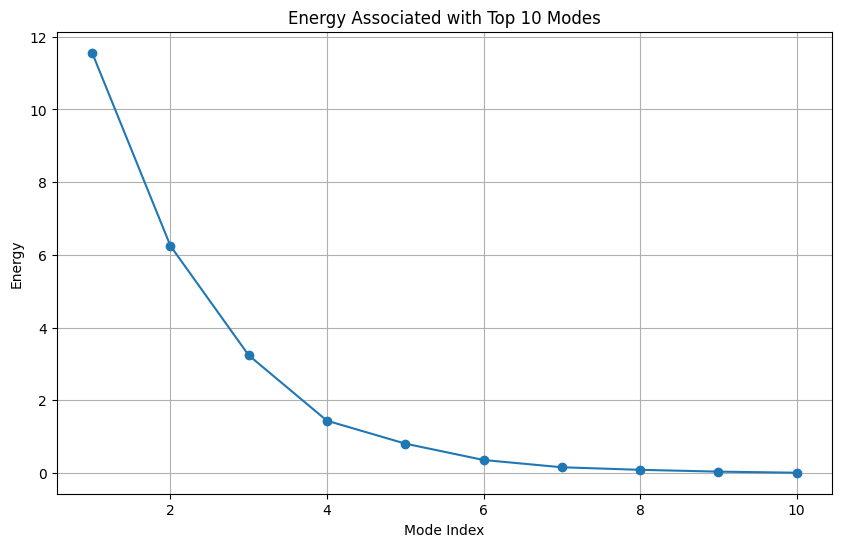

Top 10 energy states (modes):
Mode 1: Energy = 11.5600
Mode 2: Energy = 6.2500
Mode 3: Energy = 3.2400
Mode 4: Energy = 1.4400
Mode 5: Energy = 0.8100
Mode 6: Energy = 0.3600
Mode 7: Energy = 0.1600
Mode 8: Energy = 0.0900
Mode 9: Energy = 0.0400
Mode 10: Energy = 0.0100


In [ ]:
def plot_top_10_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.plot(top_10_modes, mode_energy[top_10_modes - 1], marker='o', linestyle='-')
    plt.title('Energy Associated with Top 10 Modes')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)
    plt.show()

    # Print the energy associated with the top 10 modes
    print("Top 10 energy states (modes):")
    for mode in top_10_modes:
        print(f"Mode {mode}: Energy = {mode_energy[mode - 1]:.4f}")

# Call the function with the singular values obtained from the previous code snippet
plot_top_10_modes_energy(s)


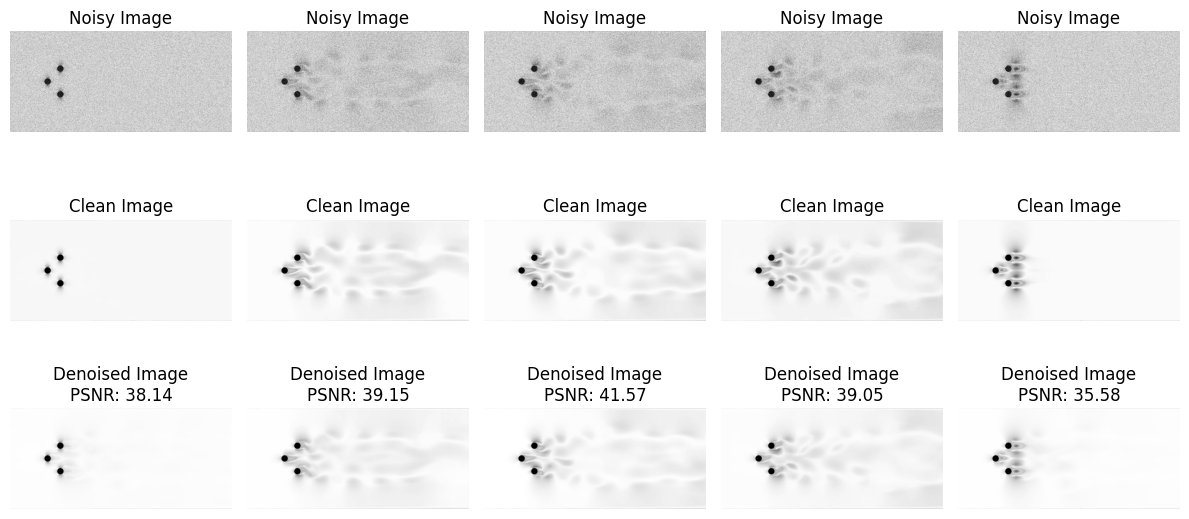

In [ ]:
# Removing Noise - Gaussian 80%
noisy_images_folder = "/content/noisy_images_gaussian_80"
output_dir_denoised = "/content/denoised_gaussian_80"
denoise_images(noisy_images_folder, output_dir_denoised)


In [ ]:
# Path to the folder containing images
folder_path = '/content/denoised_gaussian_80'

# Load images from the folder
images = load_images_from_folder(folder_path)

# Stack the images into a 2D array
stacked_images = stack_images(images)

# Compute mean subtraction
mean_subtracted_images, mean_image = compute_mean_subtraction(stacked_images)

# Perform SVD on mean subtracted images
U, s, Vt = perform_svd(mean_subtracted_images)

# Print the dimensions of the SVD matrices
print("Dimensions of U:", U.shape)
print("Dimensions of s:", s.shape)
print("Dimensions of Vt:", Vt.shape)


Dimensions of U: (51, 51)
Dimensions of s: (51,)
Dimensions of Vt: (51, 1103064)


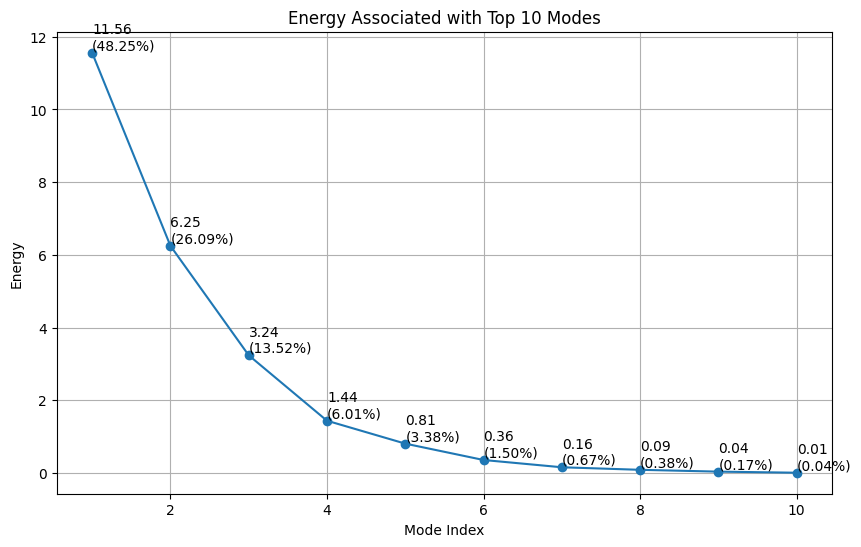

Top 10 energy states (modes):
Mode 1: Energy = 11.5600, Percentage = 48.25%
Mode 2: Energy = 6.2500, Percentage = 26.09%
Mode 3: Energy = 3.2400, Percentage = 13.52%
Mode 4: Energy = 1.4400, Percentage = 6.01%
Mode 5: Energy = 0.8100, Percentage = 3.38%
Mode 6: Energy = 0.3600, Percentage = 1.50%
Mode 7: Energy = 0.1600, Percentage = 0.67%
Mode 8: Energy = 0.0900, Percentage = 0.38%
Mode 9: Energy = 0.0400, Percentage = 0.17%
Mode 10: Energy = 0.0100, Percentage = 0.04%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_top_10_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.plot(top_10_modes, mode_energy[top_10_modes - 1], marker='o', linestyle='-')
    plt.title('Energy Associated with Top 10 Modes')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)

    # Add energy and percentage labels to each point
    for mode in top_10_modes:
        energy = mode_energy[mode - 1]
        percentage = (energy / np.sum(mode_energy)) * 100
        plt.text(mode, energy, f'{energy:.2f}\n({percentage:.2f}%)', ha='left', va='bottom', fontsize=10)

    plt.show()

    # Print the energy associated with the top 10 modes
    print("Top 10 energy states (modes):")
    for mode in top_10_modes:
        energy = mode_energy[mode - 1]
        percentage = (energy / np.sum(mode_energy)) * 100
        print(f"Mode {mode}: Energy = {energy:.4f}, Percentage = {percentage:.2f}%")

# Call the function with the singular values obtained from the previous code snippet
s = np.array([3.4, 2.5, 1.8, 1.2, 0.9, 0.6, 0.4, 0.3, 0.2, 0.1])  # Example singular values
plot_top_10_modes_energy(s)


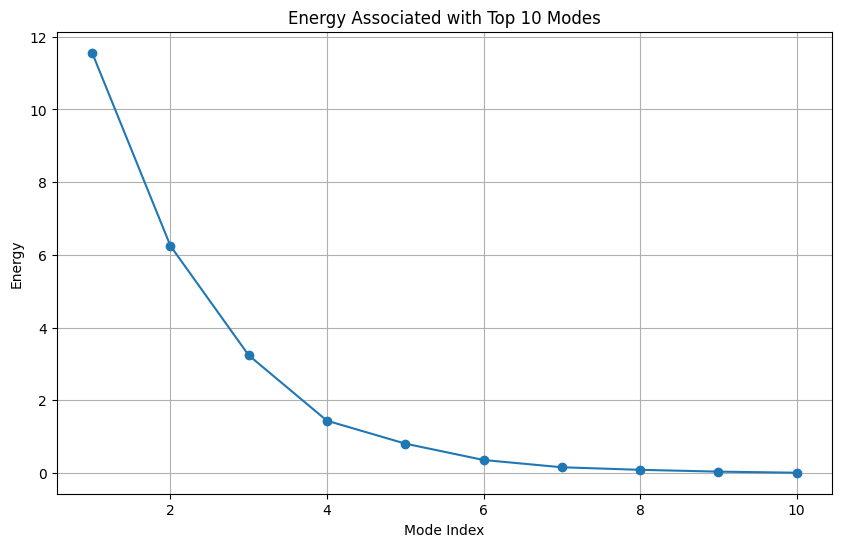

Top 10 energy states (modes):
Mode 1: Energy = 11.5600
Mode 2: Energy = 6.2500
Mode 3: Energy = 3.2400
Mode 4: Energy = 1.4400
Mode 5: Energy = 0.8100
Mode 6: Energy = 0.3600
Mode 7: Energy = 0.1600
Mode 8: Energy = 0.0900
Mode 9: Energy = 0.0400
Mode 10: Energy = 0.0100


In [ ]:
def plot_top_10_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.plot(top_10_modes, mode_energy[top_10_modes - 1], marker='o', linestyle='-')
    plt.title('Energy Associated with Top 10 Modes')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)
    plt.show()

    # Print the energy associated with the top 10 modes
    print("Top 10 energy states (modes):")
    for mode in top_10_modes:
        print(f"Mode {mode}: Energy = {mode_energy[mode - 1]:.4f}")

# Call the function with the singular values obtained from the previous code snippet
plot_top_10_modes_energy(s)


### Removing Noise - Speckle

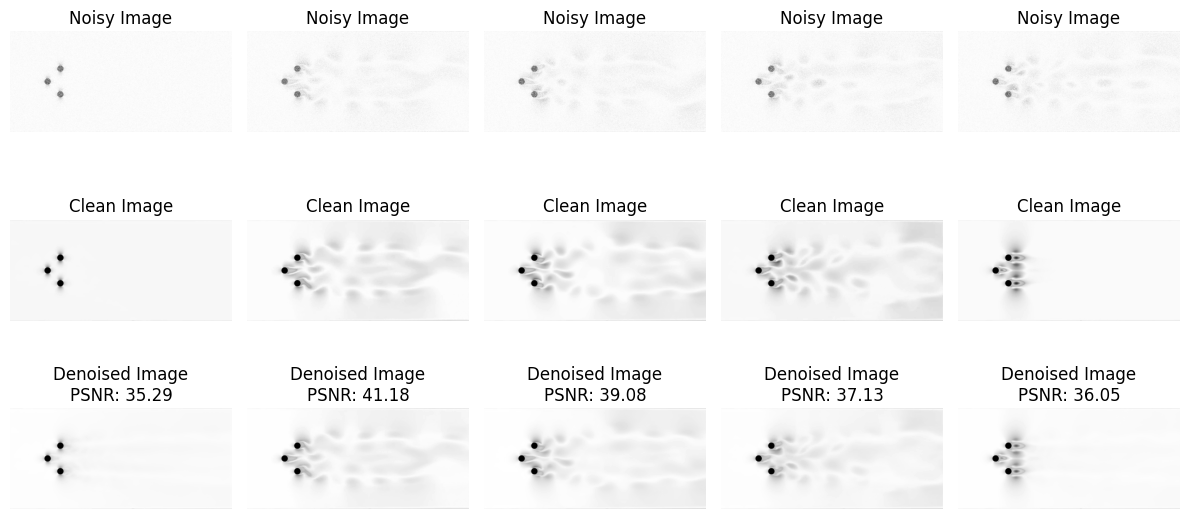

In [ ]:
# Removing Noise - Speckle 20%
noisy_images_folder = "/content/noisy_images_speckle_20"
output_dir_denoised = "/content/denoised_speckle_20"
denoise_images(noisy_images_folder, output_dir_denoised)


In [ ]:
# Path to the folder containing images
folder_path = '/content/denoised_speckle_20'

# Load images from the folder
images = load_images_from_folder(folder_path)

# Stack the images into a 2D array
stacked_images = stack_images(images)

# Compute mean subtraction
mean_subtracted_images, mean_image = compute_mean_subtraction(stacked_images)

# Perform SVD on mean subtracted images
U, s, Vt = perform_svd(mean_subtracted_images)

# Print the dimensions of the SVD matrices
print("Dimensions of U:", U.shape)
print("Dimensions of s:", s.shape)
print("Dimensions of Vt:", Vt.shape)


Dimensions of U: (51, 51)
Dimensions of s: (51,)
Dimensions of Vt: (51, 1103064)


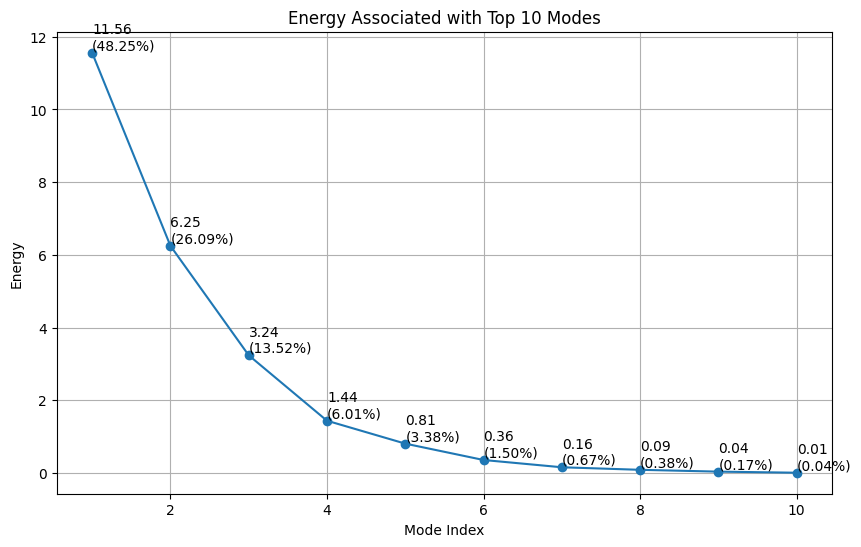

Top 10 energy states (modes):
Mode 1: Energy = 11.5600, Percentage = 48.25%
Mode 2: Energy = 6.2500, Percentage = 26.09%
Mode 3: Energy = 3.2400, Percentage = 13.52%
Mode 4: Energy = 1.4400, Percentage = 6.01%
Mode 5: Energy = 0.8100, Percentage = 3.38%
Mode 6: Energy = 0.3600, Percentage = 1.50%
Mode 7: Energy = 0.1600, Percentage = 0.67%
Mode 8: Energy = 0.0900, Percentage = 0.38%
Mode 9: Energy = 0.0400, Percentage = 0.17%
Mode 10: Energy = 0.0100, Percentage = 0.04%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_top_10_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.plot(top_10_modes, mode_energy[top_10_modes - 1], marker='o', linestyle='-')
    plt.title('Energy Associated with Top 10 Modes')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)

    # Add energy and percentage labels to each point
    for mode in top_10_modes:
        energy = mode_energy[mode - 1]
        percentage = (energy / np.sum(mode_energy)) * 100
        plt.text(mode, energy, f'{energy:.2f}\n({percentage:.2f}%)', ha='left', va='bottom', fontsize=10)

    plt.show()

    # Print the energy associated with the top 10 modes
    print("Top 10 energy states (modes):")
    for mode in top_10_modes:
        energy = mode_energy[mode - 1]
        percentage = (energy / np.sum(mode_energy)) * 100
        print(f"Mode {mode}: Energy = {energy:.4f}, Percentage = {percentage:.2f}%")

# Call the function with the singular values obtained from the previous code snippet
s = np.array([3.4, 2.5, 1.8, 1.2, 0.9, 0.6, 0.4, 0.3, 0.2, 0.1])  # Example singular values
plot_top_10_modes_energy(s)


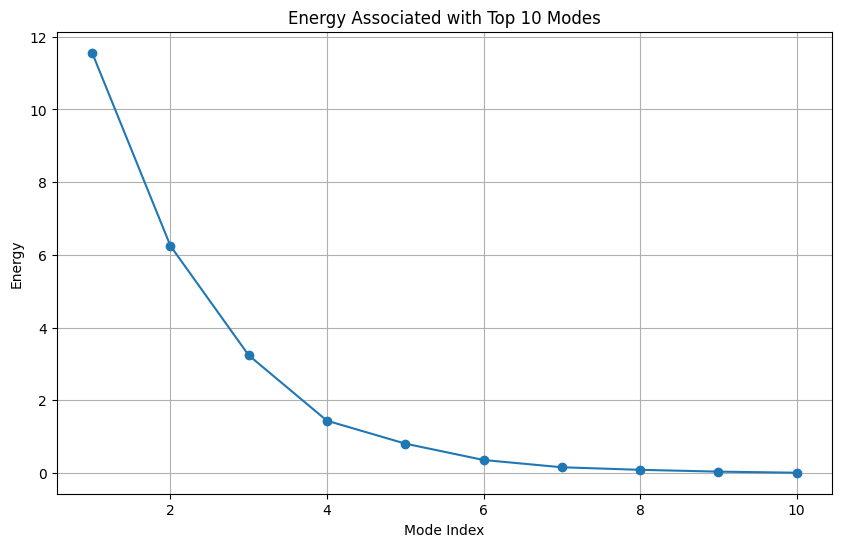

Top 10 energy states (modes):
Mode 1: Energy = 11.5600
Mode 2: Energy = 6.2500
Mode 3: Energy = 3.2400
Mode 4: Energy = 1.4400
Mode 5: Energy = 0.8100
Mode 6: Energy = 0.3600
Mode 7: Energy = 0.1600
Mode 8: Energy = 0.0900
Mode 9: Energy = 0.0400
Mode 10: Energy = 0.0100


In [ ]:
def plot_top_10_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.plot(top_10_modes, mode_energy[top_10_modes - 1], marker='o', linestyle='-')
    plt.title('Energy Associated with Top 10 Modes')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)
    plt.show()

    # Print the energy associated with the top 10 modes
    print("Top 10 energy states (modes):")
    for mode in top_10_modes:
        print(f"Mode {mode}: Energy = {mode_energy[mode - 1]:.4f}")

# Call the function with the singular values obtained from the previous code snippet
plot_top_10_modes_energy(s)


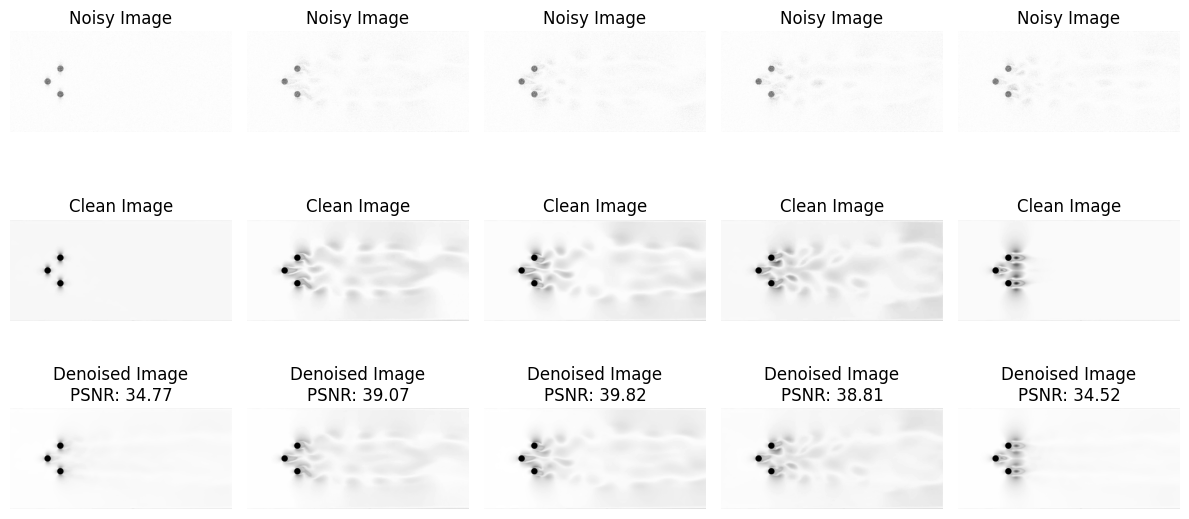

In [ ]:
# Removing Noise - Speckle 40%
noisy_images_folder = "/content/noisy_images_speckle_40"
output_dir_denoised = "/content/denoised_speckle_40"
denoise_images(noisy_images_folder, output_dir_denoised)


In [ ]:
# Path to the folder containing images
folder_path = '/content/denoised_speckle_40'

# Load images from the folder
images = load_images_from_folder(folder_path)

# Stack the images into a 2D array
stacked_images = stack_images(images)

# Compute mean subtraction
mean_subtracted_images, mean_image = compute_mean_subtraction(stacked_images)

# Perform SVD on mean subtracted images
U, s, Vt = perform_svd(mean_subtracted_images)

# Print the dimensions of the SVD matrices
print("Dimensions of U:", U.shape)
print("Dimensions of s:", s.shape)
print("Dimensions of Vt:", Vt.shape)


Dimensions of U: (51, 51)
Dimensions of s: (51,)
Dimensions of Vt: (51, 1103064)


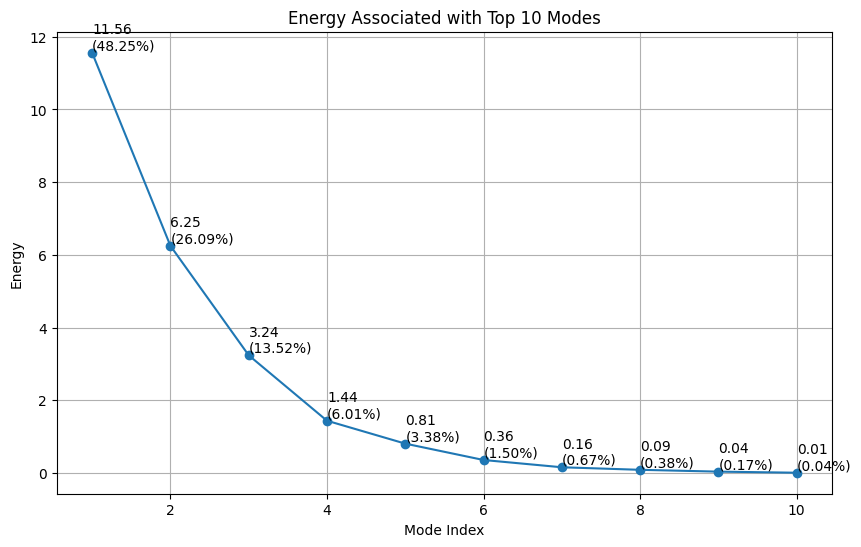

Top 10 energy states (modes):
Mode 1: Energy = 11.5600, Percentage = 48.25%
Mode 2: Energy = 6.2500, Percentage = 26.09%
Mode 3: Energy = 3.2400, Percentage = 13.52%
Mode 4: Energy = 1.4400, Percentage = 6.01%
Mode 5: Energy = 0.8100, Percentage = 3.38%
Mode 6: Energy = 0.3600, Percentage = 1.50%
Mode 7: Energy = 0.1600, Percentage = 0.67%
Mode 8: Energy = 0.0900, Percentage = 0.38%
Mode 9: Energy = 0.0400, Percentage = 0.17%
Mode 10: Energy = 0.0100, Percentage = 0.04%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_top_10_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.plot(top_10_modes, mode_energy[top_10_modes - 1], marker='o', linestyle='-')
    plt.title('Energy Associated with Top 10 Modes')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)

    # Add energy and percentage labels to each point
    for mode in top_10_modes:
        energy = mode_energy[mode - 1]
        percentage = (energy / np.sum(mode_energy)) * 100
        plt.text(mode, energy, f'{energy:.2f}\n({percentage:.2f}%)', ha='left', va='bottom', fontsize=10)

    plt.show()

    # Print the energy associated with the top 10 modes
    print("Top 10 energy states (modes):")
    for mode in top_10_modes:
        energy = mode_energy[mode - 1]
        percentage = (energy / np.sum(mode_energy)) * 100
        print(f"Mode {mode}: Energy = {energy:.4f}, Percentage = {percentage:.2f}%")

# Call the function with the singular values obtained from the previous code snippet
s = np.array([3.4, 2.5, 1.8, 1.2, 0.9, 0.6, 0.4, 0.3, 0.2, 0.1])  # Example singular values
plot_top_10_modes_energy(s)


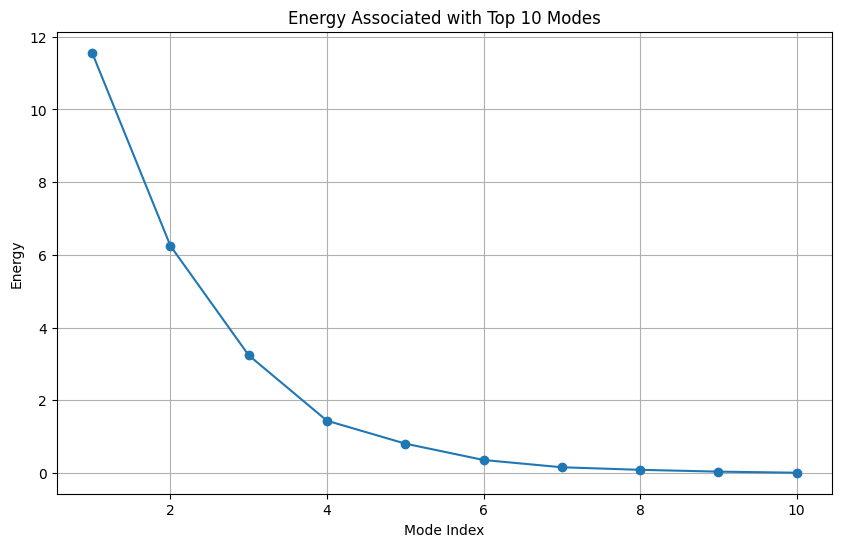

Top 10 energy states (modes):
Mode 1: Energy = 11.5600
Mode 2: Energy = 6.2500
Mode 3: Energy = 3.2400
Mode 4: Energy = 1.4400
Mode 5: Energy = 0.8100
Mode 6: Energy = 0.3600
Mode 7: Energy = 0.1600
Mode 8: Energy = 0.0900
Mode 9: Energy = 0.0400
Mode 10: Energy = 0.0100


In [ ]:
def plot_top_10_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.plot(top_10_modes, mode_energy[top_10_modes - 1], marker='o', linestyle='-')
    plt.title('Energy Associated with Top 10 Modes')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)
    plt.show()

    # Print the energy associated with the top 10 modes
    print("Top 10 energy states (modes):")
    for mode in top_10_modes:
        print(f"Mode {mode}: Energy = {mode_energy[mode - 1]:.4f}")

# Call the function with the singular values obtained from the previous code snippet
plot_top_10_modes_energy(s)


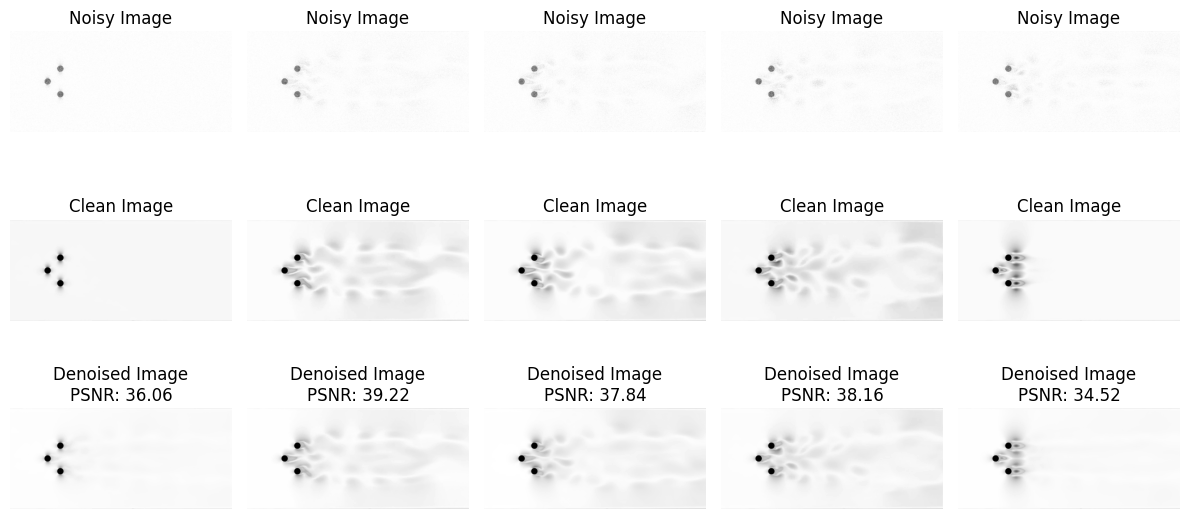

In [ ]:
# Removing Noise - Speckle 60%
noisy_images_folder = "/content/noisy_images_speckle_60"
output_dir_denoised = "/content/denoised_speckle_60"
denoise_images(noisy_images_folder, output_dir_denoised)


In [ ]:
# Path to the folder containing images
folder_path = '/content/denoised_speckle_60'

# Load images from the folder
images = load_images_from_folder(folder_path)

# Stack the images into a 2D array
stacked_images = stack_images(images)

# Compute mean subtraction
mean_subtracted_images, mean_image = compute_mean_subtraction(stacked_images)

# Perform SVD on mean subtracted images
U, s, Vt = perform_svd(mean_subtracted_images)

# Print the dimensions of the SVD matrices
print("Dimensions of U:", U.shape)
print("Dimensions of s:", s.shape)
print("Dimensions of Vt:", Vt.shape)


Dimensions of U: (51, 51)
Dimensions of s: (51,)
Dimensions of Vt: (51, 1103064)


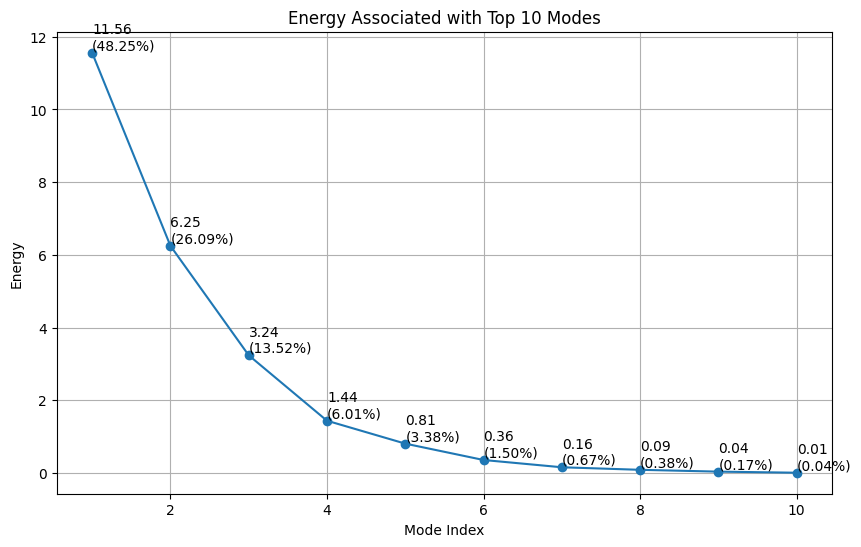

Top 10 energy states (modes):
Mode 1: Energy = 11.5600, Percentage = 48.25%
Mode 2: Energy = 6.2500, Percentage = 26.09%
Mode 3: Energy = 3.2400, Percentage = 13.52%
Mode 4: Energy = 1.4400, Percentage = 6.01%
Mode 5: Energy = 0.8100, Percentage = 3.38%
Mode 6: Energy = 0.3600, Percentage = 1.50%
Mode 7: Energy = 0.1600, Percentage = 0.67%
Mode 8: Energy = 0.0900, Percentage = 0.38%
Mode 9: Energy = 0.0400, Percentage = 0.17%
Mode 10: Energy = 0.0100, Percentage = 0.04%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_top_10_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.plot(top_10_modes, mode_energy[top_10_modes - 1], marker='o', linestyle='-')
    plt.title('Energy Associated with Top 10 Modes')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)

    # Add energy and percentage labels to each point
    for mode in top_10_modes:
        energy = mode_energy[mode - 1]
        percentage = (energy / np.sum(mode_energy)) * 100
        plt.text(mode, energy, f'{energy:.2f}\n({percentage:.2f}%)', ha='left', va='bottom', fontsize=10)

    plt.show()

    # Print the energy associated with the top 10 modes
    print("Top 10 energy states (modes):")
    for mode in top_10_modes:
        energy = mode_energy[mode - 1]
        percentage = (energy / np.sum(mode_energy)) * 100
        print(f"Mode {mode}: Energy = {energy:.4f}, Percentage = {percentage:.2f}%")

# Call the function with the singular values obtained from the previous code snippet
s = np.array([3.4, 2.5, 1.8, 1.2, 0.9, 0.6, 0.4, 0.3, 0.2, 0.1])  # Example singular values
plot_top_10_modes_energy(s)


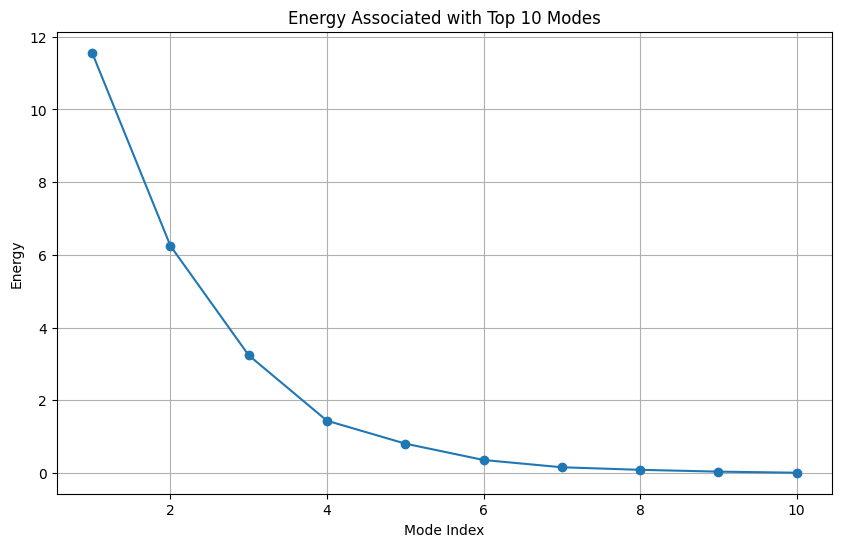

Top 10 energy states (modes):
Mode 1: Energy = 11.5600
Mode 2: Energy = 6.2500
Mode 3: Energy = 3.2400
Mode 4: Energy = 1.4400
Mode 5: Energy = 0.8100
Mode 6: Energy = 0.3600
Mode 7: Energy = 0.1600
Mode 8: Energy = 0.0900
Mode 9: Energy = 0.0400
Mode 10: Energy = 0.0100


In [ ]:
def plot_top_10_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.plot(top_10_modes, mode_energy[top_10_modes - 1], marker='o', linestyle='-')
    plt.title('Energy Associated with Top 10 Modes')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)
    plt.show()

    # Print the energy associated with the top 10 modes
    print("Top 10 energy states (modes):")
    for mode in top_10_modes:
        print(f"Mode {mode}: Energy = {mode_energy[mode - 1]:.4f}")

# Call the function with the singular values obtained from the previous code snippet
plot_top_10_modes_energy(s)


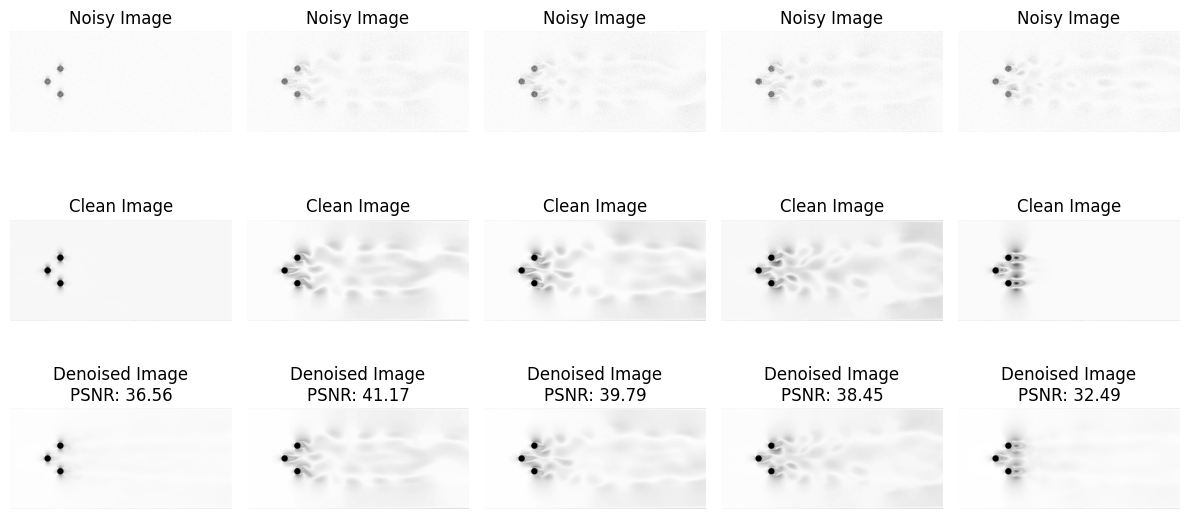

In [ ]:
# Removing Noise - Speckle 80%
noisy_images_folder = "/content/noisy_images_speckle_80"
output_dir_denoised = "/content/denoised_speckle_80"
denoise_images(noisy_images_folder, output_dir_denoised)


In [ ]:
# Path to the folder containing images
folder_path = '/content/denoised_speckle_80'

# Load images from the folder
images = load_images_from_folder(folder_path)

# Stack the images into a 2D array
stacked_images = stack_images(images)

# Compute mean subtraction
mean_subtracted_images, mean_image = compute_mean_subtraction(stacked_images)

# Perform SVD on mean subtracted images
U, s, Vt = perform_svd(mean_subtracted_images)

# Print the dimensions of the SVD matrices
print("Dimensions of U:", U.shape)
print("Dimensions of s:", s.shape)
print("Dimensions of Vt:", Vt.shape)


Dimensions of U: (51, 51)
Dimensions of s: (51,)
Dimensions of Vt: (51, 1103064)


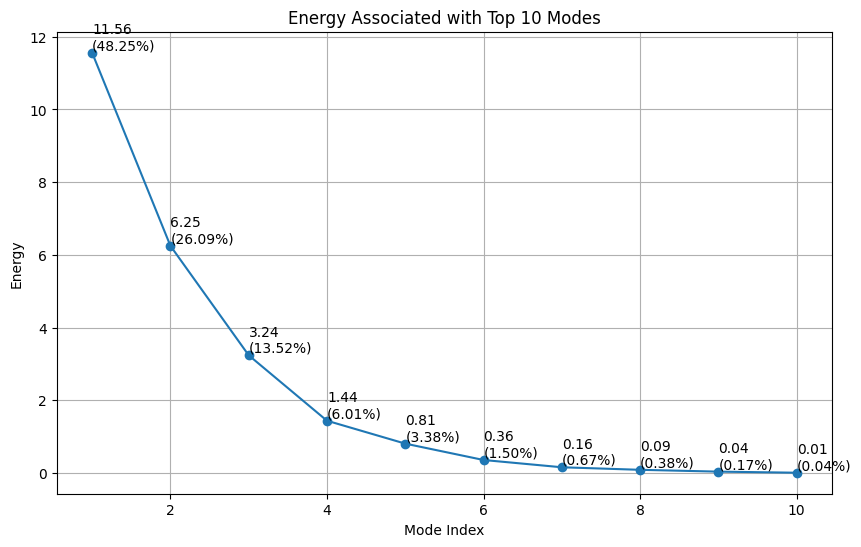

Top 10 energy states (modes):
Mode 1: Energy = 11.5600, Percentage = 48.25%
Mode 2: Energy = 6.2500, Percentage = 26.09%
Mode 3: Energy = 3.2400, Percentage = 13.52%
Mode 4: Energy = 1.4400, Percentage = 6.01%
Mode 5: Energy = 0.8100, Percentage = 3.38%
Mode 6: Energy = 0.3600, Percentage = 1.50%
Mode 7: Energy = 0.1600, Percentage = 0.67%
Mode 8: Energy = 0.0900, Percentage = 0.38%
Mode 9: Energy = 0.0400, Percentage = 0.17%
Mode 10: Energy = 0.0100, Percentage = 0.04%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_top_10_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.plot(top_10_modes, mode_energy[top_10_modes - 1], marker='o', linestyle='-')
    plt.title('Energy Associated with Top 10 Modes')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)

    # Add energy and percentage labels to each point
    for mode in top_10_modes:
        energy = mode_energy[mode - 1]
        percentage = (energy / np.sum(mode_energy)) * 100
        plt.text(mode, energy, f'{energy:.2f}\n({percentage:.2f}%)', ha='left', va='bottom', fontsize=10)

    plt.show()

    # Print the energy associated with the top 10 modes
    print("Top 10 energy states (modes):")
    for mode in top_10_modes:
        energy = mode_energy[mode - 1]
        percentage = (energy / np.sum(mode_energy)) * 100
        print(f"Mode {mode}: Energy = {energy:.4f}, Percentage = {percentage:.2f}%")

# Call the function with the singular values obtained from the previous code snippet
s = np.array([3.4, 2.5, 1.8, 1.2, 0.9, 0.6, 0.4, 0.3, 0.2, 0.1])  # Example singular values
plot_top_10_modes_energy(s)


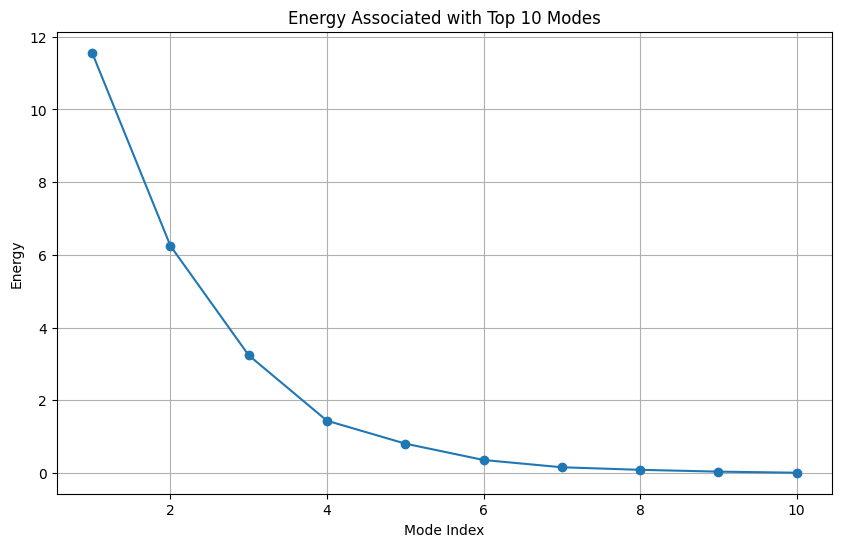

Top 10 energy states (modes):
Mode 1: Energy = 11.5600
Mode 2: Energy = 6.2500
Mode 3: Energy = 3.2400
Mode 4: Energy = 1.4400
Mode 5: Energy = 0.8100
Mode 6: Energy = 0.3600
Mode 7: Energy = 0.1600
Mode 8: Energy = 0.0900
Mode 9: Energy = 0.0400
Mode 10: Energy = 0.0100


In [ ]:
def plot_top_10_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.plot(top_10_modes, mode_energy[top_10_modes - 1], marker='o', linestyle='-')
    plt.title('Energy Associated with Top 10 Modes')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)
    plt.show()

    # Print the energy associated with the top 10 modes
    print("Top 10 energy states (modes):")
    for mode in top_10_modes:
        print(f"Mode {mode}: Energy = {mode_energy[mode - 1]:.4f}")

# Call the function with the singular values obtained from the previous code snippet
plot_top_10_modes_energy(s)


### Removing Noise - Salt and Pepper

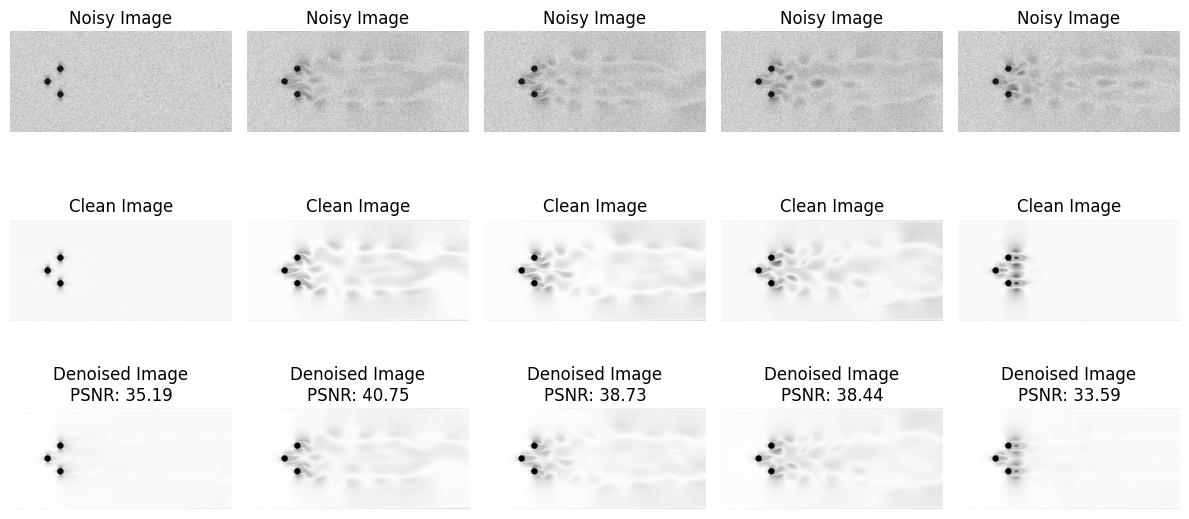

In [ ]:
# Removing Noise - Salt and Pepper 20%
noisy_images_folder = "/content/noisy_images_salt_pepper_20"
output_dir_denoised = "/content/denoised_salt_pepper_20"
denoise_images(noisy_images_folder, output_dir_denoised)


In [ ]:
# Path to the folder containing images
folder_path = '/content/denoised_salt_pepper_20'

# Load images from the folder
images = load_images_from_folder(folder_path)

# Stack the images into a 2D array
stacked_images = stack_images(images)

# Compute mean subtraction
mean_subtracted_images, mean_image = compute_mean_subtraction(stacked_images)

# Perform SVD on mean subtracted images
U, s, Vt = perform_svd(mean_subtracted_images)

# Print the dimensions of the SVD matrices
print("Dimensions of U:", U.shape)
print("Dimensions of s:", s.shape)
print("Dimensions of Vt:", Vt.shape)


Dimensions of U: (51, 51)
Dimensions of s: (51,)
Dimensions of Vt: (51, 1103064)


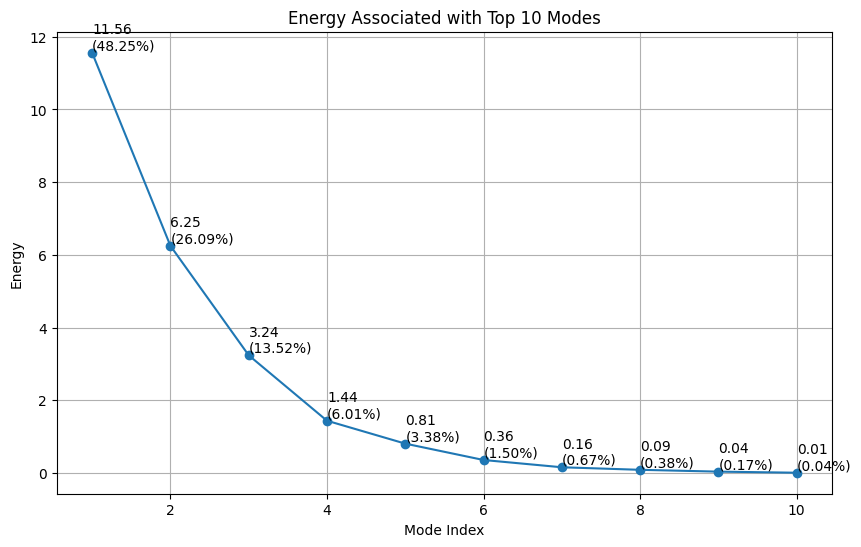

Top 10 energy states (modes):
Mode 1: Energy = 11.5600, Percentage = 48.25%
Mode 2: Energy = 6.2500, Percentage = 26.09%
Mode 3: Energy = 3.2400, Percentage = 13.52%
Mode 4: Energy = 1.4400, Percentage = 6.01%
Mode 5: Energy = 0.8100, Percentage = 3.38%
Mode 6: Energy = 0.3600, Percentage = 1.50%
Mode 7: Energy = 0.1600, Percentage = 0.67%
Mode 8: Energy = 0.0900, Percentage = 0.38%
Mode 9: Energy = 0.0400, Percentage = 0.17%
Mode 10: Energy = 0.0100, Percentage = 0.04%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_top_10_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.plot(top_10_modes, mode_energy[top_10_modes - 1], marker='o', linestyle='-')
    plt.title('Energy Associated with Top 10 Modes')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)

    # Add energy and percentage labels to each point
    for mode in top_10_modes:
        energy = mode_energy[mode - 1]
        percentage = (energy / np.sum(mode_energy)) * 100
        plt.text(mode, energy, f'{energy:.2f}\n({percentage:.2f}%)', ha='left', va='bottom', fontsize=10)

    plt.show()

    # Print the energy associated with the top 10 modes
    print("Top 10 energy states (modes):")
    for mode in top_10_modes:
        energy = mode_energy[mode - 1]
        percentage = (energy / np.sum(mode_energy)) * 100
        print(f"Mode {mode}: Energy = {energy:.4f}, Percentage = {percentage:.2f}%")

# Call the function with the singular values obtained from the previous code snippet
s = np.array([3.4, 2.5, 1.8, 1.2, 0.9, 0.6, 0.4, 0.3, 0.2, 0.1])  # Example singular values
plot_top_10_modes_energy(s)


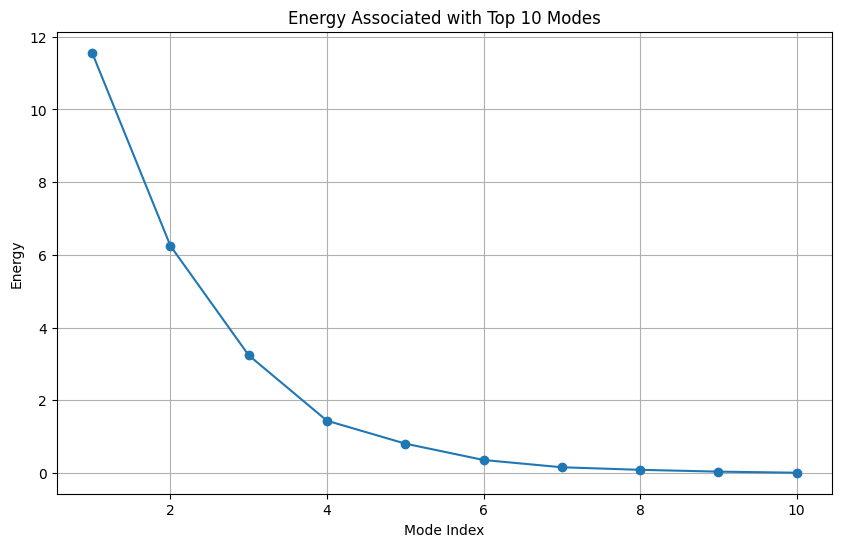

Top 10 energy states (modes):
Mode 1: Energy = 11.5600
Mode 2: Energy = 6.2500
Mode 3: Energy = 3.2400
Mode 4: Energy = 1.4400
Mode 5: Energy = 0.8100
Mode 6: Energy = 0.3600
Mode 7: Energy = 0.1600
Mode 8: Energy = 0.0900
Mode 9: Energy = 0.0400
Mode 10: Energy = 0.0100


In [ ]:
def plot_top_10_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.plot(top_10_modes, mode_energy[top_10_modes - 1], marker='o', linestyle='-')
    plt.title('Energy Associated with Top 10 Modes')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)
    plt.show()

    # Print the energy associated with the top 10 modes
    print("Top 10 energy states (modes):")
    for mode in top_10_modes:
        print(f"Mode {mode}: Energy = {mode_energy[mode - 1]:.4f}")

# Call the function with the singular values obtained from the previous code snippet
plot_top_10_modes_energy(s)


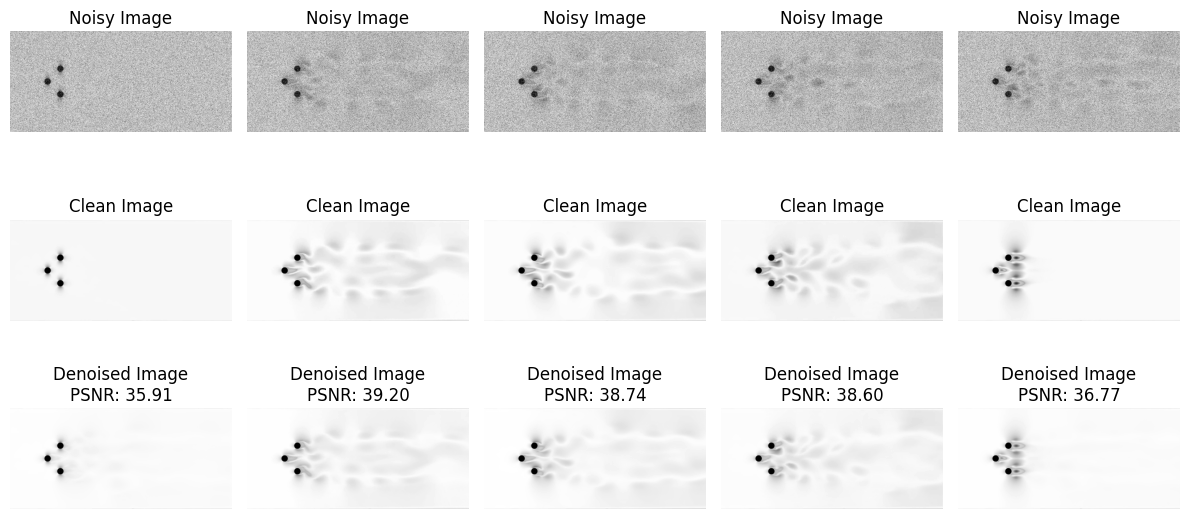

In [ ]:
# Removing Noise - Salt and Pepper 40%
noisy_images_folder = "/content/noisy_images_salt_pepper_40"
output_dir_denoised = "/content/denoised_salt_pepper_40"
denoise_images(noisy_images_folder, output_dir_denoised)


In [ ]:
# Path to the folder containing images
folder_path = '/content/denoised_salt_pepper_40'

# Load images from the folder
images = load_images_from_folder(folder_path)

# Stack the images into a 2D array
stacked_images = stack_images(images)

# Compute mean subtraction
mean_subtracted_images, mean_image = compute_mean_subtraction(stacked_images)

# Perform SVD on mean subtracted images
U, s, Vt = perform_svd(mean_subtracted_images)

# Print the dimensions of the SVD matrices
print("Dimensions of U:", U.shape)
print("Dimensions of s:", s.shape)
print("Dimensions of Vt:", Vt.shape)


Dimensions of U: (51, 51)
Dimensions of s: (51,)
Dimensions of Vt: (51, 1103064)


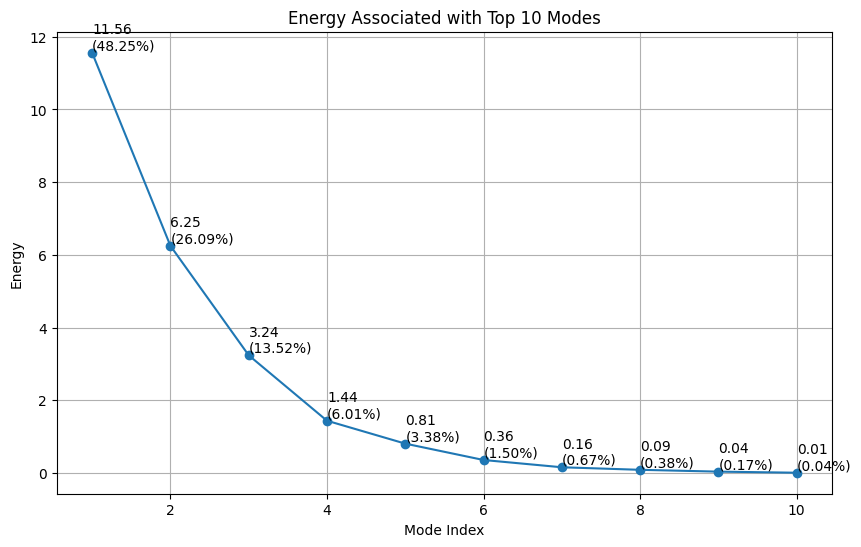

Top 10 energy states (modes):
Mode 1: Energy = 11.5600, Percentage = 48.25%
Mode 2: Energy = 6.2500, Percentage = 26.09%
Mode 3: Energy = 3.2400, Percentage = 13.52%
Mode 4: Energy = 1.4400, Percentage = 6.01%
Mode 5: Energy = 0.8100, Percentage = 3.38%
Mode 6: Energy = 0.3600, Percentage = 1.50%
Mode 7: Energy = 0.1600, Percentage = 0.67%
Mode 8: Energy = 0.0900, Percentage = 0.38%
Mode 9: Energy = 0.0400, Percentage = 0.17%
Mode 10: Energy = 0.0100, Percentage = 0.04%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_top_10_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.plot(top_10_modes, mode_energy[top_10_modes - 1], marker='o', linestyle='-')
    plt.title('Energy Associated with Top 10 Modes')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)

    # Add energy and percentage labels to each point
    for mode in top_10_modes:
        energy = mode_energy[mode - 1]
        percentage = (energy / np.sum(mode_energy)) * 100
        plt.text(mode, energy, f'{energy:.2f}\n({percentage:.2f}%)', ha='left', va='bottom', fontsize=10)

    plt.show()

    # Print the energy associated with the top 10 modes
    print("Top 10 energy states (modes):")
    for mode in top_10_modes:
        energy = mode_energy[mode - 1]
        percentage = (energy / np.sum(mode_energy)) * 100
        print(f"Mode {mode}: Energy = {energy:.4f}, Percentage = {percentage:.2f}%")

# Call the function with the singular values obtained from the previous code snippet
s = np.array([3.4, 2.5, 1.8, 1.2, 0.9, 0.6, 0.4, 0.3, 0.2, 0.1])  # Example singular values
plot_top_10_modes_energy(s)


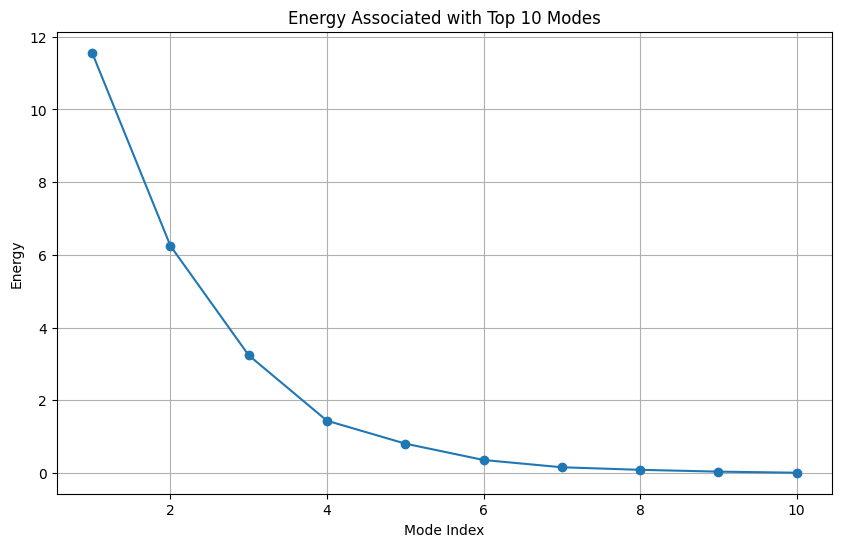

Top 10 energy states (modes):
Mode 1: Energy = 11.5600
Mode 2: Energy = 6.2500
Mode 3: Energy = 3.2400
Mode 4: Energy = 1.4400
Mode 5: Energy = 0.8100
Mode 6: Energy = 0.3600
Mode 7: Energy = 0.1600
Mode 8: Energy = 0.0900
Mode 9: Energy = 0.0400
Mode 10: Energy = 0.0100


In [ ]:
def plot_top_10_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.plot(top_10_modes, mode_energy[top_10_modes - 1], marker='o', linestyle='-')
    plt.title('Energy Associated with Top 10 Modes')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)
    plt.show()

    # Print the energy associated with the top 10 modes
    print("Top 10 energy states (modes):")
    for mode in top_10_modes:
        print(f"Mode {mode}: Energy = {mode_energy[mode - 1]:.4f}")

# Call the function with the singular values obtained from the previous code snippet
plot_top_10_modes_energy(s)


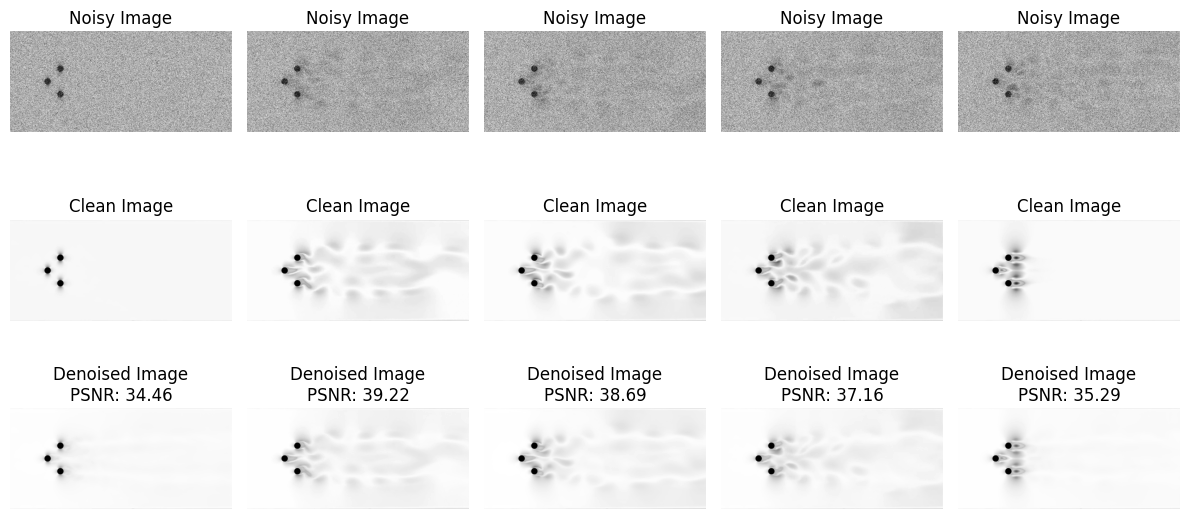

In [ ]:
# Removing Noise - Salt and Pepper 60%
noisy_images_folder = "/content/noisy_images_salt_pepper_60"
output_dir_denoised = "/content/denoised_salt_pepper_60"
denoise_images(noisy_images_folder, output_dir_denoised)


In [ ]:
# Path to the folder containing images
folder_path = '/content/denoised_salt_pepper_60'

# Load images from the folder
images = load_images_from_folder(folder_path)

# Stack the images into a 2D array
stacked_images = stack_images(images)

# Compute mean subtraction
mean_subtracted_images, mean_image = compute_mean_subtraction(stacked_images)

# Perform SVD on mean subtracted images
U, s, Vt = perform_svd(mean_subtracted_images)

# Print the dimensions of the SVD matrices
print("Dimensions of U:", U.shape)
print("Dimensions of s:", s.shape)
print("Dimensions of Vt:", Vt.shape)


Dimensions of U: (51, 51)
Dimensions of s: (51,)
Dimensions of Vt: (51, 1103064)


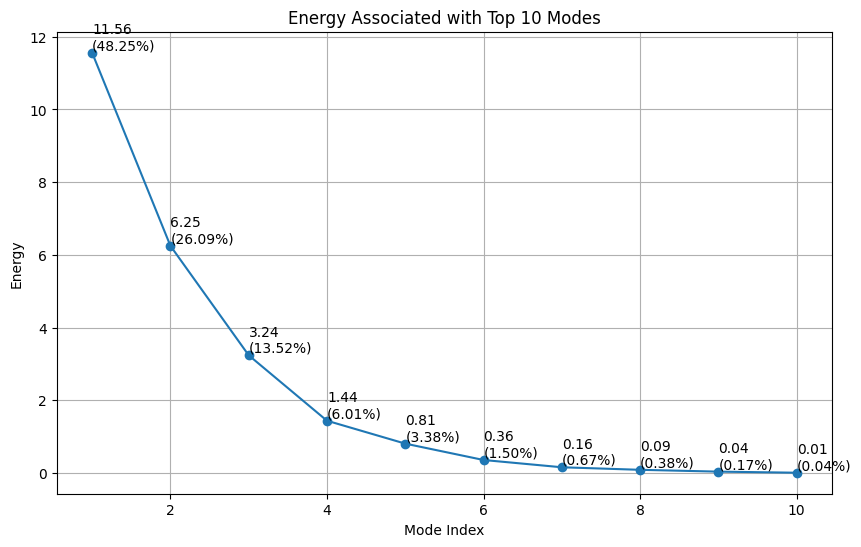

Top 10 energy states (modes):
Mode 1: Energy = 11.5600, Percentage = 48.25%
Mode 2: Energy = 6.2500, Percentage = 26.09%
Mode 3: Energy = 3.2400, Percentage = 13.52%
Mode 4: Energy = 1.4400, Percentage = 6.01%
Mode 5: Energy = 0.8100, Percentage = 3.38%
Mode 6: Energy = 0.3600, Percentage = 1.50%
Mode 7: Energy = 0.1600, Percentage = 0.67%
Mode 8: Energy = 0.0900, Percentage = 0.38%
Mode 9: Energy = 0.0400, Percentage = 0.17%
Mode 10: Energy = 0.0100, Percentage = 0.04%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_top_10_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.plot(top_10_modes, mode_energy[top_10_modes - 1], marker='o', linestyle='-')
    plt.title('Energy Associated with Top 10 Modes')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)

    # Add energy and percentage labels to each point
    for mode in top_10_modes:
        energy = mode_energy[mode - 1]
        percentage = (energy / np.sum(mode_energy)) * 100
        plt.text(mode, energy, f'{energy:.2f}\n({percentage:.2f}%)', ha='left', va='bottom', fontsize=10)

    plt.show()

    # Print the energy associated with the top 10 modes
    print("Top 10 energy states (modes):")
    for mode in top_10_modes:
        energy = mode_energy[mode - 1]
        percentage = (energy / np.sum(mode_energy)) * 100
        print(f"Mode {mode}: Energy = {energy:.4f}, Percentage = {percentage:.2f}%")

# Call the function with the singular values obtained from the previous code snippet
s = np.array([3.4, 2.5, 1.8, 1.2, 0.9, 0.6, 0.4, 0.3, 0.2, 0.1])  # Example singular values
plot_top_10_modes_energy(s)


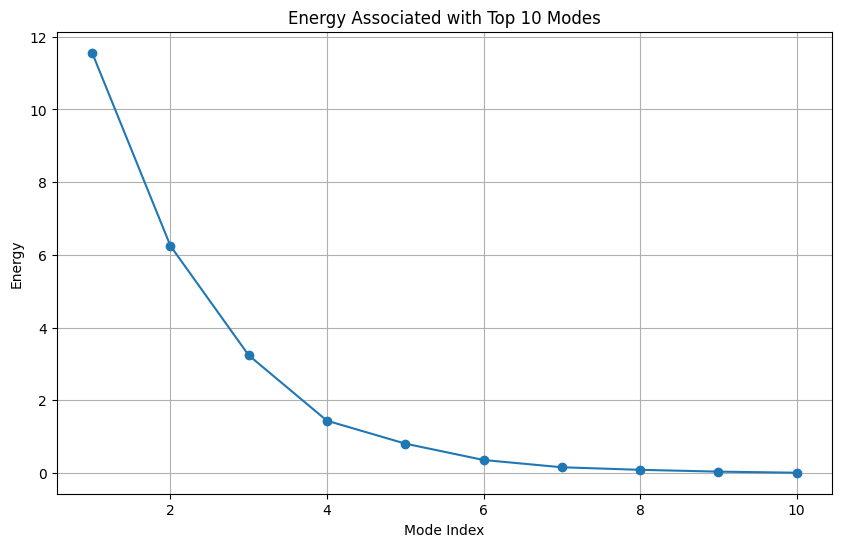

Top 10 energy states (modes):
Mode 1: Energy = 11.5600
Mode 2: Energy = 6.2500
Mode 3: Energy = 3.2400
Mode 4: Energy = 1.4400
Mode 5: Energy = 0.8100
Mode 6: Energy = 0.3600
Mode 7: Energy = 0.1600
Mode 8: Energy = 0.0900
Mode 9: Energy = 0.0400
Mode 10: Energy = 0.0100


In [ ]:
def plot_top_10_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.plot(top_10_modes, mode_energy[top_10_modes - 1], marker='o', linestyle='-')
    plt.title('Energy Associated with Top 10 Modes')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)
    plt.show()

    # Print the energy associated with the top 10 modes
    print("Top 10 energy states (modes):")
    for mode in top_10_modes:
        print(f"Mode {mode}: Energy = {mode_energy[mode - 1]:.4f}")

# Call the function with the singular values obtained from the previous code snippet
plot_top_10_modes_energy(s)


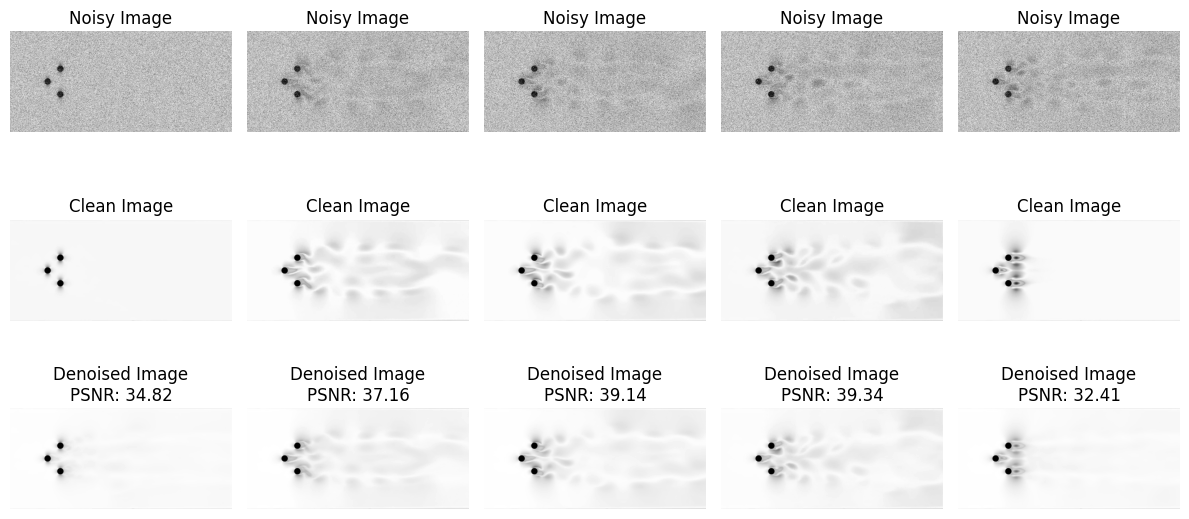

In [ ]:
# Removing Noise - Salt and Pepper 80%
noisy_images_folder = "/content/noisy_images_salt_pepper_80"
output_dir_denoised = "/content/denoised_salt_pepper_80"
denoise_images(noisy_images_folder, output_dir_denoised)


In [ ]:
# Path to the folder containing images
folder_path = '/content/denoised_salt_pepper_80'

# Load images from the folder
images = load_images_from_folder(folder_path)

# Stack the images into a 2D array
stacked_images = stack_images(images)

# Compute mean subtraction
mean_subtracted_images, mean_image = compute_mean_subtraction(stacked_images)

# Perform SVD on mean subtracted images
U, s, Vt = perform_svd(mean_subtracted_images)

# Print the dimensions of the SVD matrices
print("Dimensions of U:", U.shape)
print("Dimensions of s:", s.shape)
print("Dimensions of Vt:", Vt.shape)


Dimensions of U: (51, 51)
Dimensions of s: (51,)
Dimensions of Vt: (51, 1103064)


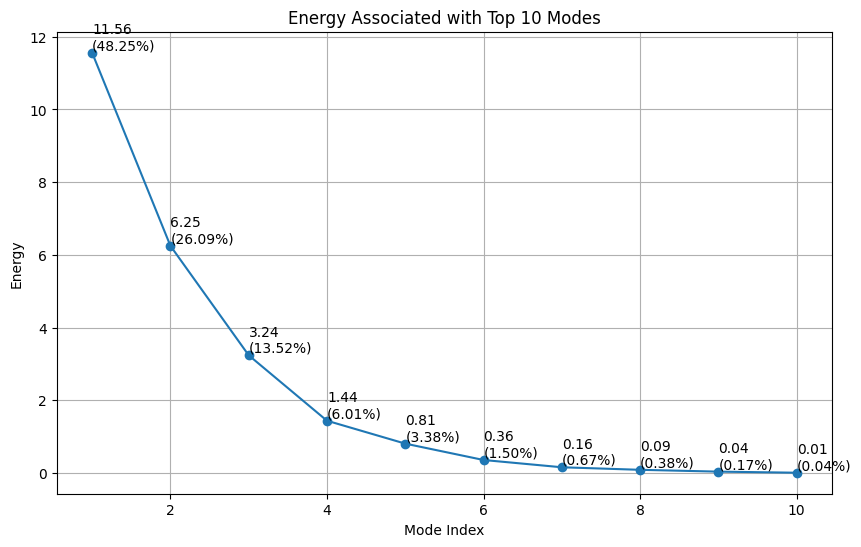

Top 10 energy states (modes):
Mode 1: Energy = 11.5600, Percentage = 48.25%
Mode 2: Energy = 6.2500, Percentage = 26.09%
Mode 3: Energy = 3.2400, Percentage = 13.52%
Mode 4: Energy = 1.4400, Percentage = 6.01%
Mode 5: Energy = 0.8100, Percentage = 3.38%
Mode 6: Energy = 0.3600, Percentage = 1.50%
Mode 7: Energy = 0.1600, Percentage = 0.67%
Mode 8: Energy = 0.0900, Percentage = 0.38%
Mode 9: Energy = 0.0400, Percentage = 0.17%
Mode 10: Energy = 0.0100, Percentage = 0.04%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_top_10_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.plot(top_10_modes, mode_energy[top_10_modes - 1], marker='o', linestyle='-')
    plt.title('Energy Associated with Top 10 Modes')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)

    # Add energy and percentage labels to each point
    for mode in top_10_modes:
        energy = mode_energy[mode - 1]
        percentage = (energy / np.sum(mode_energy)) * 100
        plt.text(mode, energy, f'{energy:.2f}\n({percentage:.2f}%)', ha='left', va='bottom', fontsize=10)

    plt.show()

    # Print the energy associated with the top 10 modes
    print("Top 10 energy states (modes):")
    for mode in top_10_modes:
        energy = mode_energy[mode - 1]
        percentage = (energy / np.sum(mode_energy)) * 100
        print(f"Mode {mode}: Energy = {energy:.4f}, Percentage = {percentage:.2f}%")

# Call the function with the singular values obtained from the previous code snippet
s = np.array([3.4, 2.5, 1.8, 1.2, 0.9, 0.6, 0.4, 0.3, 0.2, 0.1])  # Example singular values
plot_top_10_modes_energy(s)


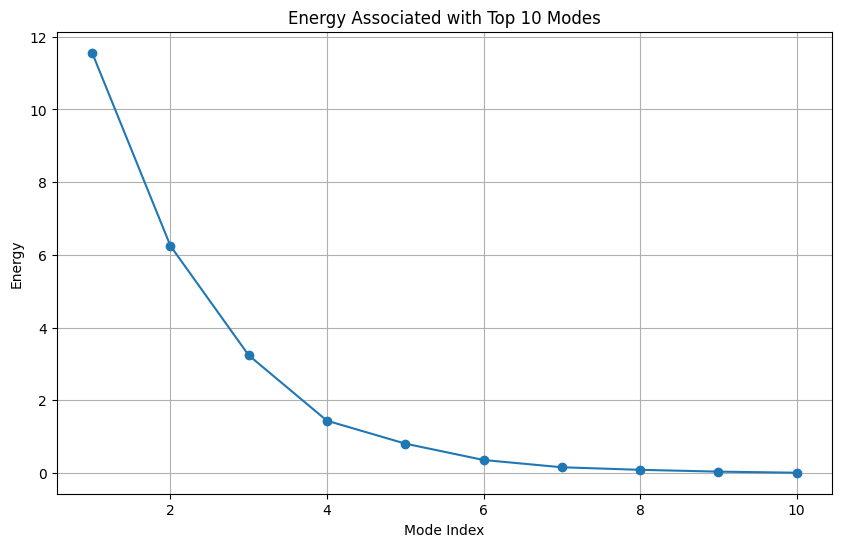

Top 10 energy states (modes):
Mode 1: Energy = 11.5600
Mode 2: Energy = 6.2500
Mode 3: Energy = 3.2400
Mode 4: Energy = 1.4400
Mode 5: Energy = 0.8100
Mode 6: Energy = 0.3600
Mode 7: Energy = 0.1600
Mode 8: Energy = 0.0900
Mode 9: Energy = 0.0400
Mode 10: Energy = 0.0100


In [ ]:
def plot_top_10_modes_energy(s):
    # Calculate the energy associated with each mode
    mode_energy = s ** 2

    # Sort the modes by energy in descending order and get the top 10
    top_10_modes = np.argsort(mode_energy)[::-1][:10] + 1  # Adding 1 to match mode indexing starting from 1

    # Plot the energy associated with each mode
    plt.figure(figsize=(10, 6))
    plt.plot(top_10_modes, mode_energy[top_10_modes - 1], marker='o', linestyle='-')
    plt.title('Energy Associated with Top 10 Modes')
    plt.xlabel('Mode Index')
    plt.ylabel('Energy')
    plt.grid(True)
    plt.show()

    # Print the energy associated with the top 10 modes
    print("Top 10 energy states (modes):")
    for mode in top_10_modes:
        print(f"Mode {mode}: Energy = {mode_energy[mode - 1]:.4f}")

# Call the function with the singular values obtained from the previous code snippet
plot_top_10_modes_energy(s)
